# Построение ML-продукта для оптимизации классификации заявок на оплату для сервиса Repetit.ru

Сервис Repetit.ru работает с большим количеством заявок от клиентов. К сожалению, 7 из 8 не доходят до оплаты, при этом обработка заявки консультантом увеличивает конверсию в оплату на 30%. 

Проблема заключается в том, что консультантов не хватает на все заявки. Таким образом, чем больше заявок — тем меньше конверсия из заявки в оплату и как следствие консультанты тратят время на бесперспективные заявки. Заказчик хочет понять, какие заявки будут оплачены, а какие нет, чтобы одни обрабатывать вручную консультантами, а другие нет.

Для решения данной проблемы была поставлена следующая задача: необходимо разработать модель, которая по имеющейся информации о клиенте и заявке будет предсказывать вероятность оплаты заявки клиентом. Оценка качества модели будет производиться с использованием precision и ROC-AUC. 



Для решения задачи был составлен примерный план работ:
1. Загрузка данных и ознакомление с ними
2. Предварительная обработка данных
3. Полный разведочный анализ
4. Разработка новых признаков
5. Построение модели 
6. Оценка модели на тестовом наборе данных

**Краткое описание данных:** данные, использовавшиеся для разработки данного проекта состоят из четырех датасетов:
1. Orders - набор данных о поступающих заявках
2. Teacher_info - данные о представленных репетиторах
3. Suitable_teachers - данные о подходящих по фильтру репетиторы
4. Prefered_teachers - данные о желаемых репетиторах

### Установка необходимых библиотек

In [1]:
!pip install pyarrow

In [2]:
!pip install catboost

In [1]:
import pandas as pd
import numpy as np
import pyarrow.feather as feather
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re
import pymorphy2
import nltk
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from catboost import CatBoostClassifier
from imblearn.pipeline import make_pipeline as make_imblearn_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from feature_engine.selection import DropCorrelatedFeatures
from sklearn.compose import ColumnTransformer, make_column_transformer 
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.feature_selection import mutual_info_classif

## 1. Загрузка данных

In [2]:
path = '/Users/olesyakolpakova/Desktop/Projects/Repetit/'

In [10]:
def load_data(data):
    print('Размер набора данных:', data.shape)
    print(data.info())
    return data.head()

### 1.1 Данные о заявках

In [4]:
orders = feather.read_feather(f'{path}orders.feather')

In [11]:
load_data(orders)

Размер набора данных: (1191861, 38)
<class 'pandas.core.frame.DataFrame'>
Index: 1191861 entries, 0 to 437216
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1191861 non-null  int32  
 1   order_date               1191861 non-null  object 
 2   subject_id               1181529 non-null  float32
 3   purpose                  1025351 non-null  object 
 4   lesson_price             1191861 non-null  int32  
 5   lesson_duration          1191861 non-null  int32  
 6   lesson_place             31 non-null       object 
 7   home_metro_id            642447 non-null   float32
 8   add_info                 1044688 non-null  object 
 9   start_date               705578 non-null   object 
 10  working_teacher_id       705988 non-null   float32
 11  status_id                1191861 non-null  int32  
 12  comments                 341468 non-null   object 
 13  prefered_tea

id               order_date  subject_id  \
0  2294054  2022-11-01 00:01:38.237         1.0   
1  2294055  2022-11-01 00:03:11.753         1.0   
2  2294056  2022-11-01 00:04:01.563        21.0   
3  2294057  2022-11-01 00:08:47.237         8.0   
4  2294058  2022-11-01 00:11:49.417         8.0   

                                             purpose  lesson_price  \
0                                               None             0   
1                                               None             0   
2  Разделы: начертательная геометрия.\nКатегория ...           800   
3  Разделы:  школьный курс.\nКатегория ученика: ш...           700   
4                                               None             0   

   lesson_duration lesson_place  home_metro_id  \
0               60         None            NaN   
1               60         None            NaN   
2               60         None            NaN   
3               60         None            NaN   
4               60         None          122.0   

                                            add_info               start_date  \
0                                               None                     None   
1                                               None                     None   
2  Место проведения занятий: дистанционно (наприм...  2022-11-01 10:37:02.567   
3  Место проведения занятий: дистанционно (наприм...  2022-11-01 00:08:47.437   
4                                               None                     None   

   ...  chosen_teachers_only  no_teachers_available source_id  \
0  ...                     0                      0        18   
1  ...                     0                      0        18   
2  ...                     0                      0        23   
3  ...                     0                      0        14   
4  ...                     0                      0        16   

   original_order_id client_id  additional_status_id max_metro_distance  \
0          2294000.0    675960                   7.0                NaN   
1          2294000.0    675960                   7.0                NaN   
2                NaN   1024439                  10.0                NaN   
3          2293804.0   1024340                  17.0                NaN   
4                NaN   1024440                   5.0                NaN   

   estimated_fee  payment_date  is_display_to_teachers  
0           None          None                       1  
1           None          None                       1  
2           1200          None                       1  
3           2310          None                       1  
4           None          None                       1  

[5 rows x 38 columns]

In [12]:
orders_copy = feather.read_feather(f'{path}orders.feather')

В этом наборе данных содержится 38 столбцов, однако во многих из них содержатся пропуски. Некоторые столбцы для дальнейшего анализа не нужны, отбор признаков будет реализован в пункте 2.

### 1.2 Данные о репетиторах

In [13]:
teachers_info = feather.read_feather(f'{path}teachers_info.feather')

In [14]:
load_data(teachers_info)

Размер набора данных: (307972, 80)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 80 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   id                          307972 non-null  int32   
 1   date_update                 307972 non-null  category
 2   reg_date                    307972 non-null  category
 3   birth_date                  307972 non-null  category
 4   teaching_start_date         307972 non-null  category
 5   user_id                     307972 non-null  int32   
 6   is_email_confirmed          307972 non-null  int8    
 7   is_home_lessons             307972 non-null  int8    
 8   is_external_lessons         307972 non-null  int8    
 9   external_comments           90978 non-null   category
 10  lesson_duration             307972 non-null  int16   
 11  lesson_cost                 307972 non-null  int32   
 12  status_id              

id              date_update                 reg_date  \
0  33  2023-11-07 14:20:28.323  2007-12-24 19:26:46.000   
1  46  2023-01-19 17:36:42.233  2007-12-24 19:26:46.000   
2  51  2023-05-25 09:04:45.243  2007-12-24 19:26:46.000   
3  52  2023-01-19 10:39:20.767  2007-12-24 19:26:46.000   
4  54  2023-01-19 16:28:36.517  2007-12-24 19:26:46.000   

                birth_date      teaching_start_date  user_id  \
0  1983-06-05 00:00:00.000  1989-09-01 00:00:00.000       45   
1  1980-02-12 00:00:00.000  2003-09-01 00:00:00.000       63   
2  1965-04-30 00:00:00.000  1988-09-01 00:00:00.000       68   
3  1988-07-06 00:00:00.000  2006-09-01 00:00:00.000       69   
4  1985-09-30 00:00:00.000  2004-01-01 00:00:00.000       70   

   is_email_confirmed  is_home_lessons  is_external_lessons  \
0                   0                0                    0   
1                   0                1                    1   
2                   0                0                    0   
3                   0                0                    1   
4                   0                0                    1   

                          external_comments  ...  verification_status_id  \
0                                       NaN  ...                       1   
1                                       NaN  ...                       1   
2                                       NaN  ...                       3   
3           Ближайший район: м. Алтуфьево.   ...                       1   
4  Выезд в удобное для Вас время по Москве.  ...                       1   

   is_individual  partner_id star_rating  rating_for_users_yesterday  \
0            NaN         NaN    4.500000                      1138.0   
1            NaN         NaN    4.300781                        25.0   
2            0.0         NaN    4.300781                       300.0   
3            0.0         NaN    5.000000                       135.0   
4            NaN         NaN    4.300781                        50.0   

   review_num           relevance_date  is_display_at_partners  \
0           6  2022-05-16 18:44:59.993                       0   
1           0  2017-01-01 00:00:00.000                       1   
2           0  2017-01-01 00:00:00.000                       0   
3           2  2020-04-01 01:07:44.157                       1   
4           0  2017-01-01 00:00:00.000                       1   

   status_institution_id free_time_relevance_date  
0                 3702.0  2023-11-06 14:20:15.173  
1                    NaN                      NaN  
2                    NaN                      NaN  
3                    NaN                      NaN  
4                    NaN                      NaN  

[5 rows x 80 columns]

Набор данных о репетиторе содержит 80 столбцов, в некоторых из них так же имеются пропуски.

### 1.3 Данные о желаемых репетиторах

In [15]:
prefered_teachers = feather.read_feather(f'{path}prefered_teachers_order_id.feather')

In [16]:
load_data(prefered_teachers)

Размер набора данных: (1135198, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1135198 entries, 0 to 1135197
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype
---  ------      --------------    -----
 0   order_id    1135198 non-null  int32
 1   teacher_id  1135198 non-null  int32
dtypes: int32(2)
memory usage: 8.7 MB
None


order_id  teacher_id
0   2469225       19663
1   2470455       19663
2   2480251       19663
3   2481259       19663
4   2483171       19663

В наборе данных отвечающем за желаемых репетиторов содержится 1135198 записей, пропуски отсутсвуют.

### 1.4 Данные о подходящих по фильтру репетиторах

In [17]:
suitable_teachers = feather.read_feather(f'{path}suitable_teachers.feather')

In [18]:
load_data(suitable_teachers)

Размер набора данных: (20271186, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20271186 entries, 0 to 20271185
Data columns (total 5 columns):
 #   Column              Dtype   
---  ------              -----   
 0   teacher_id          int32   
 1   order_id            int32   
 2   contact_result      category
 3   enable_auto_assign  int8    
 4   enable_assign       int8    
dtypes: category(1), int32(2), int8(2)
memory usage: 232.3 MB
None


teacher_id  order_id                                     contact_result  \
0       82583   1742711                               Репетитор согласился   
1      125057   1742713  Репетитор положил трубку, либо обрыв связи (Ok...   
2      231211   1742713  Репетитор положил трубку, либо обрыв связи (Ok...   
3      128773   1742713  Репетитор положил трубку, либо обрыв связи (Ok...   
4       63019   1742713                               Репетитор согласился   

   enable_auto_assign  enable_assign  
0                   1              1  
1                   0              0  
2                   0              0  
3                   0              0  
4                   0              1

Набор данных о подходящих по фильтру репетиторах содержит 20271186 записей, пропуски отсутствуют.

## 2. Предварительная обработка

Создадим функцию, которая будет определять долю пропусков, количество явыных дубликатов, типы данных в столбцах, будет удалять явные дубликаты

In [62]:
def view_data(data):
    print('Доля пропусков в наборе данных:')
    print(pd.DataFrame(round(data.isna().mean().sort_values(ascending=False)*100,1)).head(17))
    print('Количество явных дубликатов в наборе данных:', data.duplicated().sum())
    print('Производится удаление дубликатов в наборе данных:')
    data.drop_duplicates(inplace=True)
    print('Производится обновление индексов в наборе данных:')
    data.reset_index(drop=True, inplace=True)
    print('Типы данных в столбцах:')
    print(data.dtypes)
    return data

### 2.1 Данные о заявках

In [63]:
view_data(orders)

Доля пропусков в наборе данных:
                            0
original_order_id        51.1
id                        0.0
teacher_experience_to     0.0
is_display_to_teachers    0.0
client_id                 0.0
source_id                 0.0
no_teachers_available     0.0
chosen_teachers_only      0.0
teacher_age_to            0.0
teacher_age_from          0.0
pupil_knowledgelvl        0.0
lesson_place_new          0.0
teacher_experience_from   0.0
order_date                0.0
teacher_sex               0.0
minimal_price             0.0
lessons_per_week          0.0
Количество явных дубликатов в наборе данных: 0
Производится удаление дубликатов в наборе данных:
Производится обновление индексов в наборе данных:
Типы данных в столбцах:
id                            int32
order_date                   object
subject_id                    int64
purpose                      object
lesson_price                  int32
lesson_duration               int32
status_id                     int32
plann

id               order_date  subject_id  \
0        2294054  2022-11-01 00:01:38.237           1   
1        2294055  2022-11-01 00:03:11.753           1   
2        2294056  2022-11-01 00:04:01.563          21   
3        2294057  2022-11-01 00:08:47.237           8   
4        2294058  2022-11-01 00:11:49.417           8   
...          ...                      ...         ...   
1190956  2280503  2022-10-24 19:45:30.277           9   
1190957  2280504  2022-10-24 19:45:40.713           1   
1190958  2280505  2022-10-24 19:45:44.477           2   
1190959  2280506  2022-10-24 19:46:02.453          18   
1190960  3605505  0029-07-18 05:28:02.684     3605505   

                                                   purpose  lesson_price  \
0                                                                      0   
1                                                                      0   
2        Разделы: начертательная геометрия.\nКатегория ...           800   
3        Разделы:  школьный курс.\nКатегория ученика: ш...           700   
4                                                                      0   
...                                                    ...           ...   
1190956  Разделы:  школьный курс.\nКатегория ученика:  ...          1000   
1190957  Разделы:  школьный курс.\nКатегория ученика: ш...          1000   
1190958  Разделы: общий курс.\nКатегория ученика: 1 кла...           600   
1190959  Разделы: математика.\nКатегория ученика: школь...           900   
1190960                                                          3605505   

         lesson_duration  status_id  planned_lesson_number  \
0                     60         16                      0   
1                     60          7                      0   
2                     60         16                      7   
3                     60         16                     10   
4                     60         16                      0   
...                  ...        ...                    ...   
1190956               60          6                     10   
1190957              120         16                     10   
1190958               60         16                     10   
1190959               60         16                     10   
1190960          3605505    3605505                3605505   

        pupil_category_new_id  lessons_per_week  ...  pupil_knowledgelvl  \
0                           0                 0  ...                   0   
1                           0                 0  ...                   0   
2                          14                 2  ...                   0   
3                          10                 3  ...                   0   
4                           0                 0  ...                   0   
...                       ...               ...  ...                 ...   
1190956                     8                 2  ...                   0   
1190957                     6                 2  ...                   0   
1190958                     2                 3  ...                   1   
1190959                     4                 4  ...                   0   
1190960               3605505           3605505  ...             3605505   

         teacher_age_from  teacher_age_to  chosen_teachers_only  \
0                       0               0                     0   
1                       0               0                     0   
2                       0               0                     0   
3                      20              90                     0   
4                       0               0                     0   
...                   ...             ...                   ...   
1190956                21              30                     0   
1190957                18              45                     0   
1190958                21              60                     1   
1190959                 0               0                     0   
1190960           360

**Отбор значимых признаков:**

Удалим столбцы 'prefered_teacher_id', 'lesson_place', 'payment_date', 'first_lesson_date', 'start_date', 'creator_id', 'comments','additional_status_id', 'estimated_fee', 'working_teacher_id', 'amount_to_pay', 'comments', так как данные колонки не известны на момент подачи заявки; 'creator_id', 'home_metro_id','max_metro_distance' так как данные столбцы не понадобятся для дальнейшего анализа или содержат слишком много пропущенных значений

In [47]:
cols_to_drop = ['prefered_teacher_id', 'lesson_place', 
                'max_metro_distance', 'payment_date', 
                'first_lesson_date', 'start_date', 
                'creator_id', 'home_metro_id', 'comments',
                'additional_status_id', 'estimated_fee', 'working_teacher_id', 'amount_to_pay', 'add_info']
orders = orders.drop(columns=cols_to_drop)

**Заполнение пропусков:**

In [54]:
orders['pupil_category_new_id'] = orders['pupil_category_new_id'].fillna(0)
orders['subject_id'] = orders['subject_id'].fillna(0)

In [51]:
orders['original_order_id_copy'] = orders['original_order_id'].copy()
orders['original_order_id_copy'] = orders['original_order_id_copy'].fillna(orders['id'])

In [55]:
orders['purpose'] = orders['purpose'].fillna(' ')

**Изменение типов данных**

In [56]:
orders.dtypes

id                           int32
order_date                  object
subject_id                 float32
purpose                     object
lesson_price                 int32
lesson_duration              int32
status_id                    int32
planned_lesson_number        int32
pupil_category_new_id        int64
lessons_per_week             int32
minimal_price                int32
teacher_sex                  int32
teacher_experience_from      int32
teacher_experience_to        int32
lesson_place_new             int32
pupil_knowledgelvl           int32
teacher_age_from             int32
teacher_age_to               int32
chosen_teachers_only          int8
no_teachers_available         int8
source_id                    int32
original_order_id          float32
client_id                    int32
is_display_to_teachers        int8
original_order_id_copy       int64
dtype: object

In [58]:
# Преобразуем тип данных float в int в столбцах с id
orders['pupil_category_new_id'] = orders['pupil_category_new_id'].astype('int')
orders['original_order_id_copy'] = orders['original_order_id_copy'].astype('int')
orders['subject_id'] = orders['subject_id'].astype('int')

In [59]:
# Преобразуем тип данных в category
orders['pupil_category_new_id'] = orders['pupil_category_new_id'].astype('category')
orders['lesson_place_new'] = orders['lesson_place_new'].astype('category')
orders['pupil_knowledgelvl'] = orders['pupil_knowledgelvl'].astype('category')

### 2.2 Данные о репетиторах

In [64]:
view_data(teachers_info)

Доля пропусков в наборе данных:
                             0
passport_id               99.6
free_time_relevance_date  99.4
remote_comments           98.0
status_college_id.2       97.9
status_college_id.1       97.9
status_college_id         97.9
is_pupils_needed          96.4
status_school_id          95.2
status_school_id.2        95.2
status_school_id.1        95.2
status_institution_id     91.9
pupil_needed_date         90.3
comments                  85.4
status_relevant_date      84.9
status_relevant_date.2    84.9
status_relevant_date.1    84.9
partner_id                84.5
Количество явных дубликатов в наборе данных: 0
Производится удаление дубликатов в наборе данных:
Производится обновление индексов в наборе данных:
Типы данных в столбцах:
id                             int32
date_update                 category
reg_date                    category
birth_date                  category
teaching_start_date         category
                              ...   
review_num       

id              date_update                 reg_date  \
0           33  2023-11-07 14:20:28.323  2007-12-24 19:26:46.000   
1           46  2023-01-19 17:36:42.233  2007-12-24 19:26:46.000   
2           51  2023-05-25 09:04:45.243  2007-12-24 19:26:46.000   
3           52  2023-01-19 10:39:20.767  2007-12-24 19:26:46.000   
4           54  2023-01-19 16:28:36.517  2007-12-24 19:26:46.000   
...        ...                      ...                      ...   
307967  312618  2023-11-07 13:46:44.467  2023-11-07 13:46:11.707   
307968  312619  2023-11-07 13:50:57.187  2023-11-07 13:49:38.663   
307969  312620  2023-11-07 14:34:59.507  2023-11-07 14:20:23.607   
307970  312621  2023-11-07 14:40:58.357  2023-11-07 14:22:37.887   
307971  312622  2023-11-07 14:32:38.263  2023-11-07 14:32:36.847   

                     birth_date      teaching_start_date  user_id  \
0       1983-06-05 00:00:00.000  1989-09-01 00:00:00.000       45   
1       1980-02-12 00:00:00.000  2003-09-01 00:00:00.000       63   
2       1965-04-30 00:00:00.000  1988-09-01 00:00:00.000       68   
3       1988-07-06 00:00:00.000  2006-09-01 00:00:00.000       69   
4       1985-09-30 00:00:00.000  2004-01-01 00:00:00.000       70   
...                         ...                      ...      ...   
307967  1977-07-04 00:00:00.000  1999-09-01 00:00:00.000  1334851   
307968  1980-06-14 00:00:00.000  2017-09-01 00:00:00.000  1334853   
307969  2004-06-03 00:00:00.000  2022-09-01 00:00:00.000  1334890   
307970  1999-08-08 00:00:00.000  2021-09-01 00:00:00.000  1334892   
307971  2002-12-22 00:00:00.000  2023-09-01 00:00:00.000  1334900   

        is_email_confirmed  is_home_lessons  is_external_lessons  \
0                        0                0                    0   
1                        0                1                    1   
2                        0                0                    0   
3                        0                0                    1   
4                        0                0                    1   
...                    ...              ...                  ...   
307967                   0                0                    0   
307968                   0                0                    0   
307969                   0                1                    0   
307970                   0                0                    0   
307971                   0                0                    0   

                               external_comments  ...  verification_status_id  \
0                                            NaN  ...                       1   
1                                            NaN  ...                       1   
2                                            NaN  ...                       3   
3                Ближайший район: м. Алтуфьево.   ...                       1   
4       Выезд в удобное для Вас время по Москве.  ...                       1   
...                                          ...  ...                     ...   
307967                                       NaN  ...                       0   
307968                                       NaN  ...                       0   
307969                                       NaN  ...                       0   
307970                                       NaN  ...                       0   
307971                                       NaN  ...                       0   

        is_individual  partner_id star_rating  rating_for_users_yesterday  \
0                 NaN         NaN    4.500000                      1138.0   
1                 NaN         NaN    4.300781                        25.0   
2                 0.0         NaN    4.300781                       300.0   
3                 0.0         NaN    5.000000                       135.0   
4                 NaN         NaN    4.300781                        50.0   
...               ...         ...         ...                         ...   
307967            NaN         NaN    

**Отбор значимых признаков:**

Для данных о репетиторе оставим следующие колонки - 'id', 'user_id', 'rating_id', 'is_pupils_needed', 'effective_rating', 'rating_for_users', 'rating_for_admin', 'orders_allowed', 'star_rating', 'rating_for_users_yesterday', 'review_num', так как в остальных либо слишком много пропусков, либо они не нужны для дальнейшего анализа.

In [65]:
columns = ['id', 'user_id', 'rating_id', 'is_pupils_needed', 'effective_rating',
           'rating_for_users', 'rating_for_admin', 'orders_allowed', 'star_rating',
           'rating_for_users_yesterday', 'review_num']

teachers_info = teachers_info[columns]

**Заполнение пропусков:**

In [68]:
teachers_info['is_pupils_needed'] = teachers_info['is_pupils_needed'].fillna(-1)

/var/folders/zz/50fg92sj7j91ct5hl1n3d4240000gn/T/ipykernel_5659/2175847292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teachers_info['is_pupils_needed'] = teachers_info['is_pupils_needed'].fillna(-1)


**Изменение типов данных:**

In [73]:
teachers_info['is_pupils_needed'] = teachers_info['is_pupils_needed'].astype('category')
teachers_info['orders_allowed'] = teachers_info['orders_allowed'].astype('category')

/var/folders/zz/50fg92sj7j91ct5hl1n3d4240000gn/T/ipykernel_5659/1123850356.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teachers_info['is_pupils_needed'] = teachers_info['is_pupils_needed'].astype('category')
/var/folders/zz/50fg92sj7j91ct5hl1n3d4240000gn/T/ipykernel_5659/1123850356.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teachers_info['orders_allowed'] = teachers_info['orders_allowed'].astype('category')


### 2.3 Данные о желаемых репетиторах

In [33]:
view_data(prefered_teachers)

Доля пропусков в наборе данных:
              0
order_id    0.0
teacher_id  0.0
Количество явных дубликатов в наборе данных: 16
Производится удаление дубликатов в наборе данных:
Производится обновление индексов в наборе данных:


order_id  teacher_id
0         2469225       19663
1         2470455       19663
2         2480251       19663
3         2481259       19663
4         2483171       19663
...           ...         ...
1135177   2372921      256667
1135178   2398454      256667
1135179   2100345      256668
1135180   2109696      256668
1135181   2615715      256670

[1135182 rows x 2 columns]

### 2.4 Данные о подходящих по фильтру репетиторах

In [36]:
view_data(suitable_teachers)

Доля пропусков в наборе данных:
                       0
contact_result      63.3
teacher_id           0.0
order_id             0.0
enable_auto_assign   0.0
enable_assign        0.0
Количество явных дубликатов в наборе данных: 49
Производится удаление дубликатов в наборе данных:
Производится обновление индексов в наборе данных:


teacher_id  order_id  \
0              82583   1742711   
1             125057   1742713   
2             231211   1742713   
3             128773   1742713   
4              63019   1742713   
...              ...       ...   
20271132      292878   2946697   
20271133       36028   2946079   
20271134      180592   2946079   
20271135       87326   2946079   
20271136       57034   2946079   

                                             contact_result  \
0                                      Репетитор согласился   
1         Репетитор положил трубку, либо обрыв связи (Ok...   
2         Репетитор положил трубку, либо обрыв связи (Ok...   
3         Репетитор положил трубку, либо обрыв связи (Ok...   
4                                      Репетитор согласился   
...                                                     ...   
20271132                                                NaN   
20271133                                                NaN   
20271134                                                NaN   
20271135                                                NaN   
20271136                                                NaN   

          enable_auto_assign  enable_assign  
0                          1              1  
1                          0              0  
2                          0              0  
3                          0              0  
4                          0              1  
...                      ...            ...  
20271132                   0              0  
20271133                   0              0  
20271134                   0              0  
20271135                   0              0  
20271136                   1              0  

[20271137 rows x 5 columns]

In [44]:
suitable_teachers = suitable_teachers.drop(columns='contact_result')

## 3. Полный разведочный анализ

### 3.1 Данные о заявках

#### 3.1.1 Обработка аномалий и выбросов

**Дата создания заявки:** посмотрим на минимальные и максимальные даты создания заявок:

In [38]:
orders.sort_values(by='order_date').head(3)

id               order_date  subject_id purpose  lesson_price  \
1190960  3605505  0029-07-18 05:28:02.684   3605505.0    None       3605505   
325999   3342337  0042-01-12 04:26:08.039   3342337.0    None       3342337   
105390   3211265  0042-01-12 05:09:05.007   3211265.0    None       3211265   

         lesson_duration  status_id  planned_lesson_number  \
1190960          3605505    3605505                3605505   
325999           3342337    3342337                3342337   
105390           3211265    3211265                3211265   

         pupil_category_new_id  lessons_per_week  ...  lesson_place_new  \
1190960              3605505.0           3605505  ...           3605505   
325999               3342337.0           3342337  ...           3342337   
105390               3211265.0           3211265  ...           3211265   

         pupil_knowledgelvl  teacher_age_from  teacher_age_to  \
1190960             3605505           3605505         3605505   
325999              3342337           3342337         3342337   
105390              3211265           3211265         3211265   

         chosen_teachers_only  no_teachers_available  source_id  \
1190960                     1                      1    3605505   
325999                      1                      1    3342337   
105390                      1                      1    3211265   

         original_order_id  client_id  is_display_to_teachers  
1190960          3605505.0    3605505                       1  
325999           3342337.0    3342337                       1  
105390           3211265.0    3211265                       1  

[3 rows x 24 columns]

In [39]:
orders.sort_values(by='order_date').tail(3)

id               order_date  subject_id  \
753741  2936683  2023-11-05 23:58:31.963        21.0   
753742  2936684  2023-11-05 23:59:09.900         8.0   
753743  2936685  2023-11-05 23:59:45.687         3.0   

                                                  purpose  lesson_price  \
753741  Разделы: черчение.\nКатегория ученика: 9 класс.\n           900   
753742  Цели: помощь по школьной программе.\nДополнени...           700   
753743  Цели: улучшить успеваемость.\nДополнения: Goet...          1500   

        lesson_duration  status_id  planned_lesson_number  \
753741               60          3                     10   
753742               60         16                     10   
753743               60         15                     10   

        pupil_category_new_id  lessons_per_week  ...  lesson_place_new  \
753741                   10.0                 3  ...                 2   
753742                   11.0                 3  ...                 4   
753743                   15.0                 3  ...                 4   

        pupil_knowledgelvl  teacher_age_from  teacher_age_to  \
753741                   0                 0               0   
753742                   0                 0               0   
753743                   0                 0               0   

        chosen_teachers_only  no_teachers_available  source_id  \
753741                     0                      1         23   
753742                     0                      0         23   
753743                     0                      0         14   

        original_order_id  client_id  is_display_to_teachers  
753741                NaN    1268632                       1  
753742          2936679.0     945147                       1  
753743          2935181.0     369037                       0  

[3 rows x 24 columns]

С макисмальными датами все в порядке, однако такие даты как 0029-07-18, 0042-01-12, 0042-01-12 - аномальные значения, к тому же в остальных колонках числятся значения, совпадающие с id Удалим их:

In [40]:
orders = orders[(orders['id'] != 3605505) & (orders['id'] != 3342337) & (orders['id'] != 3211265)]

In [ ]:
# Преобразуем тип данных в столбце order_date к временному формату
orders['order_date'] = pd.to_datetime(orders['order_date'], format='%Y-%m-%d %H:%M:%S.%f')

**Цена за занятие:** предположим, что максимальное занчение цены за одно занятие - 10000 руб., все остальное - выбросы. 

In [42]:
orders = orders[orders['lesson_price'] <= 10000]

#### 3.1.3 Визуализация

Посмотрим, как распределяются статусы оплаты заявки 

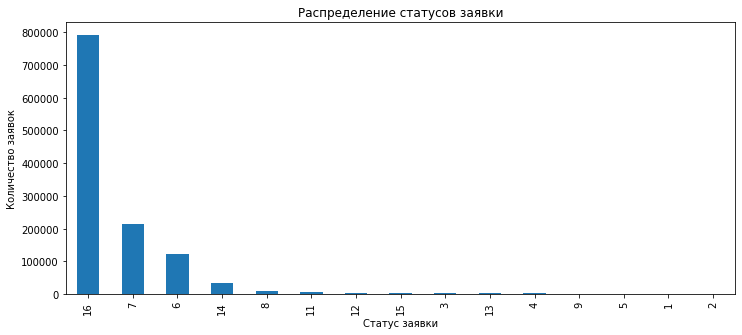

In [49]:
orders['status_id'].value_counts().plot(kind='bar', figsize=(12,5))
plt.title('Распределение статусов заявки')
plt.xlabel('Статус заявки')
plt.ylabel('Количество заявок')
plt.show();

Можно заметить, что большее число заявок сняты (16 и 7), оплаченых же заявок гораздо меньше (6 и 14). Заявок со статусами 9, 5, 1, 2 практически не наблюдается. 

Теперь посмотрим, как распределяются цены на занятия

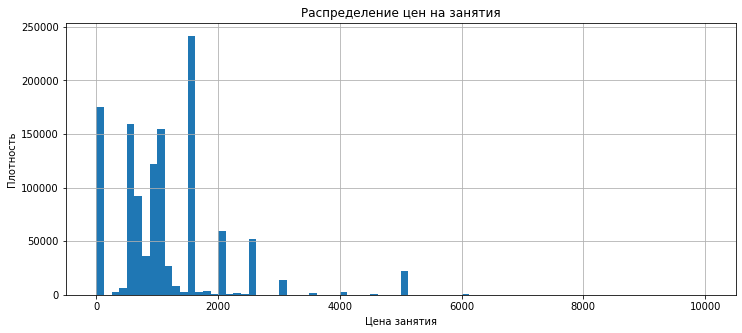

In [50]:
orders['lesson_price'].hist(bins=80, figsize=(12,5))
plt.title('Распределение цен на занятия')
plt.xlabel('Цена занятия')
plt.ylabel('Плотность')
plt.show();

Из графика можно заметить, что цены на занятия распределены неравномерно, однако больше всего заявок с ценой, равной ~1800. У многих заявок цена не указана (значения около 0)

Посмотрим, для скольких заявок нет подходящих репетиторов

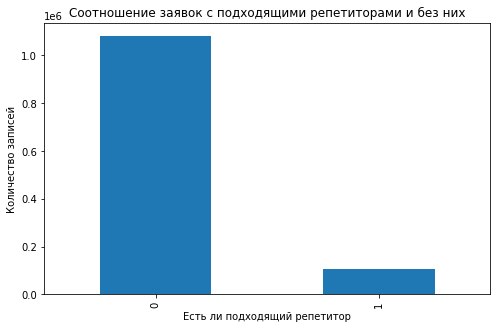

In [51]:
orders['no_teachers_available'].value_counts().plot(kind='bar', figsize=(8,5))
plt.title('Соотношение заявок с подходящими репетиторами и без них')
plt.xlabel('Есть ли подходящий репетитор')
plt.ylabel('Количество записей')
plt.show();

Можно заметить, что заявок без подходящего репетитора почти в 10 раз превышает количество заявок, для которых есть подходящий репетитор.

Посмотрим на возрастной размах студентов

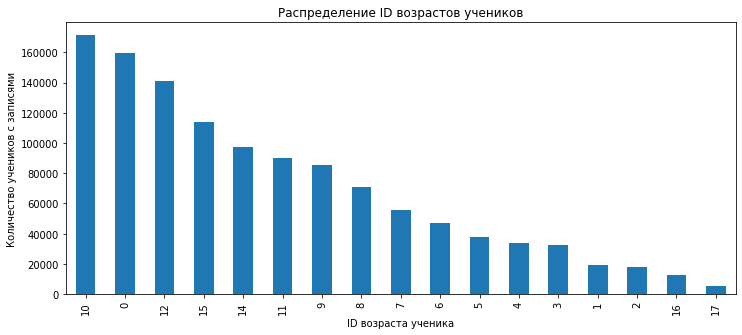

In [52]:
orders['pupil_category_new_id'].value_counts().plot(kind='bar', figsize=(12,5))
plt.title('Распределение ID возрастов учеников')
plt.xlabel('ID возраста ученика')
plt.ylabel('Количество учеников с записями')
plt.show();

Больше всего учеников с возрастным id, равным 10. Однако очень много id клиентов не заполнены (id=0), меньше всего учеников с 17ым возрастным id.

#### 3.1.4 Корреляционный анализ

In [53]:
corr_orders = orders.select_dtypes(include='number').corr()

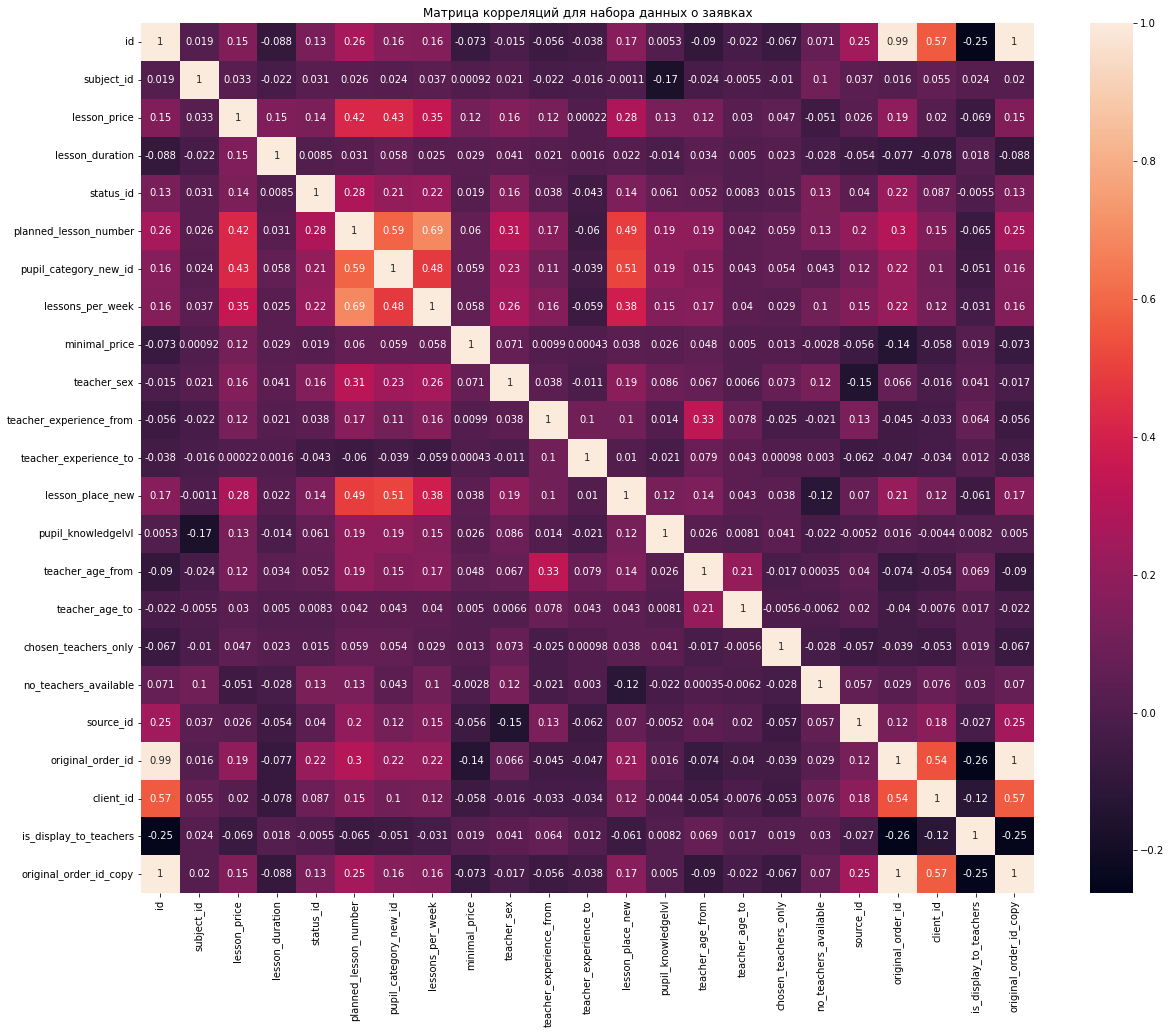

In [54]:
# Построим heatmap для матрицы корреляций всех численных признаков
plt.figure(figsize=(20,16))
sns.heatmap(corr_orders, annot=True)
plt.title('Матрица корреляций для набора данных о заявках')
plt.show();

**Вывод:** в наборе данных о заявках есть только одна пара признаков с корреляцией, большей 0.6 - estimated_fee и lesson_price. Остальные признаки же не обладают высокой корреляцией. (Высокую корреляцию имеют столбцы, которые обозначают id: id, original_order_id, original_order_id_copy). Не будем удалять никакие из них для дальнейшего анализа.

### 3.2 Данные о репетиторах

#### 3.2.1 Обработка аномалий и выбросов

In [55]:
teachers_info.head()

id  user_id  rating_id  is_pupils_needed  effective_rating  \
0  33       45         15               1.0          4.679688   
1  46       63          4               1.0          0.000000   
2  51       68         16               1.0          6.000000   
3  52       69         16               0.0         11.289062   
4  54       70          4               1.0         -5.000000   

   rating_for_users  rating_for_admin  orders_allowed  star_rating  \
0            1138.0             237.5               0     4.500000   
1              25.0               0.0               1     4.300781   
2             300.0               0.0               1     4.300781   
3             135.0               0.0               1     5.000000   
4              50.0               0.0               1     4.300781   

   rating_for_users_yesterday  review_num  
0                      1138.0           6  
1                        25.0           0  
2                       300.0           0  
3                       135.0           2  
4                        50.0           0

Во всех данных о рейтинге (кроме star_rating) имеются аномальные значения, однако удалять мы их не будем, так как нет четкого понимания пограничных значений для кадого типа рейтинга. 

#### 3.2.3 Визуализация

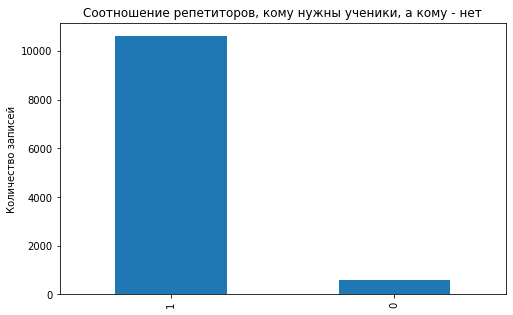

In [60]:
teachers_info[teachers_info['is_pupils_needed']!=-1]['is_pupils_needed'].value_counts().plot(kind='bar', figsize=(8,5))
plt.title('Соотношение репетиторов, кому нужны ученики, а кому - нет')
plt.xlabel('')
plt.ylabel('Количество записей')
plt.show();

Учителей, которым нужны ученики, больше чем учителей, которые не ведут набор учеников, больше в 18 раз.

Посмотрим, как распределяется признак 'star_rating'

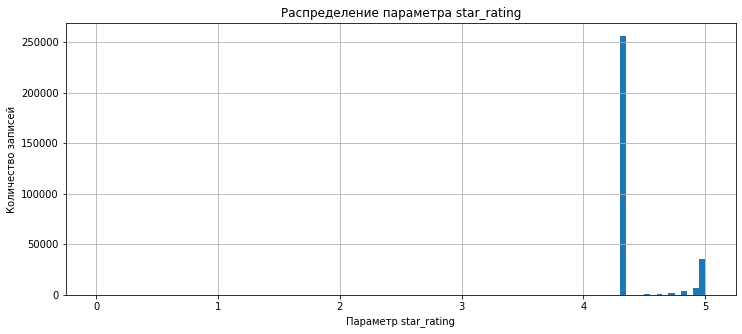

In [61]:
teachers_info['star_rating'].hist(bins=100, figsize=(12,5))
plt.title('Распределение параметра star_rating')
plt.xlabel('Параметр star_rating')
plt.ylabel('Количество записей')
plt.show();

Можно заметить, что большинство записей имеют рейтинг 4.3. Сам же рейтинг распределяется от 0 до 5.

Посмотрим, как распределяется параметр rating_for_users

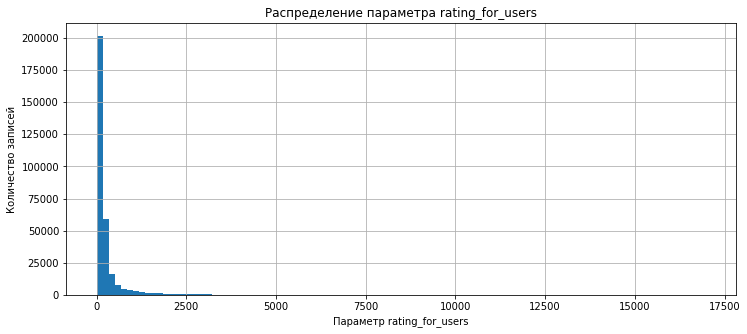

In [62]:
teachers_info['rating_for_users'].hist(bins=100, figsize=(12,5))
plt.title('Распределение параметра rating_for_users')
plt.xlabel('Параметр rating_for_users')
plt.ylabel('Количество записей')
plt.show()

В основном параметр 'rating_for_users' распределен около 0 - 300. Однако имеются и значения-выбросы, но удалять их не будем.

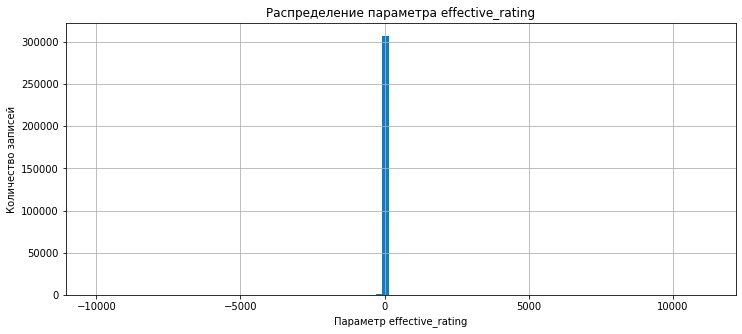

In [63]:
teachers_info['effective_rating'].hist(bins=100, figsize=(12,5))
plt.title('Распределение параметра effective_rating')
plt.xlabel('Параметр effective_rating')
plt.ylabel('Количество записей')
plt.show()

Рейтинг 'effective_rating' так же имеет аномальные значения, но в основном этот рейтинг близится к 0.

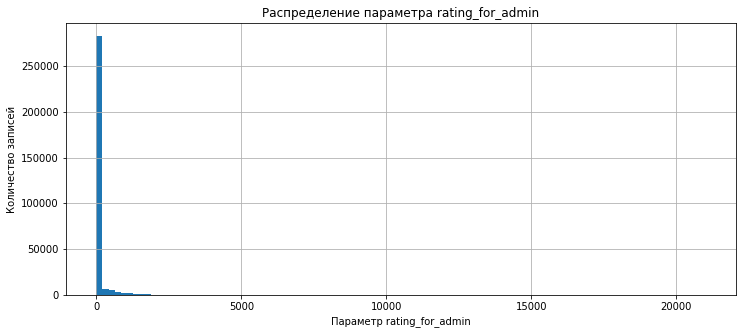

In [64]:
teachers_info['rating_for_admin'].hist(bins=100, figsize=(12,5))
plt.title('Распределение параметра rating_for_admin')
plt.xlabel('Параметр rating_for_admin')
plt.ylabel('Количество записей')
plt.show()

Можно заметить, что рейтинг 'rating_for_users' так же имеет аномальные значения, но в основном этот рейтинг сосредоточен около значений, близких к 0. 

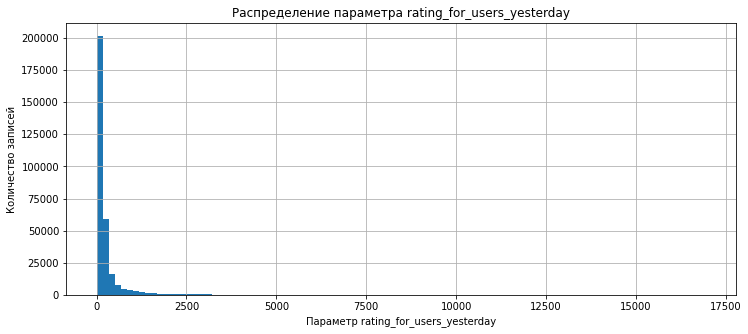

In [65]:
teachers_info['rating_for_users_yesterday'].hist(bins=100, figsize=(12,5))
plt.title('Распределение параметра rating_for_users_yesterday')
plt.xlabel('Параметр rating_for_users_yesterday')
plt.ylabel('Количество записей')
plt.show()

Аналогично предыдущим параметрам, параметр rating_for_users_yesterday содержит аномальные значения, больше всего записей имеют значения данного параметра, близкие к 0 - 100.

#### 3.2.4 Корреляционный анализ

In [66]:
corr_teachers = teachers_info.select_dtypes(include='number').corr()

In [67]:
corr_teachers

id   user_id  rating_id  is_pupils_needed  \
id                          1.000000  0.975202   0.006843         -0.323884   
user_id                     0.975202  1.000000  -0.026629         -0.230645   
rating_id                   0.006843 -0.026629   1.000000         -0.057247   
is_pupils_needed           -0.323884 -0.230645  -0.057247          1.000000   
effective_rating           -0.008901 -0.007226   0.000065          0.008642   
rating_for_users            0.055225  0.048318   0.323449         -0.018015   
rating_for_admin           -0.041398 -0.045675   0.184526          0.012009   
orders_allowed             -0.286026 -0.302857   0.203769          0.046690   
star_rating                -0.184806 -0.188736   0.236304          0.034813   
rating_for_users_yesterday  0.054679  0.047789   0.323093         -0.017472   
review_num                 -0.151378 -0.146906   0.172134          0.048789   

                            effective_rating  rating_for_users  \
id                                 -0.008901          0.055225   
user_id                            -0.007226          0.048318   
rating_id                           0.000065          0.323449   
is_pupils_needed                    0.008642         -0.018015   
effective_rating                    1.000000          0.017654   
rating_for_users                    0.017654          1.000000   
rating_for_admin                    0.015435          0.774439   
orders_allowed                      0.013331          0.068749   
star_rating                         0.018626          0.452546   
rating_for_users_yesterday          0.017895          0.998431   
review_num                          0.036045          0.502748   

                            rating_for_admin  orders_allowed  star_rating  \
id                                 -0.041398       -0.286026    -0.184806   
user_id                            -0.045675       -0.302857    -0.188736   
rating_id                           0.184526        0.203769     0.236304   
is_pupils_needed                    0.012009        0.046690     0.034813   
effective_rating                    0.015435        0.013331     0.018626   
rating_for_users                    0.774439        0.068749     0.452546   
rating_for_admin                    1.000000        0.026659     0.404935   
orders_allowed                      0.026659        1.000000     0.025319   
star_rating                         0.404935        0.025319     1.000000   
rating_for_users_yesterday          0.773998        0.068533     0.452239   
review_num                          0.386641        0.010800     0.431253   

                            rating_for_users_yesterday  review_num  
id                                            0.054679   -0.151378  
user_id                                       0.047789   -0.146906  
rating_id                                     0.323093    0.172134  
is_pupils_needed                             -0.017472    0.048789  
effective_rating                              0.017895    0.036045  
rating_for_users                              0.998431    0.502748  
rating_for_admin                              0.773998    0.386641  
orders_allowed                                0.068533    0.010800  
star_rating                                   0.452239    0.431253  
rating_for_users_yesterday                    1.000000    0.502369  
review_num                                    0.502369    1.000000

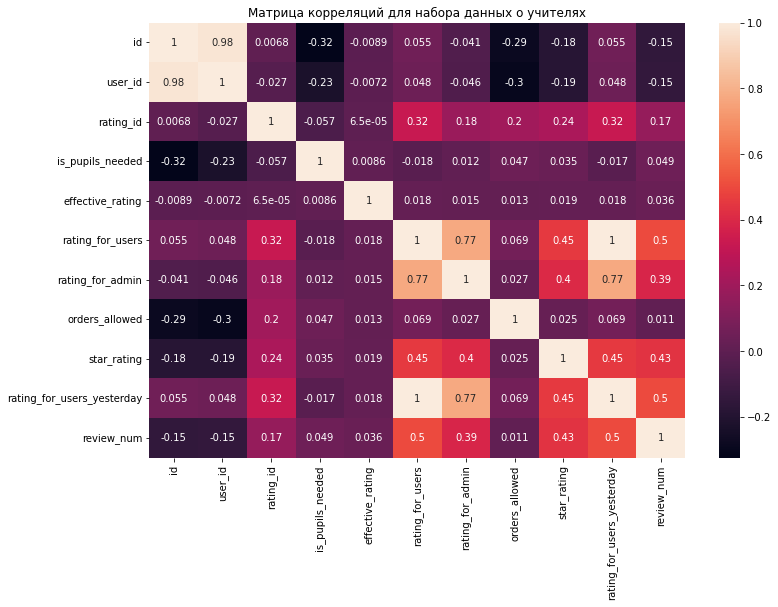

In [68]:
# Построим heatmap для матрицы корреляций всех численных признаков
plt.figure(figsize=(12,8))
sns.heatmap(corr_teachers, annot=True)
plt.title('Матрица корреляций для набора данных о учителях')
plt.show();

**Вывод:** в наборе данных о учителях высокой корреляцией обладают пары параметров: id и user_id, rating_for_admin и rating_for_users, rating_for_users и rating_for_users_yesterday.

### 3.3 Данные о желаемых репетиторах

В наборе данных о желаемых репетиторах отсутсвуют аномалии, выбросы и пропуски, так как он состоит всего из двух колонок, где содержатся только id заявок и репетиторов. Для этого набора данных не будем проводить корреляционный анализ, так как это не имеет смысла, не будем строить графики.

Посмотрим на 5 репетиторов, которые чаще всего встречаются в этом наборе данных:

In [69]:
prefered_teachers['teacher_id'].value_counts().head(5)

teacher_id
151958    2507
40245     1429
137256    1232
158814    1226
100205    1032
Name: count, dtype: int64

### 3.4 Данные о подходящих по фильтру репетиторах

#### 3.4.1 Обработка аномалий и выбросов

In [70]:
suitable_teachers.head()

teacher_id  order_id                                     contact_result  \
0       82583   1742711                               Репетитор согласился   
1      125057   1742713  Репетитор положил трубку, либо обрыв связи (Ok...   
2      231211   1742713  Репетитор положил трубку, либо обрыв связи (Ok...   
3      128773   1742713  Репетитор положил трубку, либо обрыв связи (Ok...   
4       63019   1742713                               Репетитор согласился   

   enable_auto_assign  enable_assign  
0                   1              1  
1                   0              0  
2                   0              0  
3                   0              0  
4                   0              1

Данные готовы к дальнейшему анализу

#### 3.4.3 Визуализация

Посмотрим сколько репетиторов доступны для работы (могут назначаться как сами, так и через консультанта)

In [72]:
# Посмотрим сколько репетиторов доступны для работы (могут назначаться как сами, так и через консультанта)
fully_available = suitable_teachers[(suitable_teachers['enable_auto_assign'] == 1) & (suitable_teachers['enable_assign'] == 1)]['order_id'].count()

# Посмотрим, сколько репетиторов забоокированы (не могут назначаться ни сами, ни через консультанта)
blocked = suitable_teachers[(suitable_teachers['enable_auto_assign'] == 0) & (suitable_teachers['enable_assign'] == 0)]['order_id'].count()

# Посмотрим, сколько репетиторов могут назначаться сами
auto_assign_enabled = suitable_teachers[(suitable_teachers['enable_auto_assign'] == 1) & (suitable_teachers['enable_assign'] == 0)]['order_id'].count()

# Посмотрим, сколько репетиторов могут назначаться через консультата
auto_assign_disabled = suitable_teachers[(suitable_teachers['enable_auto_assign'] == 0) & (suitable_teachers['enable_assign'] == 1)]['order_id'].count()


In [73]:
print(fully_available, blocked, auto_assign_enabled, auto_assign_disabled)

217636 17313166 2399537 340798


Построим график

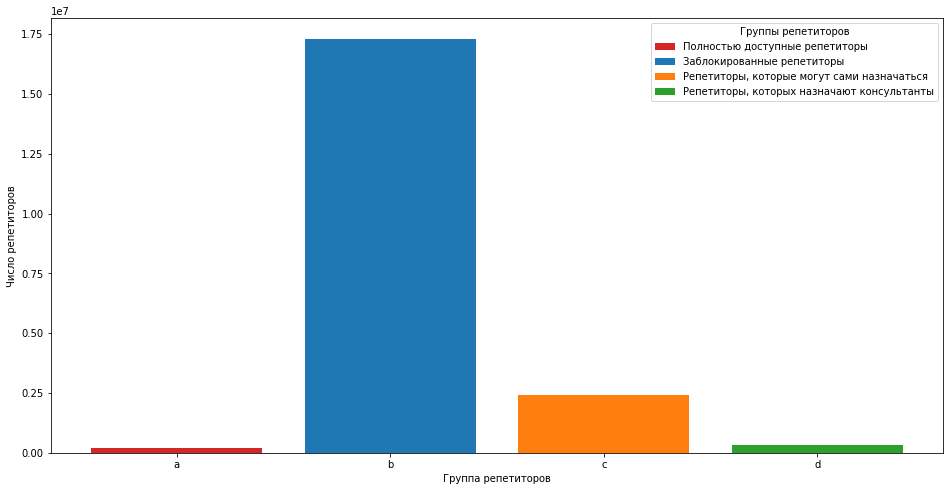

In [74]:
y = [217636, 17313166, 2399537, 340798]
x =['a', 'b', 'c', 'd']
bar_labels = 'Полностью доступные репетиторы', 'Заблокированные репетиторы', 'Репетиторы, которые могут сами назначаться', 'Репетиторы, которых назначают консультанты'
bar_colors = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green']
plt.figure(figsize=(16,8))
plt.bar(x, y, label=bar_labels, color=bar_colors)
plt.legend(title='Группы репетиторов', loc='upper right')
plt.title('')
plt.xlabel('Группа репетиторов')
plt.ylabel('Число репетиторов')
plt.show();

Больше всего репетиторов являются заблокированными; репетиторов, которые могут назначаться сами больше, чем репетиторов, которых могут назначать только консультанты.

#### 3.4.4 Корреляционный анализ

In [75]:
corr_suitable_teachers = suitable_teachers.select_dtypes('number').corr()

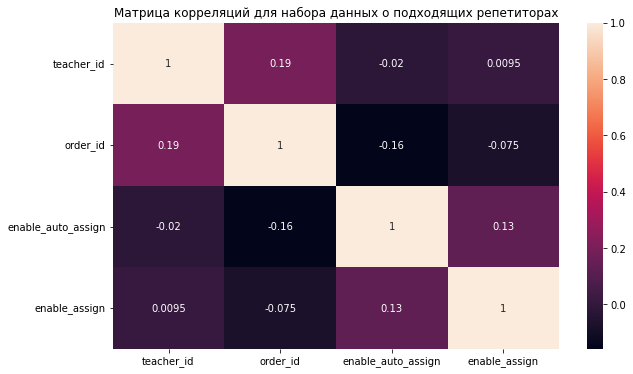

In [76]:
# Построим heatmap для матрицы корреляций всех численных признаков
plt.figure(figsize=(10,6))
sns.heatmap(corr_suitable_teachers, annot=True)
plt.title('Матрица корреляций для набора данных о подходящих репетиторах')
plt.show();

В данном наборе данных нет признаков, которые высоко коррелируют между собой.

## 4. Разработка новых признаков

### 4.1 Объединение таблиц

Перед разработкой новыйх признаков объединим таблицы: сначала таблицы suitable_teachers и teachers_info, а затем добавим к таблице orders объединенную до этого таблицу. Удалим лишние колонки, которые дублируют id учителей и id заявки

Объединение таблиц suitable_teachers и teachers_info

In [77]:
suitable_teachers = suitable_teachers.merge(teachers_info, left_on='teacher_id', right_on='id', how='left')

In [78]:
suitable_teachers = suitable_teachers.drop(columns=['id'])

In [79]:
suitable_teachers.head()

teacher_id  order_id  enable_auto_assign  enable_assign   user_id  \
0       82583   1742711                   1              1   83886.0   
1      125057   1742713                   0              0  264033.0   
2      231211   1742713                   0              0  800217.0   
3      128773   1742713                   0              0  279153.0   
4       63019   1742713                   0              1   64194.0   

   rating_id  is_pupils_needed  effective_rating  rating_for_users  \
0       15.0              -1.0               0.0             150.0   
1       15.0              -1.0               0.0             330.0   
2       15.0              -1.0               0.0             200.0   
3       15.0              -1.0               0.0               0.0   
4       17.0              -1.0               9.0            1001.5   

   rating_for_admin  orders_allowed  star_rating  rating_for_users_yesterday  \
0              0.00             1.0     4.300781                       150.0   
1              0.00             1.0     4.300781                       330.0   
2              0.00             0.0     4.300781                       200.0   
3              0.00             1.0     4.300781                         0.0   
4            321.75             1.0     5.000000                      1001.5   

   review_num  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         4.0

Сгруппируем полученную таблицу по order_id и медианным значениям численных признаков:

In [80]:
suitable_teachers = suitable_teachers.groupby('order_id').median()

In [81]:
suitable_teachers.reset_index(inplace=True)

In [82]:
suitable_teachers.head()

order_id  teacher_id  enable_auto_assign  enable_assign   user_id  \
0   1742638    170358.0                 1.0            0.0  512607.0   
1   1742639    201226.0                 1.0            1.0  660367.0   
2   1742650    206142.0                 1.0            0.0  677374.0   
3   1742651    126753.0                 1.0            0.0  269714.0   
4   1742654     97956.0                 1.0            0.0  169210.0   

   rating_id  is_pupils_needed  effective_rating  rating_for_users  \
0       16.0              -1.0               0.0            833.00   
1       16.0              -1.0               0.0            805.50   
2       15.0              -1.0               0.0            590.50   
3       16.0              -1.0               0.0           1260.00   
4        9.0              -1.0               0.0            571.25   

   rating_for_admin  orders_allowed  star_rating  rating_for_users_yesterday  \
0            466.75             1.0     4.800781                      833.00   
1            614.00             1.0     4.898438                      805.50   
2            414.00             1.0     5.000000                      590.50   
3           1809.00             1.0     5.000000                     1260.00   
4            120.75             1.0     4.949219                      571.25   

   review_num  
0         2.0  
1         6.0  
2         2.0  
3        11.0  
4         5.5

Объединение таблиц orders и suitable_teachers

In [83]:
orders = orders.merge(suitable_teachers, how='left', left_on='id', right_on='order_id')

Заполним пропуски нулями (так как в данном случае, для заявки не было найдено подходящего преподавателя):

In [87]:
orders['teacher_id'] = orders['teacher_id'].fillna(0)
orders['enable_auto_assign'] = orders['enable_auto_assign'].fillna(0)
orders['enable_assign'] = orders['enable_assign'].fillna(0)
orders['rating_id'] = orders['rating_id'].fillna(0)
orders['is_pupils_needed'] = orders['is_pupils_needed'].fillna(-2)
orders['effective_rating'] = orders['effective_rating'].fillna(0)
orders['rating_for_users'] = orders['rating_for_users'].fillna(0)
orders['rating_for_admin'] = orders['rating_for_admin'].fillna(0)
orders['orders_allowed'] = orders['orders_allowed'].fillna(-1)
orders['star_rating'] = orders['star_rating'].fillna(0)
orders['rating_for_users_yesterday'] = orders['rating_for_users_yesterday'].fillna(0)
orders['review_num'] = orders['review_num'].fillna(0)

### 4.2 Генерация новых признаков

Создадим новый признак - порядковый номер дубля

In [88]:
orders_copy = orders.sort_values(by='order_date')
orders['double_serial_number'] = orders_copy.groupby('original_order_id').cumcount() + 1

In [89]:
# Заполним пропуски в созданной колонке 0:
orders['double_serial_number'] = orders['double_serial_number'].fillna(0)

Ограничим число копий на заявку 30. 

In [90]:
orders = orders[orders['double_serial_number'] <= 10]

Cоздадим новый признак - номер заявки для клиента

In [91]:
orders_copy = orders.sort_values(by='order_date')
orders['order_serial_number'] = orders_copy.groupby('client_id').cumcount() + 1

Оставим клиентов, у которых количество заявок меньше 100:

In [92]:
orders = orders[orders['order_serial_number'] <= 50]

Создадим новые признаки - год, месяц и день оставления заявки:

In [93]:
orders['year'] = orders['order_date'].dt.year

In [94]:
orders['month'] = orders['order_date'].dt.month

In [95]:
orders['day'] = orders['order_date'].dt.day

In [96]:
orders = orders.drop(columns=['order_date'])

## 5. Отбор финального набора обучающих признаков

### 5.1 Преобразование типов данных и заполнение пропусков

Посмотрим на типы данных, которые хранятся в столбцах, приведем необходимые столбцы к типу данных 'category':

In [97]:
orders.dtypes

id                              int32
subject_id                      int64
purpose                        object
lesson_price                    int32
lesson_duration                 int32
status_id                       int32
planned_lesson_number           int32
pupil_category_new_id           int64
lessons_per_week                int32
minimal_price                   int32
teacher_sex                     int32
teacher_experience_from         int32
teacher_experience_to           int32
lesson_place_new                int32
pupil_knowledgelvl              int32
teacher_age_from                int32
teacher_age_to                  int32
chosen_teachers_only             int8
no_teachers_available            int8
source_id                       int32
original_order_id             float32
client_id                       int32
is_display_to_teachers           int8
original_order_id_copy          int64
order_id                      float64
teacher_id                    float64
enable_auto_

### 5.2 Целевой признак

Сгенерируем целевой признак - факт оплаты заявки: если status_id хотя бы в одном значении группы (оригинальная заявка, ее дубли) равен 5, 6, 13, 15, то все заявки этой группы считаются оплаченными:

In [99]:
orders['paid'] = orders.groupby('original_order_id_copy')['status_id'].transform(lambda x: 1 if any(status in x.values for status in [5, 6, 13, 15]) else 0)

In [100]:
#Удалим колонку status_id, так как может произойти утечка целевого признака
orders = orders.drop(columns='status_id')

### 5.3 Ручной отбор признаков

Удалим колонки 'original_order_id' и 'original_order_id_copy', так как они не понадобятся для дальнейшего анализа

In [101]:
orders = orders.drop(columns=['original_order_id', 'original_order_id_copy'])

In [102]:
orders = orders.drop(columns=['order_id', 'user_id', 'client_id',])

### 5.4 Корреляционный анализ

In [103]:
corr = orders.select_dtypes('number').corr()

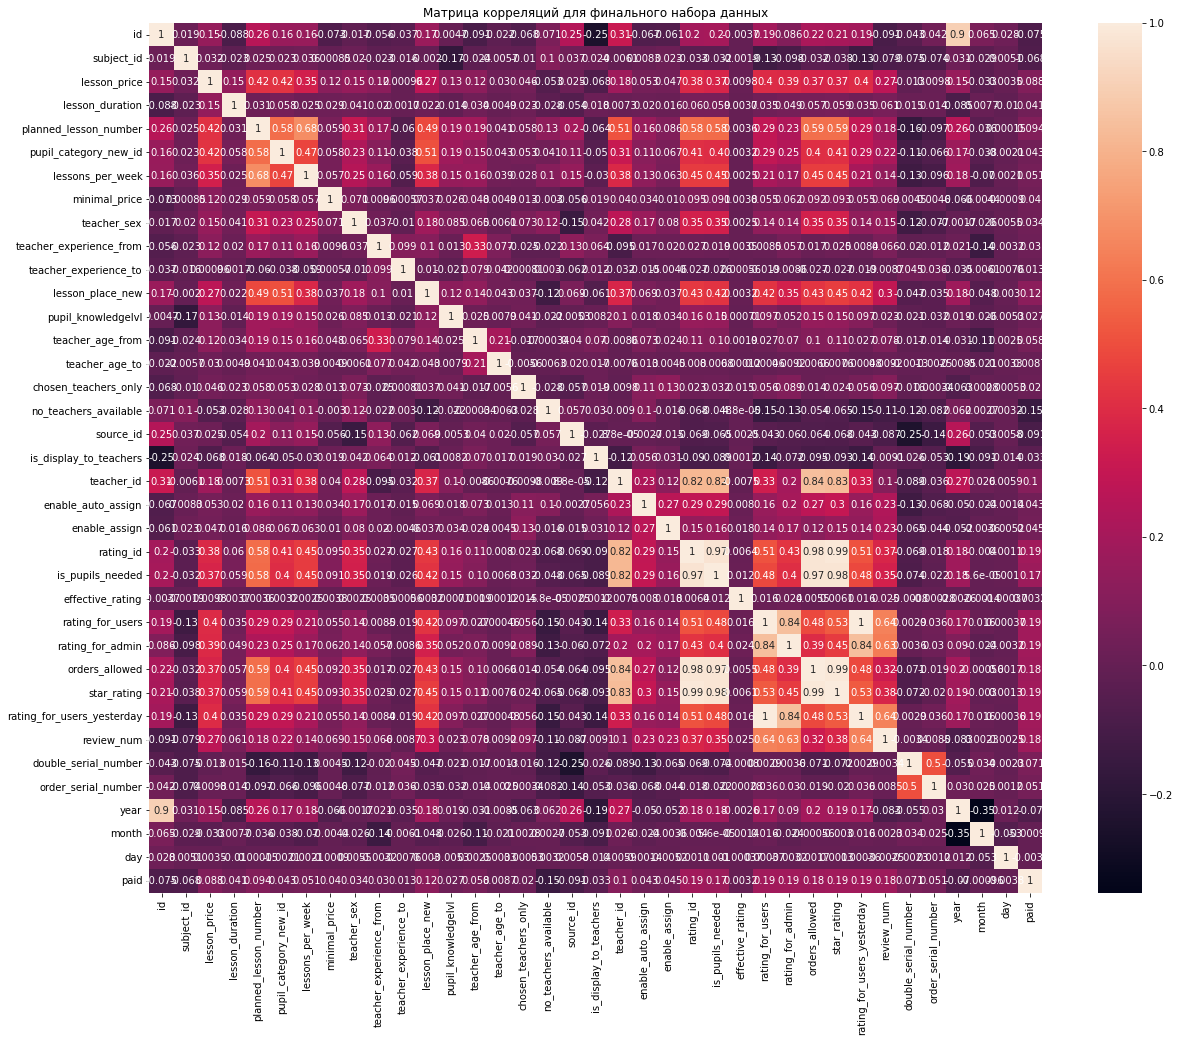

In [104]:
# Построим heatmap для матрицы корреляций всех численных признаков
plt.figure(figsize=(20,16))
sns.heatmap(corr, annot=True)
plt.title('Матрица корреляций для финального набора данных')
plt.show();

Можно заметить, что высоким коэффициентом корреляции обладают следующие пары признаков: rating_for_admin и rating_for_users (0.81), rating_for_admin и rating_for_users_yesterday (0.81), planned_lesson_number и lessons_per_week (0.69). 

### 5.5 TF-IDF

Для лучшей работы модели добавим текстовые признаки: для начала лемматизируем столбец 'purpose' (из набора данных о заявках), затем для лемматизированного столбца посчитаем значения TF-IDF, добавим к финальному набору данных.

In [105]:
lemmatizer = WordNetLemmatizer()

In [106]:
stop_words = set(stopwords.words('russian'))

In [107]:
def lemmatize(text):
    text = re.sub(r'[^а-яА-Я]', ' ', text)
    text = text.lower()
    token = nltk.word_tokenize(text)
    text = [word for word in token if word not in stop_words]
    text = [lemmatizer.lemmatize(word) for word in text]
    text = ' '.join(text)
    return text

In [108]:
orders['purpose'] = orders['purpose'].fillna('-')
orders['purpose'] = orders['purpose'].str.replace('Разделы:', ' ')
orders['purpose'] = orders['purpose'].str.replace('Категория ученика:', ' ')
orders['purpose'] = orders['purpose'].str.replace('Цель занятий:', ' ')

In [109]:
orders['purpose_lemmatized'] = orders['purpose'].apply(lemmatize)

Перед тем как посчитать TF-IDF, преведем некоторые формы слова к единому стандарту:

In [110]:
orders['purpose_lemmatized'] = orders['purpose_lemmatized'].str.replace('студентка', 'студент')
orders['purpose_lemmatized'] = orders['purpose_lemmatized'].str.replace('студента', 'студент')
orders['purpose_lemmatized'] = orders['purpose_lemmatized'].str.replace('студенты', 'студент')
orders['purpose_lemmatized'] = orders['purpose_lemmatized'].str.replace('абитуриентка', 'абитуриент')
orders['purpose_lemmatized'] = orders['purpose_lemmatized'].str.replace('ученица', 'ученик')
orders['purpose_lemmatized'] = orders['purpose_lemmatized'].str.replace('ученика', 'ученик')
orders['purpose_lemmatized'] = orders['purpose_lemmatized'].str.replace('ученицы', 'ученик')
orders['purpose_lemmatized'] = orders['purpose_lemmatized'].str.replace('школьница', 'школьник')
orders['purpose_lemmatized'] = orders['purpose_lemmatized'].str.replace('школьной', 'школьник')
orders['purpose_lemmatized'] = orders['purpose_lemmatized'].str.replace('школьный', 'школьник')
orders['purpose_lemmatized'] = orders['purpose_lemmatized'].str.replace('экзамена', 'экзамен')
orders['purpose_lemmatized'] = orders['purpose_lemmatized'].str.replace('экзамену', 'экзамен')
orders['purpose_lemmatized'] = orders['purpose_lemmatized'].str.replace('экзамене', 'экзамен')
orders['purpose_lemmatized'] = orders['purpose_lemmatized'].str.replace('математике', 'математика')
orders['purpose_lemmatized'] = orders['purpose_lemmatized'].str.replace('гиа', 'огэ')
orders['purpose_lemmatized'] = orders['purpose_lemmatized'].str.replace('текущая', 'текущий')
orders['purpose_lemmatized'] = orders['purpose_lemmatized'].str.replace('первокурсница', 'первокурсник')
orders['purpose_lemmatized'] = orders['purpose_lemmatized'].str.replace('второкурсница', 'второкурсник')
orders['purpose_lemmatized'] = orders['purpose_lemmatized'].str.replace('выпускница', 'выпускник')
orders['purpose_lemmatized'] = orders['purpose_lemmatized'].str.replace('первоклассница', 'первоклассник')
orders['purpose_lemmatized'] = orders['purpose_lemmatized'].str.replace('девушка', 'женщина')
orders['purpose_lemmatized'] = orders['purpose_lemmatized'].str.replace('языка', 'язык')

In [111]:
orders.reset_index(drop=True, inplace=True)

Инициализируем TfidfVectorizer:

In [112]:
count_tf_idf_purpose = TfidfVectorizer(min_df=200, stop_words=stop_words, max_features=100)
count_tf_idf_purpose.fit(orders['purpose_lemmatized'])

TfidfVectorizer(max_features=100, min_df=200,
                stop_words={'а', 'без', 'более', 'больше', 'будет', 'будто',
                            'бы', 'был', 'была', 'были', 'было', 'быть', 'в',
                            'вам', 'вас', 'вдруг', 'ведь', 'во', 'вот',
                            'впрочем', 'все', 'всегда', 'всего', 'всех', 'всю',
                            'вы', 'где', 'да', 'даже', 'два', ...})

Посчитаем метрику TF-IDF по батчам:

In [113]:
def process_in_batches(dataframe, vectorizer, batch_size=100):
    transformed_batches = []
    n_batches = (dataframe.shape[0] // batch_size) + (0 if dataframe.shape[0] % batch_size == 0 else 1)
    
    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size
        batch = dataframe.iloc[start:end]
        
        if not batch.empty:
            tf_idf_batch = vectorizer.transform(batch['purpose_lemmatized'])
            tfidf_df_batch = pd.DataFrame(tf_idf_batch.toarray(), columns=vectorizer.get_feature_names_out())
            transformed_batches.append(tfidf_df_batch)
    
    transformed_df = pd.concat(transformed_batches, ignore_index=True)
    
    return transformed_df

In [114]:
tfidf_df_purpose = process_in_batches(orders, count_tf_idf_purpose, batch_size=100)

Добавим метрику к набору данных (так же по батчам):

In [115]:
def concat_in_batches(orders_df, tfidf_df, batch_size):
    assert len(orders_df) == len(tfidf_df), "DataFrames must have the same number of rows"
    
    # Calculate the number of batches
    n_batches = len(orders_df) // batch_size + (1 if len(orders_df) % batch_size else 0)
    
    # Initialize an empty list to store concatenated batches
    concatenated_batches = []
    
    for batch_num in range(n_batches):
        start_idx = batch_num * batch_size
        end_idx = start_idx + batch_size
        
        # Slice both DataFrames for the current batch
        orders_batch = orders_df.iloc[start_idx:end_idx]
        tfidf_batch = tfidf_df.iloc[start_idx:end_idx]
        
        # Concatenate the current batch horizontally
        concatenated_batch = pd.concat([orders_batch.reset_index(drop=True), tfidf_batch.reset_index(drop=True)], axis=1)
        
        # Append the concatenated batch to the list
        concatenated_batches.append(concatenated_batch)
    
    # Concatenate all batches vertically to form the final DataFrame
    final_df = pd.concat(concatenated_batches, ignore_index=True)
    
    return final_df

In [116]:
data_final = concat_in_batches(orders, tfidf_df_purpose, batch_size=1000)

## 6. Выбор и обучение модели

Определим target и features для построения модели

In [117]:
# Удалим ненужные колонки:
data_final = data_final.drop(columns=['purpose', 'id', 'purpose_lemmatized', 'teacher_id'])

In [118]:
orders = orders.drop(columns=['purpose', 'id', 'purpose_lemmatized', 'teacher_id'])

In [119]:
orders.columns

Index(['subject_id', 'lesson_price', 'lesson_duration',
       'planned_lesson_number', 'pupil_category_new_id', 'lessons_per_week',
       'minimal_price', 'teacher_sex', 'teacher_experience_from',
       'teacher_experience_to', 'lesson_place_new', 'pupil_knowledgelvl',
       'teacher_age_from', 'teacher_age_to', 'chosen_teachers_only',
       'no_teachers_available', 'source_id', 'is_display_to_teachers',
       'enable_auto_assign', 'enable_assign', 'rating_id', 'is_pupils_needed',
       'effective_rating', 'rating_for_users', 'rating_for_admin',
       'orders_allowed', 'star_rating', 'rating_for_users_yesterday',
       'review_num', 'double_serial_number', 'order_serial_number', 'year',
       'month', 'day', 'paid'],
      dtype='object')

In [120]:
state = np.random.RandomState(12345)

In [121]:
target = data_final['paid']
features = data_final.drop(columns='paid')

Разделим данные на обучающую и тестовую выборки:

In [122]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, stratify = target, random_state=state)

Построим пайплайн машинного обучения для классификации заявок:

In [123]:
cat_features = ['pupil_category_new_id', 'teacher_sex', 'lesson_place_new', 'pupil_knowledgelvl', 'is_pupils_needed', 'orders_allowed']  
numeric_features = orders.select_dtypes('number').drop(columns=cat_features)
numeric_features = numeric_features.drop(columns=['paid']).columns

In [124]:
numeric_features

Index(['subject_id', 'lesson_price', 'lesson_duration',
       'planned_lesson_number', 'lessons_per_week', 'minimal_price',
       'teacher_experience_from', 'teacher_experience_to', 'teacher_age_from',
       'teacher_age_to', 'chosen_teachers_only', 'no_teachers_available',
       'source_id', 'is_display_to_teachers', 'enable_auto_assign',
       'enable_assign', 'rating_id', 'effective_rating', 'rating_for_users',
       'rating_for_admin', 'star_rating', 'rating_for_users_yesterday',
       'review_num', 'double_serial_number', 'order_serial_number', 'year',
       'month', 'day'],
      dtype='object')

In [125]:
num_pipeline = make_imblearn_pipeline(StandardScaler(), DropCorrelatedFeatures(threshold=0.9))
column_transformer = make_column_transformer((num_pipeline, numeric_features),
                                             (OrdinalEncoder(), cat_features),
                                             remainder='passthrough')

In [126]:
pipeline = make_imblearn_pipeline(column_transformer,                     
                         CatBoostClassifier()) 

In [127]:
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('dropcorrelatedfeatures',
                                                                   DropCorrelatedFeatures(threshold=0.9))]),
                                                  Index(['subject_id', 'lesson_price', 'lesson_duration',
       'planned_lesson_number', 'lessons_per_week', 'minimal_price',
       'teacher_exper...
       'rating_for_admin', 'star_rating', 'rating_for_users_yesterday',
       'review_num', 'double_serial_number', 'order_serial_number', 'year',
       'month', 'day'],
      dtype='object')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['pupil_category_new_id',
                                                   'teacher_sex',
                                                   'lesson_place_new',
                                                   'pupil_knowledgelvl',
                                                   'is_pupils_needed',
                                                   'orders_allowed'])])),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7f94449fcf40>)])

In [128]:
pipeline.steps[-1] = ('clf', pipeline.steps[-1][1])

In [129]:
pipeline.named_steps

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('pipeline',
                                  Pipeline(steps=[('standardscaler',
                                                   StandardScaler()),
                                                  ('dropcorrelatedfeatures',
                                                   DropCorrelatedFeatures(threshold=0.9))]),
                                  Index(['subject_id', 'lesson_price', 'lesson_duration',
        'planned_lesson_number', 'lessons_per_week', 'minimal_price',
        'teacher_experience_from', 'teacher_experience_to', '...
        'enable_assign', 'rating_id', 'effective_rating', 'rating_for_users',
        'rating_for_admin', 'star_rating', 'rating_for_users_yesterday',
        'review_num', 'double_serial_number', 'order_serial_number', 'year',
        'month', 'day'],
       dtype='object')),
                                 ('ordinalencoder', OrdinalEncoder(),
       

In [130]:
params = [{
    'clf': [CatBoostClassifier(auto_class_weights='Balanced', loss_function='Logloss')],
    'clf__iterations': [1000],
    'clf__learning_rate': [0.1, 0.05],
    'clf__depth': [6, 8, 10],
    'columntransformer__pipeline__dropcorrelatedfeatures__threshold': [0.8, 0.9],
    }]

grid = RandomizedSearchCV(pipeline,
                    params,
                    n_iter=30,
                    cv=3,
                    verbose=5,
                    random_state=state,
                    scoring='f1',
                    n_jobs=-1)

In [131]:
%%time
grid.fit(features_train, target_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Users/olesyakolpakova/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 12 is smaller than n_iter=30. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0:	learn: 0.6760718	total: 1.24s	remaining: 20m 43s
1:	learn: 0.6622435	total: 2.13s	remaining: 17m 42s
2:	learn: 0.6519387	total: 3.09s	remaining: 17m 8s
3:	learn: 0.6427407	total: 3.96s	remaining: 16m 27s
4:	learn: 0.6362059	total: 4.9s	remaining: 16m 14s
5:	learn: 0.6309344	total: 5.78s	remaining: 15m 57s
6:	learn: 0.6260761	total: 6.67s	remaining: 15m 46s
7:	learn: 0.6229361	total: 7.49s	remaining: 15m 28s
8:	learn: 0.6205257	total: 8.31s	remaining: 15m 15s
9:	learn: 0.6169030	total: 9.02s	remaining: 14m 53s
10:	learn: 0.6151118	total: 9.82s	remaining: 14m 43s
11:	learn: 0.6128205	total: 10.6s	remaining: 14m 35s
12:	learn: 0.6113877	total: 11.6s	remaining: 14m 38s
13:	learn: 0.6101041	total: 12.4s	remaining: 14m 34s
14:	learn: 0.6090231	total: 13.2s	remaining: 14m 24s
15:	learn: 0.6070895	total: 13.8s	remaining: 14m 11s
16:	learn: 0.6056845	total: 14.7s	remaining: 14m 9s
17:	learn: 0.6048998	total: 15.5s	remaining: 14m 4s
18:	learn: 0.6039414	total: 16.2s	remaining: 13m 58s
19:	lea

168:	learn: 0.5820528	total: 1m 53s	remaining: 9m 19s
169:	learn: 0.5819908	total: 1m 54s	remaining: 9m 19s
170:	learn: 0.5819435	total: 1m 55s	remaining: 9m 17s
171:	learn: 0.5818991	total: 1m 55s	remaining: 9m 16s
172:	learn: 0.5818423	total: 1m 56s	remaining: 9m 16s
173:	learn: 0.5817793	total: 1m 57s	remaining: 9m 15s
174:	learn: 0.5817231	total: 1m 57s	remaining: 9m 14s
175:	learn: 0.5816842	total: 1m 58s	remaining: 9m 13s
176:	learn: 0.5816450	total: 1m 58s	remaining: 9m 12s
177:	learn: 0.5815981	total: 1m 59s	remaining: 9m 11s
178:	learn: 0.5813799	total: 2m	remaining: 9m 10s
179:	learn: 0.5813134	total: 2m	remaining: 9m 10s
180:	learn: 0.5812462	total: 2m 1s	remaining: 9m 9s
181:	learn: 0.5811600	total: 2m 2s	remaining: 9m 8s
182:	learn: 0.5810989	total: 2m 2s	remaining: 9m 7s
183:	learn: 0.5810459	total: 2m 3s	remaining: 9m 6s
184:	learn: 0.5809965	total: 2m 3s	remaining: 9m 5s
185:	learn: 0.5809309	total: 2m 4s	remaining: 9m 4s
186:	learn: 0.5808781	total: 2m 5s	remaining: 9m

19:	learn: 0.6051229	total: 16.6s	remaining: 13m 31s
20:	learn: 0.6038788	total: 17.4s	remaining: 13m 29s
21:	learn: 0.6032728	total: 18.1s	remaining: 13m 25s
22:	learn: 0.6027235	total: 18.8s	remaining: 13m 19s
23:	learn: 0.6022284	total: 19.8s	remaining: 13m 26s
24:	learn: 0.6017374	total: 20.6s	remaining: 13m 24s
25:	learn: 0.6008249	total: 21.4s	remaining: 13m 20s
26:	learn: 0.6004958	total: 22s	remaining: 13m 13s
27:	learn: 0.5998310	total: 22.7s	remaining: 13m 9s
28:	learn: 0.5993839	total: 23.6s	remaining: 13m 9s
29:	learn: 0.5990430	total: 24.3s	remaining: 13m 4s
30:	learn: 0.5987588	total: 25.1s	remaining: 13m 3s
31:	learn: 0.5978360	total: 25.8s	remaining: 13m 1s
32:	learn: 0.5975272	total: 26.6s	remaining: 12m 58s
33:	learn: 0.5971748	total: 27.2s	remaining: 12m 53s
34:	learn: 0.5969502	total: 27.9s	remaining: 12m 49s
35:	learn: 0.5967473	total: 28.6s	remaining: 12m 45s
36:	learn: 0.5964886	total: 29.2s	remaining: 12m 41s
37:	learn: 0.5956803	total: 30s	remaining: 12m 39s
38

0:	learn: 0.6760628	total: 1.48s	remaining: 24m 38s
1:	learn: 0.6606266	total: 2.34s	remaining: 19m 26s
2:	learn: 0.6505840	total: 3.29s	remaining: 18m 14s
3:	learn: 0.6422752	total: 4.09s	remaining: 16m 59s
4:	learn: 0.6362969	total: 5.01s	remaining: 16m 36s
5:	learn: 0.6301965	total: 5.89s	remaining: 16m 16s
6:	learn: 0.6265244	total: 6.68s	remaining: 15m 48s
7:	learn: 0.6238221	total: 7.46s	remaining: 15m 24s
8:	learn: 0.6207905	total: 8.23s	remaining: 15m 6s
9:	learn: 0.6180450	total: 8.98s	remaining: 14m 48s
10:	learn: 0.6147947	total: 9.8s	remaining: 14m 41s
11:	learn: 0.6123836	total: 10.8s	remaining: 14m 46s
12:	learn: 0.6110174	total: 11.6s	remaining: 14m 40s
13:	learn: 0.6097944	total: 12.3s	remaining: 14m 27s
14:	learn: 0.6086592	total: 13.1s	remaining: 14m 17s
15:	learn: 0.6075649	total: 13.8s	remaining: 14m 11s
16:	learn: 0.6067489	total: 14.7s	remaining: 14m 7s
17:	learn: 0.6057520	total: 15.4s	remaining: 14m 1s
18:	learn: 0.6050039	total: 16.1s	remaining: 13m 48s
19:	lea

0:	learn: 0.6754305	total: 1.48s	remaining: 24m 38s
1:	learn: 0.6623605	total: 2.53s	remaining: 21m 2s
2:	learn: 0.6516308	total: 3.35s	remaining: 18m 32s
3:	learn: 0.6423723	total: 4.33s	remaining: 17m 59s
4:	learn: 0.6352368	total: 5.26s	remaining: 17m 27s
5:	learn: 0.6311060	total: 6.09s	remaining: 16m 49s
6:	learn: 0.6264559	total: 6.96s	remaining: 16m 27s
7:	learn: 0.6235822	total: 7.71s	remaining: 15m 56s
8:	learn: 0.6201016	total: 8.56s	remaining: 15m 42s
9:	learn: 0.6168116	total: 9.32s	remaining: 15m 22s
10:	learn: 0.6142094	total: 10.1s	remaining: 15m 11s
11:	learn: 0.6125406	total: 11s	remaining: 15m 9s
12:	learn: 0.6109460	total: 11.9s	remaining: 15m 3s
13:	learn: 0.6097028	total: 12.7s	remaining: 14m 52s
14:	learn: 0.6084269	total: 13.5s	remaining: 14m 44s
15:	learn: 0.6073547	total: 14.2s	remaining: 14m 33s
16:	learn: 0.6064108	total: 15s	remaining: 14m 25s
17:	learn: 0.6055705	total: 15.7s	remaining: 14m 18s
18:	learn: 0.6048182	total: 16.4s	remaining: 14m 7s
19:	learn: 

0:	learn: 0.6843377	total: 1.29s	remaining: 21m 26s
1:	learn: 0.6762749	total: 2.19s	remaining: 18m 13s
2:	learn: 0.6693475	total: 3.17s	remaining: 17m 31s
3:	learn: 0.6631343	total: 4.07s	remaining: 16m 53s
4:	learn: 0.6574760	total: 4.87s	remaining: 16m 8s
5:	learn: 0.6522982	total: 5.76s	remaining: 15m 55s
6:	learn: 0.6480419	total: 6.53s	remaining: 15m 25s
7:	learn: 0.6443789	total: 7.17s	remaining: 14m 48s
8:	learn: 0.6408413	total: 8.03s	remaining: 14m 43s
9:	learn: 0.6378678	total: 8.8s	remaining: 14m 30s
10:	learn: 0.6344336	total: 9.59s	remaining: 14m 22s
11:	learn: 0.6319234	total: 10.4s	remaining: 14m 13s
12:	learn: 0.6300540	total: 11.2s	remaining: 14m 13s
13:	learn: 0.6279938	total: 12s	remaining: 14m 7s
14:	learn: 0.6263257	total: 12.9s	remaining: 14m 7s
15:	learn: 0.6243003	total: 13.7s	remaining: 14m 1s
16:	learn: 0.6224429	total: 14.5s	remaining: 13m 57s
17:	learn: 0.6206856	total: 15.4s	remaining: 13m 59s
18:	learn: 0.6195160	total: 16.2s	remaining: 13m 53s
19:	learn:

0:	learn: 0.6748374	total: 1.47s	remaining: 24m 28s
1:	learn: 0.6611631	total: 2.44s	remaining: 20m 16s
2:	learn: 0.6502034	total: 3.36s	remaining: 18m 38s
3:	learn: 0.6415266	total: 4.32s	remaining: 17m 56s
4:	learn: 0.6347877	total: 5.35s	remaining: 17m 44s
5:	learn: 0.6301854	total: 6.14s	remaining: 16m 57s
6:	learn: 0.6258687	total: 6.96s	remaining: 16m 27s
7:	learn: 0.6219613	total: 7.82s	remaining: 16m 9s
8:	learn: 0.6194093	total: 8.73s	remaining: 16m 1s
9:	learn: 0.6164686	total: 9.54s	remaining: 15m 44s
10:	learn: 0.6146508	total: 10.4s	remaining: 15m 38s
11:	learn: 0.6129434	total: 11.2s	remaining: 15m 23s
12:	learn: 0.6113995	total: 12s	remaining: 15m 11s
13:	learn: 0.6100557	total: 12.7s	remaining: 14m 57s
14:	learn: 0.6088162	total: 13.5s	remaining: 14m 47s
15:	learn: 0.6075422	total: 14.4s	remaining: 14m 47s
16:	learn: 0.6057217	total: 15.2s	remaining: 14m 39s
17:	learn: 0.6049062	total: 16s	remaining: 14m 31s
18:	learn: 0.6040981	total: 16.7s	remaining: 14m 20s
19:	learn

0:	learn: 0.6842572	total: 1.46s	remaining: 24m 17s
1:	learn: 0.6752075	total: 2.36s	remaining: 19m 38s
2:	learn: 0.6680340	total: 3.27s	remaining: 18m 7s
3:	learn: 0.6619445	total: 4.22s	remaining: 17m 30s
4:	learn: 0.6563638	total: 5.13s	remaining: 17m
5:	learn: 0.6516069	total: 6.08s	remaining: 16m 47s
6:	learn: 0.6474083	total: 6.79s	remaining: 16m 3s
7:	learn: 0.6432142	total: 7.65s	remaining: 15m 48s
8:	learn: 0.6402776	total: 8.35s	remaining: 15m 19s
9:	learn: 0.6370995	total: 9.18s	remaining: 15m 8s
10:	learn: 0.6349283	total: 10s	remaining: 15m
11:	learn: 0.6316438	total: 10.9s	remaining: 14m 59s
12:	learn: 0.6289033	total: 11.8s	remaining: 14m 52s
13:	learn: 0.6263956	total: 12.5s	remaining: 14m 39s
14:	learn: 0.6246000	total: 13.3s	remaining: 14m 31s
15:	learn: 0.6230968	total: 14.2s	remaining: 14m 31s
16:	learn: 0.6215503	total: 15.1s	remaining: 14m 30s
17:	learn: 0.6202695	total: 15.9s	remaining: 14m 27s
18:	learn: 0.6191390	total: 16.6s	remaining: 14m 18s
19:	learn: 0.617

306:	learn: 0.5760299	total: 3m 20s	remaining: 7m 32s
307:	learn: 0.5759990	total: 3m 21s	remaining: 7m 31s
308:	learn: 0.5759698	total: 3m 21s	remaining: 7m 31s
309:	learn: 0.5759354	total: 3m 22s	remaining: 7m 30s
310:	learn: 0.5759078	total: 3m 22s	remaining: 7m 29s
311:	learn: 0.5758662	total: 3m 23s	remaining: 7m 28s
312:	learn: 0.5758317	total: 3m 24s	remaining: 7m 28s
313:	learn: 0.5758075	total: 3m 24s	remaining: 7m 27s
314:	learn: 0.5757715	total: 3m 25s	remaining: 7m 26s
315:	learn: 0.5757189	total: 3m 26s	remaining: 7m 26s
316:	learn: 0.5756831	total: 3m 26s	remaining: 7m 25s
317:	learn: 0.5756586	total: 3m 27s	remaining: 7m 24s
318:	learn: 0.5756230	total: 3m 27s	remaining: 7m 23s
319:	learn: 0.5755814	total: 3m 28s	remaining: 7m 22s
320:	learn: 0.5755498	total: 3m 29s	remaining: 7m 22s
321:	learn: 0.5755221	total: 3m 29s	remaining: 7m 21s
322:	learn: 0.5754910	total: 3m 30s	remaining: 7m 21s
323:	learn: 0.5754599	total: 3m 31s	remaining: 7m 20s
324:	learn: 0.5754196	total:

307:	learn: 0.5757802	total: 3m 21s	remaining: 7m 33s
308:	learn: 0.5757418	total: 3m 22s	remaining: 7m 32s
309:	learn: 0.5756946	total: 3m 23s	remaining: 7m 32s
310:	learn: 0.5756262	total: 3m 23s	remaining: 7m 31s
311:	learn: 0.5755855	total: 3m 24s	remaining: 7m 30s
312:	learn: 0.5754925	total: 3m 24s	remaining: 7m 29s
313:	learn: 0.5754593	total: 3m 25s	remaining: 7m 29s
314:	learn: 0.5754198	total: 3m 26s	remaining: 7m 28s
315:	learn: 0.5753832	total: 3m 26s	remaining: 7m 27s
316:	learn: 0.5753499	total: 3m 27s	remaining: 7m 27s
317:	learn: 0.5753168	total: 3m 28s	remaining: 7m 26s
318:	learn: 0.5752779	total: 3m 28s	remaining: 7m 25s
319:	learn: 0.5752289	total: 3m 29s	remaining: 7m 25s
320:	learn: 0.5751865	total: 3m 30s	remaining: 7m 24s
321:	learn: 0.5751218	total: 3m 30s	remaining: 7m 24s
322:	learn: 0.5750991	total: 3m 31s	remaining: 7m 23s
323:	learn: 0.5750567	total: 3m 32s	remaining: 7m 22s
324:	learn: 0.5750203	total: 3m 32s	remaining: 7m 22s
325:	learn: 0.5749906	total:

307:	learn: 0.5743094	total: 3m 21s	remaining: 7m 33s
308:	learn: 0.5742057	total: 3m 22s	remaining: 7m 32s
309:	learn: 0.5741774	total: 3m 23s	remaining: 7m 32s
310:	learn: 0.5741356	total: 3m 23s	remaining: 7m 31s
311:	learn: 0.5741007	total: 3m 24s	remaining: 7m 30s
312:	learn: 0.5740644	total: 3m 24s	remaining: 7m 29s
313:	learn: 0.5740142	total: 3m 25s	remaining: 7m 29s
314:	learn: 0.5739766	total: 3m 26s	remaining: 7m 28s
315:	learn: 0.5739294	total: 3m 26s	remaining: 7m 27s
316:	learn: 0.5738966	total: 3m 27s	remaining: 7m 27s
317:	learn: 0.5738551	total: 3m 28s	remaining: 7m 26s
318:	learn: 0.5737954	total: 3m 28s	remaining: 7m 25s
319:	learn: 0.5737651	total: 3m 29s	remaining: 7m 24s
320:	learn: 0.5737328	total: 3m 30s	remaining: 7m 24s
321:	learn: 0.5737025	total: 3m 30s	remaining: 7m 23s
322:	learn: 0.5735483	total: 3m 31s	remaining: 7m 23s
323:	learn: 0.5735188	total: 3m 32s	remaining: 7m 22s
324:	learn: 0.5734782	total: 3m 32s	remaining: 7m 21s
325:	learn: 0.5734345	total:

307:	learn: 0.5754102	total: 3m 21s	remaining: 7m 32s
308:	learn: 0.5753581	total: 3m 22s	remaining: 7m 32s
309:	learn: 0.5753045	total: 3m 22s	remaining: 7m 31s
310:	learn: 0.5752687	total: 3m 23s	remaining: 7m 30s
311:	learn: 0.5752446	total: 3m 24s	remaining: 7m 29s
312:	learn: 0.5752198	total: 3m 24s	remaining: 7m 29s
313:	learn: 0.5751893	total: 3m 25s	remaining: 7m 28s
314:	learn: 0.5751528	total: 3m 25s	remaining: 7m 27s
315:	learn: 0.5751199	total: 3m 26s	remaining: 7m 27s
316:	learn: 0.5750760	total: 3m 27s	remaining: 7m 26s
317:	learn: 0.5750428	total: 3m 27s	remaining: 7m 25s
318:	learn: 0.5749964	total: 3m 28s	remaining: 7m 24s
319:	learn: 0.5749541	total: 3m 29s	remaining: 7m 24s
320:	learn: 0.5749098	total: 3m 29s	remaining: 7m 23s
321:	learn: 0.5748705	total: 3m 30s	remaining: 7m 22s
322:	learn: 0.5748373	total: 3m 30s	remaining: 7m 21s
323:	learn: 0.5748014	total: 3m 31s	remaining: 7m 21s
324:	learn: 0.5747455	total: 3m 32s	remaining: 7m 20s
325:	learn: 0.5747060	total:

307:	learn: 0.5743502	total: 3m 23s	remaining: 7m 37s
308:	learn: 0.5743080	total: 3m 24s	remaining: 7m 36s
309:	learn: 0.5742815	total: 3m 24s	remaining: 7m 35s
310:	learn: 0.5742433	total: 3m 25s	remaining: 7m 34s
311:	learn: 0.5742134	total: 3m 25s	remaining: 7m 33s
312:	learn: 0.5741701	total: 3m 26s	remaining: 7m 33s
313:	learn: 0.5741378	total: 3m 27s	remaining: 7m 32s
314:	learn: 0.5740929	total: 3m 27s	remaining: 7m 31s
315:	learn: 0.5740708	total: 3m 28s	remaining: 7m 31s
316:	learn: 0.5740399	total: 3m 29s	remaining: 7m 30s
317:	learn: 0.5740109	total: 3m 29s	remaining: 7m 29s
318:	learn: 0.5739857	total: 3m 30s	remaining: 7m 28s
319:	learn: 0.5739432	total: 3m 30s	remaining: 7m 28s
320:	learn: 0.5738997	total: 3m 31s	remaining: 7m 27s
321:	learn: 0.5738544	total: 3m 32s	remaining: 7m 26s
322:	learn: 0.5738126	total: 3m 32s	remaining: 7m 26s
323:	learn: 0.5737755	total: 3m 33s	remaining: 7m 25s
324:	learn: 0.5737504	total: 3m 34s	remaining: 7m 24s
325:	learn: 0.5737055	total:

307:	learn: 0.5829888	total: 3m 23s	remaining: 7m 37s
308:	learn: 0.5829581	total: 3m 24s	remaining: 7m 36s
309:	learn: 0.5829206	total: 3m 24s	remaining: 7m 35s
310:	learn: 0.5828845	total: 3m 25s	remaining: 7m 34s
311:	learn: 0.5828537	total: 3m 25s	remaining: 7m 33s
312:	learn: 0.5828305	total: 3m 26s	remaining: 7m 33s
313:	learn: 0.5827939	total: 3m 27s	remaining: 7m 32s
314:	learn: 0.5827670	total: 3m 27s	remaining: 7m 31s
315:	learn: 0.5827315	total: 3m 28s	remaining: 7m 30s
316:	learn: 0.5826967	total: 3m 28s	remaining: 7m 30s
317:	learn: 0.5826723	total: 3m 29s	remaining: 7m 29s
318:	learn: 0.5826440	total: 3m 30s	remaining: 7m 28s
319:	learn: 0.5825991	total: 3m 30s	remaining: 7m 28s
320:	learn: 0.5825667	total: 3m 31s	remaining: 7m 27s
321:	learn: 0.5825332	total: 3m 32s	remaining: 7m 26s
322:	learn: 0.5825052	total: 3m 32s	remaining: 7m 26s
323:	learn: 0.5824847	total: 3m 33s	remaining: 7m 25s
324:	learn: 0.5824579	total: 3m 34s	remaining: 7m 24s
325:	learn: 0.5824122	total:

610:	learn: 0.5663087	total: 6m 28s	remaining: 4m 7s
611:	learn: 0.5662769	total: 6m 29s	remaining: 4m 6s
612:	learn: 0.5662459	total: 6m 29s	remaining: 4m 6s
613:	learn: 0.5662275	total: 6m 30s	remaining: 4m 5s
614:	learn: 0.5662024	total: 6m 31s	remaining: 4m 4s
615:	learn: 0.5661780	total: 6m 31s	remaining: 4m 4s
616:	learn: 0.5661490	total: 6m 32s	remaining: 4m 3s
617:	learn: 0.5661264	total: 6m 32s	remaining: 4m 2s
618:	learn: 0.5661046	total: 6m 33s	remaining: 4m 2s
619:	learn: 0.5660826	total: 6m 34s	remaining: 4m 1s
620:	learn: 0.5660590	total: 6m 34s	remaining: 4m
621:	learn: 0.5660325	total: 6m 35s	remaining: 4m
622:	learn: 0.5660075	total: 6m 35s	remaining: 3m 59s
623:	learn: 0.5659883	total: 6m 36s	remaining: 3m 58s
624:	learn: 0.5659630	total: 6m 36s	remaining: 3m 58s
625:	learn: 0.5659363	total: 6m 37s	remaining: 3m 57s
626:	learn: 0.5659129	total: 6m 38s	remaining: 3m 56s
627:	learn: 0.5658867	total: 6m 38s	remaining: 3m 56s
628:	learn: 0.5658629	total: 6m 39s	remaining:

610:	learn: 0.5760844	total: 6m 32s	remaining: 4m 9s
611:	learn: 0.5760604	total: 6m 33s	remaining: 4m 9s
612:	learn: 0.5760436	total: 6m 33s	remaining: 4m 8s
613:	learn: 0.5760307	total: 6m 34s	remaining: 4m 7s
614:	learn: 0.5760005	total: 6m 34s	remaining: 4m 7s
615:	learn: 0.5759842	total: 6m 35s	remaining: 4m 6s
616:	learn: 0.5759665	total: 6m 36s	remaining: 4m 5s
617:	learn: 0.5759461	total: 6m 36s	remaining: 4m 5s
618:	learn: 0.5759274	total: 6m 37s	remaining: 4m 4s
619:	learn: 0.5759082	total: 6m 38s	remaining: 4m 4s
620:	learn: 0.5758965	total: 6m 38s	remaining: 4m 3s
621:	learn: 0.5758798	total: 6m 39s	remaining: 4m 2s
622:	learn: 0.5758143	total: 6m 39s	remaining: 4m 1s
623:	learn: 0.5757957	total: 6m 40s	remaining: 4m 1s
624:	learn: 0.5757686	total: 6m 40s	remaining: 4m
625:	learn: 0.5757480	total: 6m 41s	remaining: 3m 59s
626:	learn: 0.5757290	total: 6m 42s	remaining: 3m 59s
627:	learn: 0.5757081	total: 6m 42s	remaining: 3m 58s
628:	learn: 0.5756916	total: 6m 43s	remaining:

611:	learn: 0.5651629	total: 6m 28s	remaining: 4m 6s
612:	learn: 0.5651318	total: 6m 29s	remaining: 4m 5s
613:	learn: 0.5651064	total: 6m 29s	remaining: 4m 4s
614:	learn: 0.5650742	total: 6m 30s	remaining: 4m 4s
615:	learn: 0.5650534	total: 6m 30s	remaining: 4m 3s
616:	learn: 0.5650303	total: 6m 31s	remaining: 4m 3s
617:	learn: 0.5650067	total: 6m 32s	remaining: 4m 2s
618:	learn: 0.5649857	total: 6m 32s	remaining: 4m 1s
619:	learn: 0.5649601	total: 6m 33s	remaining: 4m 1s
620:	learn: 0.5649444	total: 6m 33s	remaining: 4m
621:	learn: 0.5649217	total: 6m 34s	remaining: 3m 59s
622:	learn: 0.5648911	total: 6m 35s	remaining: 3m 59s
623:	learn: 0.5648824	total: 6m 35s	remaining: 3m 58s
624:	learn: 0.5648523	total: 6m 36s	remaining: 3m 57s
625:	learn: 0.5648219	total: 6m 36s	remaining: 3m 57s
626:	learn: 0.5647879	total: 6m 37s	remaining: 3m 56s
627:	learn: 0.5647591	total: 6m 38s	remaining: 3m 55s
628:	learn: 0.5647304	total: 6m 38s	remaining: 3m 55s
629:	learn: 0.5646884	total: 6m 39s	remai

611:	learn: 0.5660163	total: 6m 29s	remaining: 4m 6s
612:	learn: 0.5659829	total: 6m 30s	remaining: 4m 6s
613:	learn: 0.5659513	total: 6m 30s	remaining: 4m 5s
614:	learn: 0.5659284	total: 6m 31s	remaining: 4m 4s
615:	learn: 0.5659101	total: 6m 31s	remaining: 4m 4s
616:	learn: 0.5658775	total: 6m 32s	remaining: 4m 3s
617:	learn: 0.5658532	total: 6m 33s	remaining: 4m 2s
618:	learn: 0.5658265	total: 6m 33s	remaining: 4m 2s
619:	learn: 0.5658015	total: 6m 34s	remaining: 4m 1s
620:	learn: 0.5657737	total: 6m 34s	remaining: 4m
621:	learn: 0.5657414	total: 6m 35s	remaining: 4m
622:	learn: 0.5657186	total: 6m 35s	remaining: 3m 59s
623:	learn: 0.5656900	total: 6m 36s	remaining: 3m 58s
624:	learn: 0.5656654	total: 6m 37s	remaining: 3m 58s
625:	learn: 0.5656394	total: 6m 37s	remaining: 3m 57s
626:	learn: 0.5656212	total: 6m 38s	remaining: 3m 56s
627:	learn: 0.5655904	total: 6m 39s	remaining: 3m 56s
628:	learn: 0.5655669	total: 6m 39s	remaining: 3m 55s
629:	learn: 0.5655464	total: 6m 40s	remaining

611:	learn: 0.5647110	total: 6m 32s	remaining: 4m 8s
612:	learn: 0.5646857	total: 6m 33s	remaining: 4m 8s
613:	learn: 0.5646502	total: 6m 33s	remaining: 4m 7s
614:	learn: 0.5646289	total: 6m 34s	remaining: 4m 6s
615:	learn: 0.5645978	total: 6m 35s	remaining: 4m 6s
616:	learn: 0.5645719	total: 6m 35s	remaining: 4m 5s
617:	learn: 0.5645441	total: 6m 36s	remaining: 4m 5s
618:	learn: 0.5645200	total: 6m 37s	remaining: 4m 4s
619:	learn: 0.5644811	total: 6m 37s	remaining: 4m 3s
620:	learn: 0.5644623	total: 6m 38s	remaining: 4m 3s
621:	learn: 0.5644385	total: 6m 38s	remaining: 4m 2s
622:	learn: 0.5644147	total: 6m 39s	remaining: 4m 1s
623:	learn: 0.5643929	total: 6m 40s	remaining: 4m 1s
624:	learn: 0.5643668	total: 6m 40s	remaining: 4m
625:	learn: 0.5643327	total: 6m 41s	remaining: 3m 59s
626:	learn: 0.5642982	total: 6m 41s	remaining: 3m 59s
627:	learn: 0.5642713	total: 6m 42s	remaining: 3m 58s
628:	learn: 0.5642454	total: 6m 43s	remaining: 3m 57s
629:	learn: 0.5642209	total: 6m 43s	remaining

611:	learn: 0.5753350	total: 6m 33s	remaining: 4m 9s
612:	learn: 0.5753144	total: 6m 34s	remaining: 4m 8s
613:	learn: 0.5752912	total: 6m 34s	remaining: 4m 8s
614:	learn: 0.5752759	total: 6m 35s	remaining: 4m 7s
615:	learn: 0.5752524	total: 6m 35s	remaining: 4m 6s
616:	learn: 0.5752324	total: 6m 36s	remaining: 4m 6s
617:	learn: 0.5752114	total: 6m 37s	remaining: 4m 5s
618:	learn: 0.5751911	total: 6m 37s	remaining: 4m 4s
619:	learn: 0.5751731	total: 6m 38s	remaining: 4m 4s
620:	learn: 0.5751577	total: 6m 38s	remaining: 4m 3s
621:	learn: 0.5751407	total: 6m 39s	remaining: 4m 2s
622:	learn: 0.5751191	total: 6m 40s	remaining: 4m 2s
623:	learn: 0.5751010	total: 6m 40s	remaining: 4m 1s
624:	learn: 0.5750812	total: 6m 41s	remaining: 4m
625:	learn: 0.5750600	total: 6m 42s	remaining: 4m
626:	learn: 0.5750418	total: 6m 42s	remaining: 3m 59s
627:	learn: 0.5750195	total: 6m 43s	remaining: 3m 58s
628:	learn: 0.5750006	total: 6m 43s	remaining: 3m 58s
629:	learn: 0.5749763	total: 6m 44s	remaining: 3m

611:	learn: 0.5642246	total: 6m 30s	remaining: 4m 7s
612:	learn: 0.5642005	total: 6m 31s	remaining: 4m 7s
613:	learn: 0.5641760	total: 6m 32s	remaining: 4m 6s
614:	learn: 0.5641538	total: 6m 32s	remaining: 4m 5s
615:	learn: 0.5641238	total: 6m 33s	remaining: 4m 5s
616:	learn: 0.5641027	total: 6m 33s	remaining: 4m 4s
617:	learn: 0.5640743	total: 6m 34s	remaining: 4m 3s
618:	learn: 0.5640519	total: 6m 34s	remaining: 4m 3s
619:	learn: 0.5640283	total: 6m 35s	remaining: 4m 2s
620:	learn: 0.5640038	total: 6m 36s	remaining: 4m 1s
621:	learn: 0.5639796	total: 6m 36s	remaining: 4m 1s
622:	learn: 0.5639564	total: 6m 37s	remaining: 4m
623:	learn: 0.5639326	total: 6m 37s	remaining: 3m 59s
624:	learn: 0.5639037	total: 6m 38s	remaining: 3m 59s
625:	learn: 0.5638817	total: 6m 39s	remaining: 3m 58s
626:	learn: 0.5638441	total: 6m 39s	remaining: 3m 57s
627:	learn: 0.5638210	total: 6m 40s	remaining: 3m 57s
628:	learn: 0.5637924	total: 6m 41s	remaining: 3m 56s
629:	learn: 0.5637661	total: 6m 41s	remaini

916:	learn: 0.5705233	total: 9m 42s	remaining: 52.7s
917:	learn: 0.5705050	total: 9m 42s	remaining: 52s
918:	learn: 0.5704909	total: 9m 43s	remaining: 51.4s
919:	learn: 0.5704763	total: 9m 43s	remaining: 50.8s
920:	learn: 0.5704604	total: 9m 44s	remaining: 50.1s
921:	learn: 0.5704480	total: 9m 45s	remaining: 49.5s
922:	learn: 0.5704333	total: 9m 45s	remaining: 48.9s
923:	learn: 0.5704115	total: 9m 46s	remaining: 48.2s
924:	learn: 0.5703989	total: 9m 46s	remaining: 47.6s
925:	learn: 0.5703829	total: 9m 47s	remaining: 46.9s
926:	learn: 0.5703699	total: 9m 47s	remaining: 46.3s
927:	learn: 0.5703538	total: 9m 48s	remaining: 45.7s
928:	learn: 0.5703465	total: 9m 49s	remaining: 45s
929:	learn: 0.5703352	total: 9m 49s	remaining: 44.4s
930:	learn: 0.5703231	total: 9m 50s	remaining: 43.7s
931:	learn: 0.5703053	total: 9m 50s	remaining: 43.1s
932:	learn: 0.5702869	total: 9m 51s	remaining: 42.5s
933:	learn: 0.5702670	total: 9m 52s	remaining: 41.8s
934:	learn: 0.5702477	total: 9m 52s	remaining: 41.

915:	learn: 0.5587291	total: 9m 35s	remaining: 52.7s
916:	learn: 0.5587112	total: 9m 35s	remaining: 52.1s
917:	learn: 0.5586869	total: 9m 36s	remaining: 51.5s
918:	learn: 0.5586638	total: 9m 36s	remaining: 50.8s
919:	learn: 0.5586372	total: 9m 37s	remaining: 50.2s
920:	learn: 0.5586138	total: 9m 38s	remaining: 49.6s
921:	learn: 0.5585901	total: 9m 38s	remaining: 49s
922:	learn: 0.5585606	total: 9m 39s	remaining: 48.3s
923:	learn: 0.5585360	total: 9m 39s	remaining: 47.7s
924:	learn: 0.5585187	total: 9m 40s	remaining: 47.1s
925:	learn: 0.5584975	total: 9m 40s	remaining: 46.4s
926:	learn: 0.5584824	total: 9m 41s	remaining: 45.8s
927:	learn: 0.5584582	total: 9m 42s	remaining: 45.2s
928:	learn: 0.5584242	total: 9m 42s	remaining: 44.5s
929:	learn: 0.5584073	total: 9m 43s	remaining: 43.9s
930:	learn: 0.5583898	total: 9m 44s	remaining: 43.3s
931:	learn: 0.5583741	total: 9m 44s	remaining: 42.7s
932:	learn: 0.5583452	total: 9m 45s	remaining: 42s
933:	learn: 0.5583222	total: 9m 45s	remaining: 41.

916:	learn: 0.5575736	total: 9m 36s	remaining: 52.2s
917:	learn: 0.5575568	total: 9m 37s	remaining: 51.6s
918:	learn: 0.5575359	total: 9m 37s	remaining: 50.9s
919:	learn: 0.5575189	total: 9m 38s	remaining: 50.3s
920:	learn: 0.5574979	total: 9m 38s	remaining: 49.6s
921:	learn: 0.5574812	total: 9m 39s	remaining: 49s
922:	learn: 0.5574497	total: 9m 39s	remaining: 48.4s
923:	learn: 0.5574260	total: 9m 40s	remaining: 47.8s
924:	learn: 0.5574020	total: 9m 41s	remaining: 47.1s
925:	learn: 0.5573741	total: 9m 41s	remaining: 46.5s
926:	learn: 0.5573534	total: 9m 42s	remaining: 45.9s
927:	learn: 0.5573267	total: 9m 43s	remaining: 45.2s
928:	learn: 0.5573051	total: 9m 43s	remaining: 44.6s
929:	learn: 0.5572855	total: 9m 44s	remaining: 44s
930:	learn: 0.5572672	total: 9m 44s	remaining: 43.3s
931:	learn: 0.5572398	total: 9m 45s	remaining: 42.7s
932:	learn: 0.5572166	total: 9m 45s	remaining: 42.1s
933:	learn: 0.5571661	total: 9m 46s	remaining: 41.4s
934:	learn: 0.5571393	total: 9m 47s	remaining: 40.

916:	learn: 0.5585466	total: 9m 35s	remaining: 52.1s
917:	learn: 0.5585305	total: 9m 35s	remaining: 51.4s
918:	learn: 0.5585076	total: 9m 36s	remaining: 50.8s
919:	learn: 0.5584880	total: 9m 36s	remaining: 50.2s
920:	learn: 0.5584593	total: 9m 37s	remaining: 49.5s
921:	learn: 0.5584445	total: 9m 38s	remaining: 48.9s
922:	learn: 0.5584257	total: 9m 38s	remaining: 48.3s
923:	learn: 0.5583949	total: 9m 39s	remaining: 47.6s
924:	learn: 0.5583775	total: 9m 39s	remaining: 47s
925:	learn: 0.5583568	total: 9m 40s	remaining: 46.4s
926:	learn: 0.5583321	total: 9m 41s	remaining: 45.8s
927:	learn: 0.5583088	total: 9m 41s	remaining: 45.1s
928:	learn: 0.5582895	total: 9m 42s	remaining: 44.5s
929:	learn: 0.5582615	total: 9m 42s	remaining: 43.9s
930:	learn: 0.5582403	total: 9m 43s	remaining: 43.2s
931:	learn: 0.5582157	total: 9m 44s	remaining: 42.6s
932:	learn: 0.5581872	total: 9m 44s	remaining: 42s
933:	learn: 0.5581688	total: 9m 45s	remaining: 41.4s
934:	learn: 0.5581397	total: 9m 45s	remaining: 40.

917:	learn: 0.5572163	total: 9m 40s	remaining: 51.9s
918:	learn: 0.5571923	total: 9m 41s	remaining: 51.2s
919:	learn: 0.5571716	total: 9m 41s	remaining: 50.6s
920:	learn: 0.5571443	total: 9m 42s	remaining: 50s
921:	learn: 0.5571296	total: 9m 42s	remaining: 49.3s
922:	learn: 0.5571059	total: 9m 43s	remaining: 48.7s
923:	learn: 0.5570865	total: 9m 44s	remaining: 48s
924:	learn: 0.5570657	total: 9m 44s	remaining: 47.4s
925:	learn: 0.5570444	total: 9m 45s	remaining: 46.8s
926:	learn: 0.5570216	total: 9m 45s	remaining: 46.1s
927:	learn: 0.5569914	total: 9m 46s	remaining: 45.5s
928:	learn: 0.5569640	total: 9m 47s	remaining: 44.9s
929:	learn: 0.5569479	total: 9m 47s	remaining: 44.2s
930:	learn: 0.5569269	total: 9m 48s	remaining: 43.6s
931:	learn: 0.5569153	total: 9m 48s	remaining: 43s
932:	learn: 0.5568917	total: 9m 49s	remaining: 42.3s
933:	learn: 0.5568671	total: 9m 50s	remaining: 41.7s
934:	learn: 0.5568454	total: 9m 50s	remaining: 41.1s
935:	learn: 0.5568212	total: 9m 51s	remaining: 40.4s

917:	learn: 0.5578211	total: 9m 39s	remaining: 51.8s
918:	learn: 0.5577925	total: 9m 40s	remaining: 51.1s
919:	learn: 0.5577813	total: 9m 40s	remaining: 50.5s
920:	learn: 0.5577594	total: 9m 41s	remaining: 49.8s
921:	learn: 0.5577318	total: 9m 41s	remaining: 49.2s
922:	learn: 0.5577085	total: 9m 42s	remaining: 48.6s
923:	learn: 0.5576890	total: 9m 42s	remaining: 47.9s
924:	learn: 0.5576582	total: 9m 43s	remaining: 47.3s
925:	learn: 0.5576380	total: 9m 44s	remaining: 46.7s
926:	learn: 0.5576143	total: 9m 44s	remaining: 46s
927:	learn: 0.5575881	total: 9m 45s	remaining: 45.4s
928:	learn: 0.5575675	total: 9m 46s	remaining: 44.8s
929:	learn: 0.5575397	total: 9m 46s	remaining: 44.2s
930:	learn: 0.5575226	total: 9m 47s	remaining: 43.5s
931:	learn: 0.5574937	total: 9m 48s	remaining: 42.9s
932:	learn: 0.5574631	total: 9m 48s	remaining: 42.3s
933:	learn: 0.5574351	total: 9m 49s	remaining: 41.6s
934:	learn: 0.5574141	total: 9m 49s	remaining: 41s
935:	learn: 0.5573884	total: 9m 50s	remaining: 40.

917:	learn: 0.5697899	total: 9m 43s	remaining: 52.1s
918:	learn: 0.5697746	total: 9m 44s	remaining: 51.5s
919:	learn: 0.5697623	total: 9m 44s	remaining: 50.8s
920:	learn: 0.5697438	total: 9m 45s	remaining: 50.2s
921:	learn: 0.5697330	total: 9m 45s	remaining: 49.6s
922:	learn: 0.5697160	total: 9m 46s	remaining: 48.9s
923:	learn: 0.5697035	total: 9m 47s	remaining: 48.3s
924:	learn: 0.5696879	total: 9m 47s	remaining: 47.7s
925:	learn: 0.5696715	total: 9m 48s	remaining: 47s
926:	learn: 0.5696558	total: 9m 49s	remaining: 46.4s
927:	learn: 0.5696431	total: 9m 49s	remaining: 45.7s
928:	learn: 0.5696285	total: 9m 50s	remaining: 45.1s
929:	learn: 0.5696184	total: 9m 50s	remaining: 44.5s
930:	learn: 0.5696036	total: 9m 51s	remaining: 43.8s
931:	learn: 0.5695858	total: 9m 52s	remaining: 43.2s
932:	learn: 0.5695690	total: 9m 52s	remaining: 42.6s
933:	learn: 0.5695509	total: 9m 53s	remaining: 41.9s
934:	learn: 0.5695352	total: 9m 54s	remaining: 41.3s
935:	learn: 0.5695162	total: 9m 54s	remaining: 4

916:	learn: 0.5565219	total: 9m 40s	remaining: 52.5s
917:	learn: 0.5565026	total: 9m 40s	remaining: 51.9s
918:	learn: 0.5564786	total: 9m 41s	remaining: 51.2s
919:	learn: 0.5564568	total: 9m 42s	remaining: 50.6s
920:	learn: 0.5564332	total: 9m 42s	remaining: 50s
921:	learn: 0.5564109	total: 9m 43s	remaining: 49.3s
922:	learn: 0.5563847	total: 9m 43s	remaining: 48.7s
923:	learn: 0.5563506	total: 9m 44s	remaining: 48.1s
924:	learn: 0.5563295	total: 9m 45s	remaining: 47.4s
925:	learn: 0.5563016	total: 9m 45s	remaining: 46.8s
926:	learn: 0.5562772	total: 9m 46s	remaining: 46.2s
927:	learn: 0.5562583	total: 9m 46s	remaining: 45.5s
928:	learn: 0.5562317	total: 9m 47s	remaining: 44.9s
929:	learn: 0.5561982	total: 9m 48s	remaining: 44.3s
930:	learn: 0.5561748	total: 9m 48s	remaining: 43.6s
931:	learn: 0.5561511	total: 9m 49s	remaining: 43s
932:	learn: 0.5561318	total: 9m 49s	remaining: 42.4s
933:	learn: 0.5560901	total: 9m 50s	remaining: 41.7s
934:	learn: 0.5560701	total: 9m 51s	remaining: 41.

216:	learn: 0.5854931	total: 2m 35s	remaining: 9m 20s
217:	learn: 0.5854253	total: 2m 36s	remaining: 9m 19s
218:	learn: 0.5853947	total: 2m 36s	remaining: 9m 18s
219:	learn: 0.5853729	total: 2m 37s	remaining: 9m 17s
220:	learn: 0.5853495	total: 2m 37s	remaining: 9m 16s
221:	learn: 0.5852995	total: 2m 38s	remaining: 9m 16s
222:	learn: 0.5852748	total: 2m 39s	remaining: 9m 15s
223:	learn: 0.5852352	total: 2m 40s	remaining: 9m 14s
224:	learn: 0.5852090	total: 2m 40s	remaining: 9m 13s
225:	learn: 0.5851830	total: 2m 41s	remaining: 9m 12s
226:	learn: 0.5851595	total: 2m 41s	remaining: 9m 11s
227:	learn: 0.5851167	total: 2m 42s	remaining: 9m 10s
228:	learn: 0.5850949	total: 2m 43s	remaining: 9m 9s
229:	learn: 0.5850777	total: 2m 43s	remaining: 9m 8s
230:	learn: 0.5850562	total: 2m 44s	remaining: 9m 7s
231:	learn: 0.5850043	total: 2m 45s	remaining: 9m 7s
232:	learn: 0.5849668	total: 2m 45s	remaining: 9m 6s
233:	learn: 0.5849489	total: 2m 46s	remaining: 9m 5s
234:	learn: 0.5849216	total: 2m 47

217:	learn: 0.5857249	total: 2m 34s	remaining: 9m 15s
218:	learn: 0.5857024	total: 2m 35s	remaining: 9m 14s
219:	learn: 0.5856825	total: 2m 36s	remaining: 9m 13s
220:	learn: 0.5855845	total: 2m 36s	remaining: 9m 12s
221:	learn: 0.5855423	total: 2m 37s	remaining: 9m 11s
222:	learn: 0.5854753	total: 2m 38s	remaining: 9m 11s
223:	learn: 0.5854534	total: 2m 38s	remaining: 9m 10s
224:	learn: 0.5854209	total: 2m 39s	remaining: 9m 9s
225:	learn: 0.5854050	total: 2m 40s	remaining: 9m 8s
226:	learn: 0.5853719	total: 2m 40s	remaining: 9m 8s
227:	learn: 0.5853463	total: 2m 41s	remaining: 9m 7s
228:	learn: 0.5853185	total: 2m 42s	remaining: 9m 6s
229:	learn: 0.5852835	total: 2m 42s	remaining: 9m 5s
230:	learn: 0.5852617	total: 2m 43s	remaining: 9m 4s
231:	learn: 0.5852329	total: 2m 44s	remaining: 9m 3s
232:	learn: 0.5852099	total: 2m 44s	remaining: 9m 3s
233:	learn: 0.5851767	total: 2m 45s	remaining: 9m 2s
234:	learn: 0.5851048	total: 2m 46s	remaining: 9m 1s
235:	learn: 0.5850855	total: 2m 46s	rem

217:	learn: 0.5859022	total: 2m 34s	remaining: 9m 13s
218:	learn: 0.5858689	total: 2m 35s	remaining: 9m 13s
219:	learn: 0.5858461	total: 2m 35s	remaining: 9m 11s
220:	learn: 0.5858186	total: 2m 36s	remaining: 9m 10s
221:	learn: 0.5857636	total: 2m 36s	remaining: 9m 10s
222:	learn: 0.5857306	total: 2m 37s	remaining: 9m 9s
223:	learn: 0.5856433	total: 2m 38s	remaining: 9m 8s
224:	learn: 0.5856257	total: 2m 38s	remaining: 9m 7s
225:	learn: 0.5856035	total: 2m 39s	remaining: 9m 6s
226:	learn: 0.5855803	total: 2m 40s	remaining: 9m 5s
227:	learn: 0.5855601	total: 2m 40s	remaining: 9m 4s
228:	learn: 0.5855370	total: 2m 41s	remaining: 9m 3s
229:	learn: 0.5854953	total: 2m 41s	remaining: 9m 2s
230:	learn: 0.5854814	total: 2m 42s	remaining: 9m 1s
231:	learn: 0.5854480	total: 2m 43s	remaining: 9m
232:	learn: 0.5854154	total: 2m 43s	remaining: 8m 59s
233:	learn: 0.5853767	total: 2m 44s	remaining: 8m 59s
234:	learn: 0.5853460	total: 2m 45s	remaining: 8m 57s
235:	learn: 0.5853309	total: 2m 45s	remai

217:	learn: 0.5712129	total: 3m 10s	remaining: 11m 22s
218:	learn: 0.5711277	total: 3m 11s	remaining: 11m 21s
219:	learn: 0.5710185	total: 3m 12s	remaining: 11m 20s
220:	learn: 0.5709643	total: 3m 12s	remaining: 11m 19s
221:	learn: 0.5708840	total: 3m 13s	remaining: 11m 18s
222:	learn: 0.5707985	total: 3m 14s	remaining: 11m 17s
223:	learn: 0.5707046	total: 3m 15s	remaining: 11m 15s
224:	learn: 0.5706295	total: 3m 15s	remaining: 11m 15s
225:	learn: 0.5705814	total: 3m 16s	remaining: 11m 13s
226:	learn: 0.5705118	total: 3m 17s	remaining: 11m 12s
227:	learn: 0.5704369	total: 3m 18s	remaining: 11m 12s
228:	learn: 0.5703507	total: 3m 19s	remaining: 11m 11s
229:	learn: 0.5702498	total: 3m 20s	remaining: 11m 10s
230:	learn: 0.5701727	total: 3m 20s	remaining: 11m 8s
231:	learn: 0.5701031	total: 3m 21s	remaining: 11m 7s
232:	learn: 0.5700340	total: 3m 22s	remaining: 11m 6s
233:	learn: 0.5699609	total: 3m 23s	remaining: 11m 5s
234:	learn: 0.5699097	total: 3m 24s	remaining: 11m 4s
235:	learn: 0.5

217:	learn: 0.5707147	total: 3m 9s	remaining: 11m 19s
218:	learn: 0.5705933	total: 3m 10s	remaining: 11m 19s
219:	learn: 0.5704840	total: 3m 11s	remaining: 11m 18s
220:	learn: 0.5704359	total: 3m 12s	remaining: 11m 17s
221:	learn: 0.5703717	total: 3m 12s	remaining: 11m 16s
222:	learn: 0.5702934	total: 3m 13s	remaining: 11m 15s
223:	learn: 0.5702079	total: 3m 14s	remaining: 11m 14s
224:	learn: 0.5701553	total: 3m 15s	remaining: 11m 13s
225:	learn: 0.5700579	total: 3m 16s	remaining: 11m 12s
226:	learn: 0.5699891	total: 3m 17s	remaining: 11m 11s
227:	learn: 0.5699167	total: 3m 18s	remaining: 11m 10s
228:	learn: 0.5698294	total: 3m 18s	remaining: 11m 9s
229:	learn: 0.5697438	total: 3m 19s	remaining: 11m 8s
230:	learn: 0.5696978	total: 3m 20s	remaining: 11m 7s
231:	learn: 0.5696293	total: 3m 21s	remaining: 11m 6s
232:	learn: 0.5695410	total: 3m 22s	remaining: 11m 5s
233:	learn: 0.5694627	total: 3m 22s	remaining: 11m 4s
234:	learn: 0.5694066	total: 3m 23s	remaining: 11m 3s
235:	learn: 0.5693

217:	learn: 0.5701194	total: 3m 8s	remaining: 11m 16s
218:	learn: 0.5700099	total: 3m 9s	remaining: 11m 15s
219:	learn: 0.5699422	total: 3m 10s	remaining: 11m 14s
220:	learn: 0.5698672	total: 3m 11s	remaining: 11m 13s
221:	learn: 0.5697804	total: 3m 11s	remaining: 11m 12s
222:	learn: 0.5697186	total: 3m 12s	remaining: 11m 11s
223:	learn: 0.5696350	total: 3m 13s	remaining: 11m 10s
224:	learn: 0.5695419	total: 3m 14s	remaining: 11m 9s
225:	learn: 0.5694504	total: 3m 15s	remaining: 11m 8s
226:	learn: 0.5693907	total: 3m 15s	remaining: 11m 7s
227:	learn: 0.5693368	total: 3m 16s	remaining: 11m 6s
228:	learn: 0.5692015	total: 3m 17s	remaining: 11m 5s
229:	learn: 0.5691427	total: 3m 18s	remaining: 11m 4s
230:	learn: 0.5690795	total: 3m 19s	remaining: 11m 3s
231:	learn: 0.5689831	total: 3m 20s	remaining: 11m 2s
232:	learn: 0.5689066	total: 3m 21s	remaining: 11m 1s
233:	learn: 0.5688351	total: 3m 21s	remaining: 11m
234:	learn: 0.5687628	total: 3m 22s	remaining: 10m 59s
235:	learn: 0.5687064	tot

216:	learn: 0.5703008	total: 3m 8s	remaining: 11m 20s
217:	learn: 0.5702043	total: 3m 9s	remaining: 11m 19s
218:	learn: 0.5701161	total: 3m 10s	remaining: 11m 18s
219:	learn: 0.5699299	total: 3m 11s	remaining: 11m 17s
220:	learn: 0.5698499	total: 3m 11s	remaining: 11m 16s
221:	learn: 0.5697588	total: 3m 12s	remaining: 11m 15s
222:	learn: 0.5696967	total: 3m 13s	remaining: 11m 14s
223:	learn: 0.5696044	total: 3m 14s	remaining: 11m 14s
224:	learn: 0.5695385	total: 3m 15s	remaining: 11m 13s
225:	learn: 0.5694807	total: 3m 16s	remaining: 11m 12s
226:	learn: 0.5694108	total: 3m 17s	remaining: 11m 11s
227:	learn: 0.5693448	total: 3m 17s	remaining: 11m 9s
228:	learn: 0.5692842	total: 3m 18s	remaining: 11m 8s
229:	learn: 0.5692069	total: 3m 19s	remaining: 11m 7s
230:	learn: 0.5691004	total: 3m 20s	remaining: 11m 7s
231:	learn: 0.5690187	total: 3m 21s	remaining: 11m 6s
232:	learn: 0.5689295	total: 3m 22s	remaining: 11m 5s
233:	learn: 0.5688541	total: 3m 22s	remaining: 11m 4s
234:	learn: 0.56878

521:	learn: 0.5761773	total: 5m 57s	remaining: 5m 27s
522:	learn: 0.5761487	total: 5m 58s	remaining: 5m 26s
523:	learn: 0.5761290	total: 5m 59s	remaining: 5m 26s
524:	learn: 0.5761100	total: 5m 59s	remaining: 5m 25s
525:	learn: 0.5760924	total: 6m	remaining: 5m 24s
526:	learn: 0.5760708	total: 6m 1s	remaining: 5m 24s
527:	learn: 0.5760380	total: 6m 1s	remaining: 5m 23s
528:	learn: 0.5760207	total: 6m 2s	remaining: 5m 22s
529:	learn: 0.5760016	total: 6m 3s	remaining: 5m 21s
530:	learn: 0.5759672	total: 6m 3s	remaining: 5m 21s
531:	learn: 0.5759482	total: 6m 4s	remaining: 5m 20s
532:	learn: 0.5759317	total: 6m 5s	remaining: 5m 19s
533:	learn: 0.5759150	total: 6m 5s	remaining: 5m 19s
534:	learn: 0.5758967	total: 6m 6s	remaining: 5m 18s
535:	learn: 0.5758734	total: 6m 7s	remaining: 5m 17s
536:	learn: 0.5758485	total: 6m 7s	remaining: 5m 17s
537:	learn: 0.5758244	total: 6m 8s	remaining: 5m 16s
538:	learn: 0.5758002	total: 6m 9s	remaining: 5m 15s
539:	learn: 0.5757759	total: 6m 9s	remaining:

521:	learn: 0.5777039	total: 5m 58s	remaining: 5m 28s
522:	learn: 0.5776804	total: 5m 59s	remaining: 5m 27s
523:	learn: 0.5776644	total: 5m 59s	remaining: 5m 26s
524:	learn: 0.5776473	total: 6m	remaining: 5m 26s
525:	learn: 0.5776260	total: 6m 1s	remaining: 5m 25s
526:	learn: 0.5775975	total: 6m 1s	remaining: 5m 24s
527:	learn: 0.5775787	total: 6m 2s	remaining: 5m 23s
528:	learn: 0.5775531	total: 6m 2s	remaining: 5m 23s
529:	learn: 0.5775284	total: 6m 3s	remaining: 5m 22s
530:	learn: 0.5775059	total: 6m 4s	remaining: 5m 21s
531:	learn: 0.5774867	total: 6m 4s	remaining: 5m 20s
532:	learn: 0.5774663	total: 6m 5s	remaining: 5m 20s
533:	learn: 0.5774469	total: 6m 6s	remaining: 5m 19s
534:	learn: 0.5774266	total: 6m 6s	remaining: 5m 18s
535:	learn: 0.5774077	total: 6m 7s	remaining: 5m 18s
536:	learn: 0.5773801	total: 6m 8s	remaining: 5m 17s
537:	learn: 0.5773468	total: 6m 8s	remaining: 5m 16s
538:	learn: 0.5772822	total: 6m 9s	remaining: 5m 16s
539:	learn: 0.5772689	total: 6m 10s	remaining:

522:	learn: 0.5764609	total: 5m 59s	remaining: 5m 27s
523:	learn: 0.5764408	total: 5m 59s	remaining: 5m 26s
524:	learn: 0.5764225	total: 6m	remaining: 5m 26s
525:	learn: 0.5763876	total: 6m 1s	remaining: 5m 25s
526:	learn: 0.5763642	total: 6m 1s	remaining: 5m 24s
527:	learn: 0.5763457	total: 6m 2s	remaining: 5m 23s
528:	learn: 0.5763247	total: 6m 3s	remaining: 5m 23s
529:	learn: 0.5763019	total: 6m 3s	remaining: 5m 22s
530:	learn: 0.5762758	total: 6m 4s	remaining: 5m 21s
531:	learn: 0.5762523	total: 6m 5s	remaining: 5m 21s
532:	learn: 0.5762326	total: 6m 5s	remaining: 5m 20s
533:	learn: 0.5762160	total: 6m 6s	remaining: 5m 19s
534:	learn: 0.5762025	total: 6m 6s	remaining: 5m 18s
535:	learn: 0.5761799	total: 6m 7s	remaining: 5m 18s
536:	learn: 0.5761627	total: 6m 8s	remaining: 5m 17s
537:	learn: 0.5761441	total: 6m 9s	remaining: 5m 16s
538:	learn: 0.5761123	total: 6m 9s	remaining: 5m 16s
539:	learn: 0.5760923	total: 6m 10s	remaining: 5m 15s
540:	learn: 0.5760694	total: 6m 11s	remaining:

521:	learn: 0.5768113	total: 5m 55s	remaining: 5m 25s
522:	learn: 0.5767940	total: 5m 56s	remaining: 5m 25s
523:	learn: 0.5767051	total: 5m 56s	remaining: 5m 24s
524:	learn: 0.5766863	total: 5m 57s	remaining: 5m 23s
525:	learn: 0.5766685	total: 5m 58s	remaining: 5m 22s
526:	learn: 0.5766520	total: 5m 58s	remaining: 5m 22s
527:	learn: 0.5766304	total: 5m 59s	remaining: 5m 21s
528:	learn: 0.5766138	total: 6m	remaining: 5m 20s
529:	learn: 0.5765950	total: 6m	remaining: 5m 20s
530:	learn: 0.5765729	total: 6m 1s	remaining: 5m 19s
531:	learn: 0.5765546	total: 6m 2s	remaining: 5m 18s
532:	learn: 0.5765331	total: 6m 2s	remaining: 5m 17s
533:	learn: 0.5765140	total: 6m 3s	remaining: 5m 17s
534:	learn: 0.5764959	total: 6m 4s	remaining: 5m 16s
535:	learn: 0.5764778	total: 6m 4s	remaining: 5m 15s
536:	learn: 0.5764098	total: 6m 5s	remaining: 5m 15s
537:	learn: 0.5763892	total: 6m 6s	remaining: 5m 14s
538:	learn: 0.5763695	total: 6m 6s	remaining: 5m 13s
539:	learn: 0.5763515	total: 6m 7s	remaining:

520:	learn: 0.5523513	total: 7m 14s	remaining: 6m 39s
521:	learn: 0.5523184	total: 7m 15s	remaining: 6m 38s
522:	learn: 0.5522738	total: 7m 15s	remaining: 6m 37s
523:	learn: 0.5522231	total: 7m 16s	remaining: 6m 36s
524:	learn: 0.5521746	total: 7m 17s	remaining: 6m 35s
525:	learn: 0.5521221	total: 7m 17s	remaining: 6m 34s
526:	learn: 0.5520736	total: 7m 18s	remaining: 6m 33s
527:	learn: 0.5520400	total: 7m 19s	remaining: 6m 32s
528:	learn: 0.5519797	total: 7m 20s	remaining: 6m 32s
529:	learn: 0.5519254	total: 7m 21s	remaining: 6m 31s
530:	learn: 0.5518612	total: 7m 21s	remaining: 6m 30s
531:	learn: 0.5518150	total: 7m 22s	remaining: 6m 29s
532:	learn: 0.5517802	total: 7m 23s	remaining: 6m 28s
533:	learn: 0.5517441	total: 7m 24s	remaining: 6m 27s
534:	learn: 0.5516948	total: 7m 25s	remaining: 6m 26s
535:	learn: 0.5516605	total: 7m 25s	remaining: 6m 26s
536:	learn: 0.5515952	total: 7m 26s	remaining: 6m 25s
537:	learn: 0.5515481	total: 7m 27s	remaining: 6m 24s
538:	learn: 0.5515106	total:

520:	learn: 0.5524530	total: 7m 15s	remaining: 6m 40s
521:	learn: 0.5524032	total: 7m 16s	remaining: 6m 39s
522:	learn: 0.5523532	total: 7m 17s	remaining: 6m 39s
523:	learn: 0.5523139	total: 7m 18s	remaining: 6m 38s
524:	learn: 0.5522640	total: 7m 19s	remaining: 6m 37s
525:	learn: 0.5522228	total: 7m 19s	remaining: 6m 36s
526:	learn: 0.5521779	total: 7m 20s	remaining: 6m 35s
527:	learn: 0.5521412	total: 7m 21s	remaining: 6m 34s
528:	learn: 0.5520785	total: 7m 21s	remaining: 6m 33s
529:	learn: 0.5520451	total: 7m 22s	remaining: 6m 32s
530:	learn: 0.5519957	total: 7m 23s	remaining: 6m 31s
531:	learn: 0.5519469	total: 7m 24s	remaining: 6m 30s
532:	learn: 0.5519011	total: 7m 25s	remaining: 6m 30s
533:	learn: 0.5518421	total: 7m 25s	remaining: 6m 29s
534:	learn: 0.5517917	total: 7m 26s	remaining: 6m 28s
535:	learn: 0.5517366	total: 7m 27s	remaining: 6m 27s
536:	learn: 0.5516834	total: 7m 28s	remaining: 6m 26s
537:	learn: 0.5516378	total: 7m 29s	remaining: 6m 25s
538:	learn: 0.5515848	total:

520:	learn: 0.5514414	total: 7m 15s	remaining: 6m 40s
521:	learn: 0.5513959	total: 7m 16s	remaining: 6m 39s
522:	learn: 0.5513575	total: 7m 16s	remaining: 6m 38s
523:	learn: 0.5513155	total: 7m 17s	remaining: 6m 37s
524:	learn: 0.5512456	total: 7m 18s	remaining: 6m 36s
525:	learn: 0.5511864	total: 7m 19s	remaining: 6m 35s
526:	learn: 0.5511338	total: 7m 20s	remaining: 6m 34s
527:	learn: 0.5510658	total: 7m 20s	remaining: 6m 34s
528:	learn: 0.5509486	total: 7m 21s	remaining: 6m 33s
529:	learn: 0.5508998	total: 7m 22s	remaining: 6m 32s
530:	learn: 0.5508517	total: 7m 23s	remaining: 6m 31s
531:	learn: 0.5507917	total: 7m 24s	remaining: 6m 30s
532:	learn: 0.5507480	total: 7m 24s	remaining: 6m 29s
533:	learn: 0.5506990	total: 7m 25s	remaining: 6m 29s
534:	learn: 0.5506556	total: 7m 26s	remaining: 6m 28s
535:	learn: 0.5505974	total: 7m 27s	remaining: 6m 27s
536:	learn: 0.5505341	total: 7m 28s	remaining: 6m 26s
537:	learn: 0.5504994	total: 7m 28s	remaining: 6m 25s
538:	learn: 0.5504676	total:

519:	learn: 0.5513517	total: 7m 15s	remaining: 6m 42s
520:	learn: 0.5513215	total: 7m 16s	remaining: 6m 40s
521:	learn: 0.5512850	total: 7m 16s	remaining: 6m 40s
522:	learn: 0.5512190	total: 7m 17s	remaining: 6m 39s
523:	learn: 0.5511603	total: 7m 18s	remaining: 6m 38s
524:	learn: 0.5511032	total: 7m 19s	remaining: 6m 37s
525:	learn: 0.5510595	total: 7m 20s	remaining: 6m 36s
526:	learn: 0.5510147	total: 7m 21s	remaining: 6m 35s
527:	learn: 0.5509806	total: 7m 21s	remaining: 6m 34s
528:	learn: 0.5509031	total: 7m 22s	remaining: 6m 34s
529:	learn: 0.5508359	total: 7m 23s	remaining: 6m 33s
530:	learn: 0.5507860	total: 7m 24s	remaining: 6m 32s
531:	learn: 0.5507299	total: 7m 25s	remaining: 6m 31s
532:	learn: 0.5506773	total: 7m 25s	remaining: 6m 30s
533:	learn: 0.5506359	total: 7m 26s	remaining: 6m 29s
534:	learn: 0.5505654	total: 7m 27s	remaining: 6m 28s
535:	learn: 0.5505158	total: 7m 28s	remaining: 6m 28s
536:	learn: 0.5504557	total: 7m 29s	remaining: 6m 27s
537:	learn: 0.5503893	total:

827:	learn: 0.5700903	total: 9m 18s	remaining: 1m 56s
828:	learn: 0.5700768	total: 9m 19s	remaining: 1m 55s
829:	learn: 0.5700601	total: 9m 19s	remaining: 1m 54s
830:	learn: 0.5700427	total: 9m 20s	remaining: 1m 54s
831:	learn: 0.5700302	total: 9m 21s	remaining: 1m 53s
832:	learn: 0.5700091	total: 9m 21s	remaining: 1m 52s
833:	learn: 0.5699926	total: 9m 22s	remaining: 1m 51s
834:	learn: 0.5699757	total: 9m 23s	remaining: 1m 51s
835:	learn: 0.5699602	total: 9m 23s	remaining: 1m 50s
836:	learn: 0.5699446	total: 9m 24s	remaining: 1m 49s
837:	learn: 0.5699255	total: 9m 25s	remaining: 1m 49s
838:	learn: 0.5699067	total: 9m 25s	remaining: 1m 48s
839:	learn: 0.5698886	total: 9m 26s	remaining: 1m 47s
840:	learn: 0.5698447	total: 9m 27s	remaining: 1m 47s
841:	learn: 0.5698280	total: 9m 27s	remaining: 1m 46s
842:	learn: 0.5697831	total: 9m 28s	remaining: 1m 45s
843:	learn: 0.5697725	total: 9m 29s	remaining: 1m 45s
844:	learn: 0.5697603	total: 9m 29s	remaining: 1m 44s
845:	learn: 0.5697418	total:

827:	learn: 0.5718068	total: 9m 18s	remaining: 1m 56s
828:	learn: 0.5717904	total: 9m 19s	remaining: 1m 55s
829:	learn: 0.5717704	total: 9m 20s	remaining: 1m 54s
830:	learn: 0.5717555	total: 9m 20s	remaining: 1m 54s
831:	learn: 0.5717425	total: 9m 21s	remaining: 1m 53s
832:	learn: 0.5717308	total: 9m 22s	remaining: 1m 52s
833:	learn: 0.5717112	total: 9m 22s	remaining: 1m 52s
834:	learn: 0.5716980	total: 9m 23s	remaining: 1m 51s
835:	learn: 0.5716818	total: 9m 24s	remaining: 1m 50s
836:	learn: 0.5716673	total: 9m 24s	remaining: 1m 49s
837:	learn: 0.5716517	total: 9m 25s	remaining: 1m 49s
838:	learn: 0.5716350	total: 9m 25s	remaining: 1m 48s
839:	learn: 0.5716183	total: 9m 26s	remaining: 1m 47s
840:	learn: 0.5716021	total: 9m 27s	remaining: 1m 47s
841:	learn: 0.5715881	total: 9m 28s	remaining: 1m 46s
842:	learn: 0.5715709	total: 9m 28s	remaining: 1m 45s
843:	learn: 0.5715539	total: 9m 29s	remaining: 1m 45s
844:	learn: 0.5715396	total: 9m 29s	remaining: 1m 44s
845:	learn: 0.5715248	total:

828:	learn: 0.5705552	total: 9m 21s	remaining: 1m 55s
829:	learn: 0.5705393	total: 9m 21s	remaining: 1m 55s
830:	learn: 0.5705215	total: 9m 22s	remaining: 1m 54s
831:	learn: 0.5705068	total: 9m 23s	remaining: 1m 53s
832:	learn: 0.5704869	total: 9m 23s	remaining: 1m 53s
833:	learn: 0.5704706	total: 9m 24s	remaining: 1m 52s
834:	learn: 0.5704557	total: 9m 25s	remaining: 1m 51s
835:	learn: 0.5704432	total: 9m 25s	remaining: 1m 50s
836:	learn: 0.5704281	total: 9m 26s	remaining: 1m 50s
837:	learn: 0.5704104	total: 9m 27s	remaining: 1m 49s
838:	learn: 0.5703934	total: 9m 27s	remaining: 1m 48s
839:	learn: 0.5703747	total: 9m 28s	remaining: 1m 48s
840:	learn: 0.5703575	total: 9m 29s	remaining: 1m 47s
841:	learn: 0.5703423	total: 9m 29s	remaining: 1m 46s
842:	learn: 0.5703257	total: 9m 30s	remaining: 1m 46s
843:	learn: 0.5703079	total: 9m 31s	remaining: 1m 45s
844:	learn: 0.5702911	total: 9m 31s	remaining: 1m 44s
845:	learn: 0.5702805	total: 9m 32s	remaining: 1m 44s
846:	learn: 0.5702701	total:

827:	learn: 0.5708880	total: 9m 15s	remaining: 1m 55s
828:	learn: 0.5708703	total: 9m 16s	remaining: 1m 54s
829:	learn: 0.5708562	total: 9m 17s	remaining: 1m 54s
830:	learn: 0.5708419	total: 9m 17s	remaining: 1m 53s
831:	learn: 0.5708279	total: 9m 18s	remaining: 1m 52s
832:	learn: 0.5708056	total: 9m 19s	remaining: 1m 52s
833:	learn: 0.5707908	total: 9m 19s	remaining: 1m 51s
834:	learn: 0.5707672	total: 9m 20s	remaining: 1m 50s
835:	learn: 0.5707518	total: 9m 21s	remaining: 1m 50s
836:	learn: 0.5707134	total: 9m 21s	remaining: 1m 49s
837:	learn: 0.5706994	total: 9m 22s	remaining: 1m 48s
838:	learn: 0.5706865	total: 9m 23s	remaining: 1m 48s
839:	learn: 0.5706707	total: 9m 23s	remaining: 1m 47s
840:	learn: 0.5706575	total: 9m 24s	remaining: 1m 46s
841:	learn: 0.5706494	total: 9m 24s	remaining: 1m 46s
842:	learn: 0.5706273	total: 9m 25s	remaining: 1m 45s
843:	learn: 0.5705835	total: 9m 26s	remaining: 1m 44s
844:	learn: 0.5705647	total: 9m 26s	remaining: 1m 43s
845:	learn: 0.5705454	total:

822:	learn: 0.5370111	total: 11m 16s	remaining: 2m 25s
823:	learn: 0.5369600	total: 11m 17s	remaining: 2m 24s
824:	learn: 0.5369023	total: 11m 17s	remaining: 2m 23s
825:	learn: 0.5368490	total: 11m 18s	remaining: 2m 22s
826:	learn: 0.5367959	total: 11m 19s	remaining: 2m 22s
827:	learn: 0.5367495	total: 11m 19s	remaining: 2m 21s
828:	learn: 0.5367193	total: 11m 20s	remaining: 2m 20s
829:	learn: 0.5366696	total: 11m 21s	remaining: 2m 19s
830:	learn: 0.5366193	total: 11m 21s	remaining: 2m 18s
831:	learn: 0.5365751	total: 11m 22s	remaining: 2m 17s
832:	learn: 0.5365439	total: 11m 23s	remaining: 2m 16s
833:	learn: 0.5364960	total: 11m 23s	remaining: 2m 16s
834:	learn: 0.5364738	total: 11m 24s	remaining: 2m 15s
835:	learn: 0.5364344	total: 11m 24s	remaining: 2m 14s
836:	learn: 0.5363906	total: 11m 25s	remaining: 2m 13s
837:	learn: 0.5363344	total: 11m 25s	remaining: 2m 12s
838:	learn: 0.5362972	total: 11m 26s	remaining: 2m 11s
839:	learn: 0.5362399	total: 11m 26s	remaining: 2m 10s
840:	learn

823:	learn: 0.5382409	total: 11m 17s	remaining: 2m 24s
824:	learn: 0.5381926	total: 11m 18s	remaining: 2m 23s
825:	learn: 0.5381452	total: 11m 19s	remaining: 2m 23s
826:	learn: 0.5380987	total: 11m 19s	remaining: 2m 22s
827:	learn: 0.5380472	total: 11m 20s	remaining: 2m 21s
828:	learn: 0.5380034	total: 11m 21s	remaining: 2m 20s
829:	learn: 0.5379758	total: 11m 21s	remaining: 2m 19s
830:	learn: 0.5379343	total: 11m 22s	remaining: 2m 18s
831:	learn: 0.5378962	total: 11m 23s	remaining: 2m 17s
832:	learn: 0.5378604	total: 11m 23s	remaining: 2m 17s
833:	learn: 0.5378184	total: 11m 24s	remaining: 2m 16s
834:	learn: 0.5377704	total: 11m 25s	remaining: 2m 15s
835:	learn: 0.5377331	total: 11m 25s	remaining: 2m 14s
836:	learn: 0.5377062	total: 11m 26s	remaining: 2m 13s
837:	learn: 0.5376635	total: 11m 27s	remaining: 2m 12s
838:	learn: 0.5376219	total: 11m 27s	remaining: 2m 11s
839:	learn: 0.5375668	total: 11m 28s	remaining: 2m 11s
840:	learn: 0.5375286	total: 11m 28s	remaining: 2m 10s
841:	learn

823:	learn: 0.5382766	total: 11m 15s	remaining: 2m 24s
824:	learn: 0.5382401	total: 11m 15s	remaining: 2m 23s
825:	learn: 0.5381897	total: 11m 16s	remaining: 2m 22s
826:	learn: 0.5381497	total: 11m 17s	remaining: 2m 21s
827:	learn: 0.5380885	total: 11m 17s	remaining: 2m 20s
828:	learn: 0.5380479	total: 11m 18s	remaining: 2m 19s
829:	learn: 0.5379829	total: 11m 19s	remaining: 2m 19s
830:	learn: 0.5379279	total: 11m 19s	remaining: 2m 18s
831:	learn: 0.5378962	total: 11m 20s	remaining: 2m 17s
832:	learn: 0.5378597	total: 11m 21s	remaining: 2m 16s
833:	learn: 0.5378106	total: 11m 22s	remaining: 2m 15s
834:	learn: 0.5377643	total: 11m 22s	remaining: 2m 14s
835:	learn: 0.5377304	total: 11m 23s	remaining: 2m 14s
836:	learn: 0.5376878	total: 11m 24s	remaining: 2m 13s
837:	learn: 0.5376458	total: 11m 24s	remaining: 2m 12s
838:	learn: 0.5376022	total: 11m 25s	remaining: 2m 11s
839:	learn: 0.5375304	total: 11m 26s	remaining: 2m 10s
840:	learn: 0.5374800	total: 11m 26s	remaining: 2m 9s
841:	learn:

823:	learn: 0.5374450	total: 11m 15s	remaining: 2m 24s
824:	learn: 0.5373920	total: 11m 16s	remaining: 2m 23s
825:	learn: 0.5373401	total: 11m 17s	remaining: 2m 22s
826:	learn: 0.5372849	total: 11m 18s	remaining: 2m 21s
827:	learn: 0.5372411	total: 11m 18s	remaining: 2m 21s
828:	learn: 0.5372122	total: 11m 19s	remaining: 2m 20s
829:	learn: 0.5371775	total: 11m 20s	remaining: 2m 19s
830:	learn: 0.5371481	total: 11m 20s	remaining: 2m 18s
831:	learn: 0.5371103	total: 11m 21s	remaining: 2m 17s
832:	learn: 0.5370530	total: 11m 21s	remaining: 2m 16s
833:	learn: 0.5370124	total: 11m 22s	remaining: 2m 15s
834:	learn: 0.5369657	total: 11m 23s	remaining: 2m 15s
835:	learn: 0.5369144	total: 11m 23s	remaining: 2m 14s
836:	learn: 0.5368687	total: 11m 24s	remaining: 2m 13s
837:	learn: 0.5368251	total: 11m 24s	remaining: 2m 12s
838:	learn: 0.5368115	total: 11m 25s	remaining: 2m 11s
839:	learn: 0.5367778	total: 11m 25s	remaining: 2m 10s
840:	learn: 0.5367410	total: 11m 26s	remaining: 2m 9s
841:	learn:

130:	learn: 0.5778871	total: 1m 19s	remaining: 8m 44s
131:	learn: 0.5777701	total: 1m 19s	remaining: 8m 44s
132:	learn: 0.5776985	total: 1m 20s	remaining: 8m 43s
133:	learn: 0.5775165	total: 1m 20s	remaining: 8m 42s
134:	learn: 0.5774040	total: 1m 21s	remaining: 8m 41s
135:	learn: 0.5772885	total: 1m 22s	remaining: 8m 41s
136:	learn: 0.5770090	total: 1m 22s	remaining: 8m 40s
137:	learn: 0.5769499	total: 1m 23s	remaining: 8m 38s
138:	learn: 0.5768303	total: 1m 23s	remaining: 8m 38s
139:	learn: 0.5766922	total: 1m 24s	remaining: 8m 37s
140:	learn: 0.5765940	total: 1m 24s	remaining: 8m 36s
141:	learn: 0.5765206	total: 1m 25s	remaining: 8m 34s
142:	learn: 0.5764255	total: 1m 25s	remaining: 8m 33s
143:	learn: 0.5762577	total: 1m 26s	remaining: 8m 33s
144:	learn: 0.5761462	total: 1m 26s	remaining: 8m 32s
145:	learn: 0.5760773	total: 1m 27s	remaining: 8m 31s
146:	learn: 0.5759610	total: 1m 27s	remaining: 8m 30s
147:	learn: 0.5758804	total: 1m 28s	remaining: 8m 29s
148:	learn: 0.5758008	total:

130:	learn: 0.5778965	total: 1m 17s	remaining: 8m 34s
131:	learn: 0.5777834	total: 1m 18s	remaining: 8m 34s
132:	learn: 0.5777083	total: 1m 18s	remaining: 8m 32s
133:	learn: 0.5775966	total: 1m 19s	remaining: 8m 32s
134:	learn: 0.5775490	total: 1m 19s	remaining: 8m 30s
135:	learn: 0.5774930	total: 1m 20s	remaining: 8m 29s
136:	learn: 0.5773893	total: 1m 20s	remaining: 8m 29s
137:	learn: 0.5772449	total: 1m 21s	remaining: 8m 28s
138:	learn: 0.5771434	total: 1m 21s	remaining: 8m 27s
139:	learn: 0.5770870	total: 1m 22s	remaining: 8m 26s
140:	learn: 0.5770117	total: 1m 23s	remaining: 8m 25s
141:	learn: 0.5769078	total: 1m 23s	remaining: 8m 24s
142:	learn: 0.5768170	total: 1m 24s	remaining: 8m 23s
143:	learn: 0.5767247	total: 1m 24s	remaining: 8m 22s
144:	learn: 0.5766118	total: 1m 25s	remaining: 8m 21s
145:	learn: 0.5765242	total: 1m 25s	remaining: 8m 21s
146:	learn: 0.5764420	total: 1m 26s	remaining: 8m 20s
147:	learn: 0.5763183	total: 1m 26s	remaining: 8m 19s
148:	learn: 0.5762455	total:

131:	learn: 0.5856826	total: 1m 18s	remaining: 8m 39s
132:	learn: 0.5856078	total: 1m 19s	remaining: 8m 38s
133:	learn: 0.5855573	total: 1m 19s	remaining: 8m 36s
134:	learn: 0.5854984	total: 1m 20s	remaining: 8m 36s
135:	learn: 0.5854576	total: 1m 21s	remaining: 8m 34s
136:	learn: 0.5853273	total: 1m 21s	remaining: 8m 34s
137:	learn: 0.5852720	total: 1m 22s	remaining: 8m 33s
138:	learn: 0.5852366	total: 1m 22s	remaining: 8m 31s
139:	learn: 0.5851449	total: 1m 23s	remaining: 8m 30s
140:	learn: 0.5850895	total: 1m 23s	remaining: 8m 29s
141:	learn: 0.5850161	total: 1m 24s	remaining: 8m 28s
142:	learn: 0.5849305	total: 1m 24s	remaining: 8m 27s
143:	learn: 0.5848523	total: 1m 25s	remaining: 8m 26s
144:	learn: 0.5846626	total: 1m 25s	remaining: 8m 26s
145:	learn: 0.5846067	total: 1m 26s	remaining: 8m 25s
146:	learn: 0.5844353	total: 1m 26s	remaining: 8m 24s
147:	learn: 0.5844036	total: 1m 27s	remaining: 8m 23s
148:	learn: 0.5843627	total: 1m 27s	remaining: 8m 22s
149:	learn: 0.5843206	total:

130:	learn: 0.5852938	total: 1m 17s	remaining: 8m 34s
131:	learn: 0.5852216	total: 1m 18s	remaining: 8m 33s
132:	learn: 0.5851424	total: 1m 18s	remaining: 8m 32s
133:	learn: 0.5850049	total: 1m 19s	remaining: 8m 31s
134:	learn: 0.5849118	total: 1m 19s	remaining: 8m 30s
135:	learn: 0.5848329	total: 1m 20s	remaining: 8m 29s
136:	learn: 0.5847114	total: 1m 20s	remaining: 8m 29s
137:	learn: 0.5846522	total: 1m 21s	remaining: 8m 28s
138:	learn: 0.5846084	total: 1m 21s	remaining: 8m 27s
139:	learn: 0.5845716	total: 1m 22s	remaining: 8m 26s
140:	learn: 0.5845204	total: 1m 22s	remaining: 8m 25s
141:	learn: 0.5844847	total: 1m 23s	remaining: 8m 23s
142:	learn: 0.5843300	total: 1m 24s	remaining: 8m 23s
143:	learn: 0.5842781	total: 1m 24s	remaining: 8m 22s
144:	learn: 0.5842303	total: 1m 25s	remaining: 8m 21s
145:	learn: 0.5841780	total: 1m 25s	remaining: 8m 20s
146:	learn: 0.5841195	total: 1m 26s	remaining: 8m 20s
147:	learn: 0.5839861	total: 1m 26s	remaining: 8m 19s
148:	learn: 0.5838415	total:

121:	learn: 0.5846447	total: 1m 58s	remaining: 14m 10s
122:	learn: 0.5846042	total: 1m 59s	remaining: 14m 8s
123:	learn: 0.5845292	total: 1m 59s	remaining: 14m 7s
124:	learn: 0.5844626	total: 2m 1s	remaining: 14m 7s
125:	learn: 0.5844152	total: 2m 1s	remaining: 14m 5s
126:	learn: 0.5842068	total: 2m 2s	remaining: 14m 5s
127:	learn: 0.5839807	total: 2m 3s	remaining: 14m 4s
128:	learn: 0.5839421	total: 2m 4s	remaining: 14m 2s
129:	learn: 0.5838866	total: 2m 5s	remaining: 14m
130:	learn: 0.5838344	total: 2m 6s	remaining: 13m 58s
131:	learn: 0.5837699	total: 2m 7s	remaining: 13m 56s
132:	learn: 0.5837216	total: 2m 7s	remaining: 13m 54s
133:	learn: 0.5835947	total: 2m 8s	remaining: 13m 53s
134:	learn: 0.5835436	total: 2m 9s	remaining: 13m 52s
135:	learn: 0.5834888	total: 2m 10s	remaining: 13m 50s
136:	learn: 0.5834226	total: 2m 11s	remaining: 13m 48s
137:	learn: 0.5833500	total: 2m 12s	remaining: 13m 47s
138:	learn: 0.5833094	total: 2m 13s	remaining: 13m 45s
139:	learn: 0.5832606	total: 2m 

123:	learn: 0.5855641	total: 1m 59s	remaining: 14m 6s
124:	learn: 0.5854730	total: 2m	remaining: 14m 5s
125:	learn: 0.5854164	total: 2m 1s	remaining: 14m 3s
126:	learn: 0.5853286	total: 2m 2s	remaining: 14m 3s
127:	learn: 0.5852482	total: 2m 3s	remaining: 14m 2s
128:	learn: 0.5851981	total: 2m 4s	remaining: 14m
129:	learn: 0.5851610	total: 2m 5s	remaining: 13m 58s
130:	learn: 0.5851032	total: 2m 6s	remaining: 13m 56s
131:	learn: 0.5850084	total: 2m 6s	remaining: 13m 54s
132:	learn: 0.5849698	total: 2m 7s	remaining: 13m 52s
133:	learn: 0.5849070	total: 2m 8s	remaining: 13m 51s
134:	learn: 0.5848541	total: 2m 9s	remaining: 13m 49s
135:	learn: 0.5847797	total: 2m 10s	remaining: 13m 47s
136:	learn: 0.5847159	total: 2m 11s	remaining: 13m 46s
137:	learn: 0.5846539	total: 2m 12s	remaining: 13m 44s
138:	learn: 0.5846168	total: 2m 12s	remaining: 13m 42s
139:	learn: 0.5845242	total: 2m 13s	remaining: 13m 40s
140:	learn: 0.5844729	total: 2m 14s	remaining: 13m 39s
141:	learn: 0.5844292	total: 2m 1

123:	learn: 0.5853755	total: 1m 59s	remaining: 14m 3s
124:	learn: 0.5853259	total: 2m	remaining: 14m 1s
125:	learn: 0.5851285	total: 2m 1s	remaining: 14m 1s
126:	learn: 0.5850580	total: 2m 2s	remaining: 14m
127:	learn: 0.5849774	total: 2m 3s	remaining: 13m 58s
128:	learn: 0.5849132	total: 2m 4s	remaining: 13m 58s
129:	learn: 0.5848372	total: 2m 5s	remaining: 13m 57s
130:	learn: 0.5846974	total: 2m 6s	remaining: 13m 55s
131:	learn: 0.5846307	total: 2m 6s	remaining: 13m 53s
132:	learn: 0.5845138	total: 2m 7s	remaining: 13m 52s
133:	learn: 0.5844430	total: 2m 8s	remaining: 13m 51s
134:	learn: 0.5844094	total: 2m 9s	remaining: 13m 49s
135:	learn: 0.5843384	total: 2m 10s	remaining: 13m 47s
136:	learn: 0.5843005	total: 2m 11s	remaining: 13m 45s
137:	learn: 0.5841999	total: 2m 11s	remaining: 13m 43s
138:	learn: 0.5841075	total: 2m 12s	remaining: 13m 42s
139:	learn: 0.5840484	total: 2m 13s	remaining: 13m 40s
140:	learn: 0.5839679	total: 2m 14s	remaining: 13m 38s
141:	learn: 0.5839090	total: 2m

123:	learn: 0.5850152	total: 1m 59s	remaining: 14m 1s
124:	learn: 0.5849261	total: 2m	remaining: 14m
125:	learn: 0.5848396	total: 2m	remaining: 13m 59s
126:	learn: 0.5847907	total: 2m 1s	remaining: 13m 57s
127:	learn: 0.5847474	total: 2m 2s	remaining: 13m 55s
128:	learn: 0.5845897	total: 2m 3s	remaining: 13m 54s
129:	learn: 0.5845455	total: 2m 4s	remaining: 13m 52s
130:	learn: 0.5844763	total: 2m 5s	remaining: 13m 50s
131:	learn: 0.5844300	total: 2m 6s	remaining: 13m 49s
132:	learn: 0.5843654	total: 2m 7s	remaining: 13m 48s
133:	learn: 0.5843168	total: 2m 7s	remaining: 13m 46s
134:	learn: 0.5842604	total: 2m 8s	remaining: 13m 45s
135:	learn: 0.5841330	total: 2m 9s	remaining: 13m 44s
136:	learn: 0.5840199	total: 2m 10s	remaining: 13m 42s
137:	learn: 0.5839695	total: 2m 11s	remaining: 13m 40s
138:	learn: 0.5839305	total: 2m 12s	remaining: 13m 39s
139:	learn: 0.5838911	total: 2m 13s	remaining: 13m 37s
140:	learn: 0.5838255	total: 2m 13s	remaining: 13m 36s
141:	learn: 0.5837490	total: 2m 1

434:	learn: 0.5556086	total: 5m 35s	remaining: 7m 15s
435:	learn: 0.5555564	total: 5m 35s	remaining: 7m 14s
436:	learn: 0.5555320	total: 5m 36s	remaining: 7m 13s
437:	learn: 0.5554894	total: 5m 37s	remaining: 7m 13s
438:	learn: 0.5554256	total: 5m 38s	remaining: 7m 12s
439:	learn: 0.5553618	total: 5m 39s	remaining: 7m 11s
440:	learn: 0.5553080	total: 5m 40s	remaining: 7m 11s
441:	learn: 0.5552523	total: 5m 41s	remaining: 7m 10s
442:	learn: 0.5551994	total: 5m 42s	remaining: 7m 10s
443:	learn: 0.5551210	total: 5m 42s	remaining: 7m 9s
444:	learn: 0.5550622	total: 5m 43s	remaining: 7m 8s
445:	learn: 0.5549786	total: 5m 44s	remaining: 7m 8s
446:	learn: 0.5549278	total: 5m 45s	remaining: 7m 7s
447:	learn: 0.5548197	total: 5m 46s	remaining: 7m 6s
448:	learn: 0.5547575	total: 5m 47s	remaining: 7m 6s
449:	learn: 0.5547122	total: 5m 48s	remaining: 7m 5s
450:	learn: 0.5546759	total: 5m 48s	remaining: 7m 4s
451:	learn: 0.5545972	total: 5m 49s	remaining: 7m 4s
452:	learn: 0.5545239	total: 5m 50s	r

434:	learn: 0.5553149	total: 5m 34s	remaining: 7m 14s
435:	learn: 0.5552455	total: 5m 35s	remaining: 7m 14s
436:	learn: 0.5551991	total: 5m 36s	remaining: 7m 13s
437:	learn: 0.5551411	total: 5m 37s	remaining: 7m 12s
438:	learn: 0.5550827	total: 5m 37s	remaining: 7m 11s
439:	learn: 0.5550183	total: 5m 38s	remaining: 7m 11s
440:	learn: 0.5549579	total: 5m 39s	remaining: 7m 10s
441:	learn: 0.5549120	total: 5m 40s	remaining: 7m 9s
442:	learn: 0.5548344	total: 5m 41s	remaining: 7m 9s
443:	learn: 0.5547780	total: 5m 42s	remaining: 7m 8s
444:	learn: 0.5547244	total: 5m 43s	remaining: 7m 8s
445:	learn: 0.5546732	total: 5m 43s	remaining: 7m 7s
446:	learn: 0.5546101	total: 5m 44s	remaining: 7m 6s
447:	learn: 0.5545566	total: 5m 45s	remaining: 7m 6s
448:	learn: 0.5544989	total: 5m 46s	remaining: 7m 5s
449:	learn: 0.5544525	total: 5m 47s	remaining: 7m 4s
450:	learn: 0.5544057	total: 5m 48s	remaining: 7m 4s
451:	learn: 0.5543540	total: 5m 49s	remaining: 7m 3s
452:	learn: 0.5542848	total: 5m 50s	rem

435:	learn: 0.5709009	total: 5m 34s	remaining: 7m 13s
436:	learn: 0.5708703	total: 5m 35s	remaining: 7m 12s
437:	learn: 0.5708433	total: 5m 36s	remaining: 7m 11s
438:	learn: 0.5708026	total: 5m 37s	remaining: 7m 11s
439:	learn: 0.5707523	total: 5m 38s	remaining: 7m 10s
440:	learn: 0.5707189	total: 5m 39s	remaining: 7m 9s
441:	learn: 0.5706753	total: 5m 40s	remaining: 7m 9s
442:	learn: 0.5706464	total: 5m 40s	remaining: 7m 8s
443:	learn: 0.5706110	total: 5m 41s	remaining: 7m 7s
444:	learn: 0.5705782	total: 5m 42s	remaining: 7m 7s
445:	learn: 0.5705447	total: 5m 43s	remaining: 7m 6s
446:	learn: 0.5705103	total: 5m 44s	remaining: 7m 6s
447:	learn: 0.5704764	total: 5m 45s	remaining: 7m 5s
448:	learn: 0.5704413	total: 5m 46s	remaining: 7m 4s
449:	learn: 0.5704088	total: 5m 46s	remaining: 7m 3s
450:	learn: 0.5703685	total: 5m 47s	remaining: 7m 3s
451:	learn: 0.5703289	total: 5m 48s	remaining: 7m 2s
452:	learn: 0.5702986	total: 5m 49s	remaining: 7m 1s
453:	learn: 0.5702606	total: 5m 50s	remai

434:	learn: 0.5702932	total: 5m 37s	remaining: 7m 18s
435:	learn: 0.5702617	total: 5m 38s	remaining: 7m 17s
436:	learn: 0.5702171	total: 5m 39s	remaining: 7m 17s
437:	learn: 0.5701895	total: 5m 40s	remaining: 7m 16s
438:	learn: 0.5701525	total: 5m 40s	remaining: 7m 15s
439:	learn: 0.5701185	total: 5m 41s	remaining: 7m 15s
440:	learn: 0.5700845	total: 5m 42s	remaining: 7m 14s
441:	learn: 0.5700351	total: 5m 43s	remaining: 7m 13s
442:	learn: 0.5700029	total: 5m 44s	remaining: 7m 13s
443:	learn: 0.5699647	total: 5m 45s	remaining: 7m 12s
444:	learn: 0.5699248	total: 5m 46s	remaining: 7m 11s
445:	learn: 0.5698986	total: 5m 47s	remaining: 7m 11s
446:	learn: 0.5698474	total: 5m 47s	remaining: 7m 10s
447:	learn: 0.5697991	total: 5m 48s	remaining: 7m 9s
448:	learn: 0.5697618	total: 5m 49s	remaining: 7m 9s
449:	learn: 0.5697313	total: 5m 50s	remaining: 7m 8s
450:	learn: 0.5696983	total: 5m 51s	remaining: 7m 7s
451:	learn: 0.5696589	total: 5m 52s	remaining: 7m 7s
452:	learn: 0.5696242	total: 5m 5

422:	learn: 0.5698412	total: 6m 19s	remaining: 8m 37s
423:	learn: 0.5698090	total: 6m 20s	remaining: 8m 36s
424:	learn: 0.5697769	total: 6m 21s	remaining: 8m 35s
425:	learn: 0.5697403	total: 6m 22s	remaining: 8m 34s
426:	learn: 0.5697101	total: 6m 23s	remaining: 8m 34s
427:	learn: 0.5696822	total: 6m 23s	remaining: 8m 33s
428:	learn: 0.5696482	total: 6m 24s	remaining: 8m 32s
429:	learn: 0.5696042	total: 6m 25s	remaining: 8m 31s
430:	learn: 0.5695624	total: 6m 26s	remaining: 8m 30s
431:	learn: 0.5695287	total: 6m 27s	remaining: 8m 29s
432:	learn: 0.5695007	total: 6m 28s	remaining: 8m 28s
433:	learn: 0.5694567	total: 6m 29s	remaining: 8m 27s
434:	learn: 0.5694059	total: 6m 30s	remaining: 8m 26s
435:	learn: 0.5693467	total: 6m 31s	remaining: 8m 25s
436:	learn: 0.5693152	total: 6m 31s	remaining: 8m 24s
437:	learn: 0.5692764	total: 6m 32s	remaining: 8m 23s
438:	learn: 0.5692294	total: 6m 33s	remaining: 8m 23s
439:	learn: 0.5691804	total: 6m 34s	remaining: 8m 22s
440:	learn: 0.5691498	total:

424:	learn: 0.5711346	total: 6m 21s	remaining: 8m 36s
425:	learn: 0.5710874	total: 6m 22s	remaining: 8m 35s
426:	learn: 0.5710479	total: 6m 23s	remaining: 8m 34s
427:	learn: 0.5710075	total: 6m 24s	remaining: 8m 33s
428:	learn: 0.5709564	total: 6m 25s	remaining: 8m 32s
429:	learn: 0.5709337	total: 6m 25s	remaining: 8m 31s
430:	learn: 0.5709029	total: 6m 26s	remaining: 8m 30s
431:	learn: 0.5708560	total: 6m 27s	remaining: 8m 29s
432:	learn: 0.5707601	total: 6m 28s	remaining: 8m 29s
433:	learn: 0.5707258	total: 6m 29s	remaining: 8m 27s
434:	learn: 0.5706768	total: 6m 30s	remaining: 8m 27s
435:	learn: 0.5706466	total: 6m 31s	remaining: 8m 26s
436:	learn: 0.5706030	total: 6m 32s	remaining: 8m 25s
437:	learn: 0.5705716	total: 6m 33s	remaining: 8m 24s
438:	learn: 0.5705326	total: 6m 33s	remaining: 8m 23s
439:	learn: 0.5704993	total: 6m 34s	remaining: 8m 22s
440:	learn: 0.5704684	total: 6m 35s	remaining: 8m 21s
441:	learn: 0.5704269	total: 6m 36s	remaining: 8m 20s
442:	learn: 0.5703847	total:

424:	learn: 0.5700645	total: 6m 23s	remaining: 8m 38s
425:	learn: 0.5700275	total: 6m 24s	remaining: 8m 37s
426:	learn: 0.5699928	total: 6m 25s	remaining: 8m 36s
427:	learn: 0.5699514	total: 6m 26s	remaining: 8m 36s
428:	learn: 0.5699290	total: 6m 26s	remaining: 8m 34s
429:	learn: 0.5698966	total: 6m 27s	remaining: 8m 34s
430:	learn: 0.5698501	total: 6m 28s	remaining: 8m 33s
431:	learn: 0.5698132	total: 6m 29s	remaining: 8m 32s
432:	learn: 0.5697849	total: 6m 30s	remaining: 8m 31s
433:	learn: 0.5697575	total: 6m 31s	remaining: 8m 30s
434:	learn: 0.5697231	total: 6m 32s	remaining: 8m 29s
435:	learn: 0.5696888	total: 6m 33s	remaining: 8m 28s
436:	learn: 0.5696529	total: 6m 33s	remaining: 8m 27s
437:	learn: 0.5696135	total: 6m 34s	remaining: 8m 26s
438:	learn: 0.5695697	total: 6m 35s	remaining: 8m 25s
439:	learn: 0.5695335	total: 6m 36s	remaining: 8m 24s
440:	learn: 0.5694897	total: 6m 37s	remaining: 8m 23s
441:	learn: 0.5694436	total: 6m 38s	remaining: 8m 22s
442:	learn: 0.5694080	total:

424:	learn: 0.5703856	total: 6m 22s	remaining: 8m 37s
425:	learn: 0.5703471	total: 6m 23s	remaining: 8m 36s
426:	learn: 0.5703110	total: 6m 23s	remaining: 8m 35s
427:	learn: 0.5702763	total: 6m 24s	remaining: 8m 34s
428:	learn: 0.5702422	total: 6m 25s	remaining: 8m 33s
429:	learn: 0.5702025	total: 6m 26s	remaining: 8m 32s
430:	learn: 0.5701758	total: 6m 27s	remaining: 8m 31s
431:	learn: 0.5701201	total: 6m 28s	remaining: 8m 30s
432:	learn: 0.5700869	total: 6m 28s	remaining: 8m 29s
433:	learn: 0.5700449	total: 6m 30s	remaining: 8m 28s
434:	learn: 0.5700137	total: 6m 30s	remaining: 8m 27s
435:	learn: 0.5699750	total: 6m 31s	remaining: 8m 26s
436:	learn: 0.5699349	total: 6m 32s	remaining: 8m 25s
437:	learn: 0.5699009	total: 6m 33s	remaining: 8m 24s
438:	learn: 0.5698620	total: 6m 34s	remaining: 8m 23s
439:	learn: 0.5698087	total: 6m 35s	remaining: 8m 23s
440:	learn: 0.5697711	total: 6m 36s	remaining: 8m 22s
441:	learn: 0.5697391	total: 6m 37s	remaining: 8m 21s
442:	learn: 0.5697107	total:

738:	learn: 0.5599184	total: 10m 2s	remaining: 3m 32s
739:	learn: 0.5598947	total: 10m 3s	remaining: 3m 31s
740:	learn: 0.5598678	total: 10m 3s	remaining: 3m 31s
741:	learn: 0.5598367	total: 10m 4s	remaining: 3m 30s
742:	learn: 0.5597976	total: 10m 5s	remaining: 3m 29s
743:	learn: 0.5597589	total: 10m 6s	remaining: 3m 28s
744:	learn: 0.5597381	total: 10m 7s	remaining: 3m 27s
745:	learn: 0.5597048	total: 10m 8s	remaining: 3m 27s
746:	learn: 0.5596760	total: 10m 9s	remaining: 3m 26s
747:	learn: 0.5596496	total: 10m 10s	remaining: 3m 25s
748:	learn: 0.5596215	total: 10m 10s	remaining: 3m 24s
749:	learn: 0.5595958	total: 10m 11s	remaining: 3m 23s
750:	learn: 0.5595659	total: 10m 12s	remaining: 3m 23s
751:	learn: 0.5595360	total: 10m 13s	remaining: 3m 22s
752:	learn: 0.5595104	total: 10m 14s	remaining: 3m 21s
753:	learn: 0.5594893	total: 10m 15s	remaining: 3m 20s
754:	learn: 0.5594586	total: 10m 15s	remaining: 3m 19s
755:	learn: 0.5594377	total: 10m 16s	remaining: 3m 19s
756:	learn: 0.55941

738:	learn: 0.5402789	total: 9m 56s	remaining: 3m 30s
739:	learn: 0.5402419	total: 9m 57s	remaining: 3m 29s
740:	learn: 0.5401979	total: 9m 57s	remaining: 3m 28s
741:	learn: 0.5401605	total: 9m 58s	remaining: 3m 28s
742:	learn: 0.5401185	total: 9m 59s	remaining: 3m 27s
743:	learn: 0.5400684	total: 10m	remaining: 3m 26s
744:	learn: 0.5400240	total: 10m 1s	remaining: 3m 25s
745:	learn: 0.5399802	total: 10m 2s	remaining: 3m 25s
746:	learn: 0.5399342	total: 10m 3s	remaining: 3m 24s
747:	learn: 0.5398947	total: 10m 3s	remaining: 3m 23s
748:	learn: 0.5398677	total: 10m 4s	remaining: 3m 22s
749:	learn: 0.5398308	total: 10m 5s	remaining: 3m 21s
750:	learn: 0.5397884	total: 10m 6s	remaining: 3m 21s
751:	learn: 0.5397456	total: 10m 7s	remaining: 3m 20s
752:	learn: 0.5397081	total: 10m 8s	remaining: 3m 19s
753:	learn: 0.5396538	total: 10m 9s	remaining: 3m 18s
754:	learn: 0.5396158	total: 10m 9s	remaining: 3m 17s
755:	learn: 0.5395783	total: 10m 10s	remaining: 3m 17s
756:	learn: 0.5395311	total: 1

739:	learn: 0.5605802	total: 9m 57s	remaining: 3m 29s
740:	learn: 0.5605558	total: 9m 58s	remaining: 3m 29s
741:	learn: 0.5605221	total: 9m 58s	remaining: 3m 28s
742:	learn: 0.5604810	total: 9m 59s	remaining: 3m 27s
743:	learn: 0.5604504	total: 10m	remaining: 3m 26s
744:	learn: 0.5604291	total: 10m 1s	remaining: 3m 25s
745:	learn: 0.5604033	total: 10m 2s	remaining: 3m 25s
746:	learn: 0.5603813	total: 10m 3s	remaining: 3m 24s
747:	learn: 0.5603524	total: 10m 4s	remaining: 3m 23s
748:	learn: 0.5603253	total: 10m 5s	remaining: 3m 22s
749:	learn: 0.5602974	total: 10m 6s	remaining: 3m 22s
750:	learn: 0.5602728	total: 10m 7s	remaining: 3m 21s
751:	learn: 0.5602477	total: 10m 7s	remaining: 3m 20s
752:	learn: 0.5602240	total: 10m 8s	remaining: 3m 19s
753:	learn: 0.5601897	total: 10m 9s	remaining: 3m 18s
754:	learn: 0.5601596	total: 10m 10s	remaining: 3m 18s
755:	learn: 0.5601180	total: 10m 11s	remaining: 3m 17s
756:	learn: 0.5600854	total: 10m 12s	remaining: 3m 16s
757:	learn: 0.5600607	total:

738:	learn: 0.5399607	total: 9m 56s	remaining: 3m 30s
739:	learn: 0.5399064	total: 9m 57s	remaining: 3m 29s
740:	learn: 0.5398737	total: 9m 58s	remaining: 3m 29s
741:	learn: 0.5398272	total: 9m 59s	remaining: 3m 28s
742:	learn: 0.5397723	total: 10m	remaining: 3m 27s
743:	learn: 0.5397066	total: 10m	remaining: 3m 26s
744:	learn: 0.5396831	total: 10m 1s	remaining: 3m 25s
745:	learn: 0.5396286	total: 10m 2s	remaining: 3m 25s
746:	learn: 0.5395970	total: 10m 3s	remaining: 3m 24s
747:	learn: 0.5395546	total: 10m 4s	remaining: 3m 23s
748:	learn: 0.5395264	total: 10m 4s	remaining: 3m 22s
749:	learn: 0.5394830	total: 10m 5s	remaining: 3m 21s
750:	learn: 0.5394359	total: 10m 6s	remaining: 3m 21s
751:	learn: 0.5393872	total: 10m 7s	remaining: 3m 20s
752:	learn: 0.5393561	total: 10m 8s	remaining: 3m 19s
753:	learn: 0.5392658	total: 10m 9s	remaining: 3m 18s
754:	learn: 0.5392346	total: 10m 10s	remaining: 3m 18s
755:	learn: 0.5391786	total: 10m 11s	remaining: 3m 17s
756:	learn: 0.5391304	total: 10m

725:	learn: 0.5592143	total: 10m 43s	remaining: 4m 2s
726:	learn: 0.5591872	total: 10m 44s	remaining: 4m 1s
727:	learn: 0.5591516	total: 10m 45s	remaining: 4m 1s
728:	learn: 0.5591011	total: 10m 46s	remaining: 4m
729:	learn: 0.5590694	total: 10m 46s	remaining: 3m 59s
730:	learn: 0.5590358	total: 10m 47s	remaining: 3m 58s
731:	learn: 0.5589967	total: 10m 48s	remaining: 3m 57s
732:	learn: 0.5589666	total: 10m 49s	remaining: 3m 56s
733:	learn: 0.5589327	total: 10m 50s	remaining: 3m 55s
734:	learn: 0.5588957	total: 10m 51s	remaining: 3m 54s
735:	learn: 0.5588639	total: 10m 52s	remaining: 3m 53s
736:	learn: 0.5588342	total: 10m 53s	remaining: 3m 53s
737:	learn: 0.5588003	total: 10m 54s	remaining: 3m 52s
738:	learn: 0.5587741	total: 10m 54s	remaining: 3m 51s
739:	learn: 0.5587471	total: 10m 55s	remaining: 3m 50s
740:	learn: 0.5587182	total: 10m 56s	remaining: 3m 49s
741:	learn: 0.5586837	total: 10m 57s	remaining: 3m 48s
742:	learn: 0.5586547	total: 10m 58s	remaining: 3m 47s
743:	learn: 0.558

727:	learn: 0.5596041	total: 10m 48s	remaining: 4m 2s
728:	learn: 0.5595570	total: 10m 49s	remaining: 4m 1s
729:	learn: 0.5595250	total: 10m 49s	remaining: 4m
730:	learn: 0.5594880	total: 10m 50s	remaining: 3m 59s
731:	learn: 0.5594621	total: 10m 51s	remaining: 3m 58s
732:	learn: 0.5594359	total: 10m 52s	remaining: 3m 57s
733:	learn: 0.5594068	total: 10m 53s	remaining: 3m 56s
734:	learn: 0.5593781	total: 10m 54s	remaining: 3m 55s
735:	learn: 0.5593464	total: 10m 55s	remaining: 3m 55s
736:	learn: 0.5593138	total: 10m 56s	remaining: 3m 54s
737:	learn: 0.5592888	total: 10m 56s	remaining: 3m 53s
738:	learn: 0.5592560	total: 10m 57s	remaining: 3m 52s
739:	learn: 0.5592286	total: 10m 58s	remaining: 3m 51s
740:	learn: 0.5591920	total: 10m 59s	remaining: 3m 50s
741:	learn: 0.5591563	total: 11m	remaining: 3m 49s
742:	learn: 0.5591360	total: 11m 1s	remaining: 3m 48s
743:	learn: 0.5591072	total: 11m 2s	remaining: 3m 47s
744:	learn: 0.5590780	total: 11m 2s	remaining: 3m 46s
745:	learn: 0.5590530	t

728:	learn: 0.5606657	total: 10m 45s	remaining: 3m 59s
729:	learn: 0.5606344	total: 10m 46s	remaining: 3m 59s
730:	learn: 0.5605925	total: 10m 47s	remaining: 3m 58s
731:	learn: 0.5605469	total: 10m 48s	remaining: 3m 57s
732:	learn: 0.5605186	total: 10m 49s	remaining: 3m 56s
733:	learn: 0.5604908	total: 10m 49s	remaining: 3m 55s
734:	learn: 0.5604522	total: 10m 50s	remaining: 3m 54s
735:	learn: 0.5604263	total: 10m 51s	remaining: 3m 53s
736:	learn: 0.5603991	total: 10m 52s	remaining: 3m 52s
737:	learn: 0.5603724	total: 10m 53s	remaining: 3m 51s
738:	learn: 0.5603470	total: 10m 53s	remaining: 3m 50s
739:	learn: 0.5603193	total: 10m 54s	remaining: 3m 50s
740:	learn: 0.5602999	total: 10m 55s	remaining: 3m 49s
741:	learn: 0.5602731	total: 10m 56s	remaining: 3m 48s
742:	learn: 0.5602387	total: 10m 57s	remaining: 3m 47s
743:	learn: 0.5602070	total: 10m 58s	remaining: 3m 46s
744:	learn: 0.5601718	total: 10m 58s	remaining: 3m 45s
745:	learn: 0.5601517	total: 10m 59s	remaining: 3m 44s
746:	learn

728:	learn: 0.5599374	total: 10m 45s	remaining: 3m 59s
729:	learn: 0.5599084	total: 10m 46s	remaining: 3m 59s
730:	learn: 0.5598837	total: 10m 47s	remaining: 3m 58s
731:	learn: 0.5598531	total: 10m 48s	remaining: 3m 57s
732:	learn: 0.5598268	total: 10m 48s	remaining: 3m 56s
733:	learn: 0.5597953	total: 10m 49s	remaining: 3m 55s
734:	learn: 0.5597732	total: 10m 50s	remaining: 3m 54s
735:	learn: 0.5597394	total: 10m 51s	remaining: 3m 53s
736:	learn: 0.5597144	total: 10m 52s	remaining: 3m 52s
737:	learn: 0.5596825	total: 10m 53s	remaining: 3m 51s
738:	learn: 0.5596511	total: 10m 54s	remaining: 3m 51s
739:	learn: 0.5596209	total: 10m 55s	remaining: 3m 50s
740:	learn: 0.5595769	total: 10m 56s	remaining: 3m 49s
741:	learn: 0.5595427	total: 10m 56s	remaining: 3m 48s
742:	learn: 0.5595225	total: 10m 57s	remaining: 3m 47s
743:	learn: 0.5594988	total: 10m 58s	remaining: 3m 46s
744:	learn: 0.5594584	total: 10m 59s	remaining: 3m 45s
745:	learn: 0.5594235	total: 11m	remaining: 3m 44s
746:	learn: 0.

36:	learn: 0.5846057	total: 1m 9s	remaining: 30m 18s
37:	learn: 0.5841823	total: 1m 11s	remaining: 30m 12s
38:	learn: 0.5838635	total: 1m 13s	remaining: 30m 8s
39:	learn: 0.5834822	total: 1m 15s	remaining: 30m 2s
40:	learn: 0.5831980	total: 1m 16s	remaining: 29m 56s
41:	learn: 0.5828666	total: 1m 18s	remaining: 29m 50s
42:	learn: 0.5824820	total: 1m 20s	remaining: 29m 44s
43:	learn: 0.5822151	total: 1m 21s	remaining: 29m 39s
44:	learn: 0.5820736	total: 1m 23s	remaining: 29m 33s
45:	learn: 0.5818673	total: 1m 25s	remaining: 29m 27s
46:	learn: 0.5817105	total: 1m 26s	remaining: 29m 21s
47:	learn: 0.5814858	total: 1m 28s	remaining: 29m 14s
48:	learn: 0.5812496	total: 1m 30s	remaining: 29m 9s
49:	learn: 0.5810495	total: 1m 31s	remaining: 29m 2s
50:	learn: 0.5809166	total: 1m 33s	remaining: 28m 58s
51:	learn: 0.5807172	total: 1m 35s	remaining: 28m 54s
52:	learn: 0.5805069	total: 1m 37s	remaining: 28m 54s
53:	learn: 0.5802751	total: 1m 38s	remaining: 28m 52s
54:	learn: 0.5801926	total: 1m 40

36:	learn: 0.5844748	total: 1m 11s	remaining: 31m 9s
37:	learn: 0.5841745	total: 1m 13s	remaining: 31m 2s
38:	learn: 0.5839156	total: 1m 15s	remaining: 30m 56s
39:	learn: 0.5835068	total: 1m 17s	remaining: 30m 51s
40:	learn: 0.5832900	total: 1m 18s	remaining: 30m 42s
41:	learn: 0.5831132	total: 1m 20s	remaining: 30m 33s
42:	learn: 0.5829258	total: 1m 22s	remaining: 30m 27s
43:	learn: 0.5827008	total: 1m 23s	remaining: 30m 20s
44:	learn: 0.5821619	total: 1m 25s	remaining: 30m 12s
45:	learn: 0.5819638	total: 1m 26s	remaining: 30m 3s
46:	learn: 0.5817631	total: 1m 28s	remaining: 29m 57s
47:	learn: 0.5815388	total: 1m 30s	remaining: 29m 50s
48:	learn: 0.5813695	total: 1m 31s	remaining: 29m 44s
49:	learn: 0.5809788	total: 1m 33s	remaining: 29m 37s
50:	learn: 0.5808291	total: 1m 35s	remaining: 29m 30s
51:	learn: 0.5805304	total: 1m 36s	remaining: 29m 24s
52:	learn: 0.5804049	total: 1m 38s	remaining: 29m 19s
53:	learn: 0.5800850	total: 1m 40s	remaining: 29m 15s
54:	learn: 0.5797753	total: 1m 

37:	learn: 0.5847658	total: 1m 12s	remaining: 30m 34s
38:	learn: 0.5844600	total: 1m 14s	remaining: 30m 28s
39:	learn: 0.5841771	total: 1m 15s	remaining: 30m 20s
40:	learn: 0.5839643	total: 1m 17s	remaining: 30m 12s
41:	learn: 0.5837648	total: 1m 19s	remaining: 30m 6s
42:	learn: 0.5834386	total: 1m 20s	remaining: 29m 59s
43:	learn: 0.5832791	total: 1m 22s	remaining: 29m 52s
44:	learn: 0.5827631	total: 1m 24s	remaining: 29m 46s
45:	learn: 0.5825710	total: 1m 25s	remaining: 29m 41s
46:	learn: 0.5823801	total: 1m 27s	remaining: 29m 33s
47:	learn: 0.5822603	total: 1m 29s	remaining: 29m 26s
48:	learn: 0.5820175	total: 1m 30s	remaining: 29m 21s
49:	learn: 0.5818583	total: 1m 32s	remaining: 29m 15s
50:	learn: 0.5816006	total: 1m 33s	remaining: 29m 8s
51:	learn: 0.5814305	total: 1m 35s	remaining: 29m 3s
52:	learn: 0.5813107	total: 1m 37s	remaining: 29m
53:	learn: 0.5811548	total: 1m 39s	remaining: 28m 58s
54:	learn: 0.5810016	total: 1m 41s	remaining: 28m 56s
55:	learn: 0.5802379	total: 1m 42s	

36:	learn: 0.5848372	total: 1m 10s	remaining: 30m 36s
37:	learn: 0.5845493	total: 1m 12s	remaining: 30m 30s
38:	learn: 0.5842719	total: 1m 13s	remaining: 30m 23s
39:	learn: 0.5839618	total: 1m 15s	remaining: 30m 16s
40:	learn: 0.5835774	total: 1m 17s	remaining: 30m 11s
41:	learn: 0.5833606	total: 1m 19s	remaining: 30m 4s
42:	learn: 0.5829536	total: 1m 20s	remaining: 29m 58s
43:	learn: 0.5825853	total: 1m 22s	remaining: 29m 52s
44:	learn: 0.5823372	total: 1m 24s	remaining: 29m 46s
45:	learn: 0.5821109	total: 1m 25s	remaining: 29m 40s
46:	learn: 0.5819445	total: 1m 27s	remaining: 29m 33s
47:	learn: 0.5817594	total: 1m 29s	remaining: 29m 26s
48:	learn: 0.5815374	total: 1m 30s	remaining: 29m 21s
49:	learn: 0.5813485	total: 1m 32s	remaining: 29m 16s
50:	learn: 0.5811998	total: 1m 34s	remaining: 29m 12s
51:	learn: 0.5809676	total: 1m 36s	remaining: 29m 11s
52:	learn: 0.5808195	total: 1m 37s	remaining: 29m 9s
53:	learn: 0.5804559	total: 1m 39s	remaining: 29m 6s
54:	learn: 0.5803129	total: 1m 

22:	learn: 0.6040348	total: 1m 13s	remaining: 51m 51s
23:	learn: 0.6032099	total: 1m 16s	remaining: 51m 45s
24:	learn: 0.6023912	total: 1m 19s	remaining: 51m 37s
25:	learn: 0.6016253	total: 1m 22s	remaining: 51m 25s
26:	learn: 0.6007903	total: 1m 25s	remaining: 51m 16s
27:	learn: 0.5999377	total: 1m 28s	remaining: 51m 11s
28:	learn: 0.5991412	total: 1m 31s	remaining: 51m 5s
29:	learn: 0.5985171	total: 1m 34s	remaining: 50m 55s
30:	learn: 0.5979236	total: 1m 37s	remaining: 50m 47s
31:	learn: 0.5973037	total: 1m 40s	remaining: 50m 34s
32:	learn: 0.5967787	total: 1m 43s	remaining: 50m 24s
33:	learn: 0.5963514	total: 1m 46s	remaining: 50m 17s
34:	learn: 0.5957351	total: 1m 49s	remaining: 50m 10s
35:	learn: 0.5949619	total: 1m 52s	remaining: 50m 2s
36:	learn: 0.5945798	total: 1m 55s	remaining: 49m 57s
37:	learn: 0.5941969	total: 1m 58s	remaining: 49m 52s
38:	learn: 0.5938313	total: 2m 1s	remaining: 49m 49s
39:	learn: 0.5933222	total: 2m 4s	remaining: 49m 44s
40:	learn: 0.5929841	total: 2m 7

24:	learn: 0.6025418	total: 1m 20s	remaining: 52m 13s
25:	learn: 0.6018292	total: 1m 23s	remaining: 51m 58s
26:	learn: 0.6012015	total: 1m 26s	remaining: 51m 51s
27:	learn: 0.6004595	total: 1m 29s	remaining: 51m 39s
28:	learn: 0.5997631	total: 1m 32s	remaining: 51m 36s
29:	learn: 0.5988986	total: 1m 35s	remaining: 51m 25s
30:	learn: 0.5980635	total: 1m 38s	remaining: 51m 16s
31:	learn: 0.5975434	total: 1m 41s	remaining: 51m 3s
32:	learn: 0.5970943	total: 1m 44s	remaining: 50m 48s
33:	learn: 0.5966129	total: 1m 47s	remaining: 50m 42s
34:	learn: 0.5959657	total: 1m 50s	remaining: 50m 35s
35:	learn: 0.5954604	total: 1m 53s	remaining: 50m 32s
36:	learn: 0.5949911	total: 1m 56s	remaining: 50m 29s
37:	learn: 0.5946228	total: 1m 59s	remaining: 50m 23s
38:	learn: 0.5942336	total: 2m 2s	remaining: 50m 14s
39:	learn: 0.5936490	total: 2m 5s	remaining: 50m 8s
40:	learn: 0.5932029	total: 2m 8s	remaining: 50m 2s
41:	learn: 0.5928250	total: 2m 11s	remaining: 49m 55s
42:	learn: 0.5925044	total: 2m 14s

26:	learn: 0.5879726	total: 1m 24s	remaining: 50m 36s
27:	learn: 0.5875918	total: 1m 27s	remaining: 50m 26s
28:	learn: 0.5870922	total: 1m 30s	remaining: 50m 19s
29:	learn: 0.5866406	total: 1m 33s	remaining: 50m 7s
30:	learn: 0.5862719	total: 1m 35s	remaining: 49m 55s
31:	learn: 0.5855027	total: 1m 38s	remaining: 49m 47s
32:	learn: 0.5851636	total: 1m 41s	remaining: 49m 42s
33:	learn: 0.5846146	total: 1m 44s	remaining: 49m 37s
34:	learn: 0.5843527	total: 1m 47s	remaining: 49m 31s
35:	learn: 0.5840264	total: 1m 50s	remaining: 49m 23s
36:	learn: 0.5836748	total: 1m 53s	remaining: 49m 15s
37:	learn: 0.5834664	total: 1m 56s	remaining: 49m 8s
38:	learn: 0.5831306	total: 1m 59s	remaining: 49m 3s
39:	learn: 0.5827803	total: 2m 2s	remaining: 48m 56s
40:	learn: 0.5824701	total: 2m 5s	remaining: 48m 46s
41:	learn: 0.5820024	total: 2m 8s	remaining: 48m 41s
42:	learn: 0.5818318	total: 2m 11s	remaining: 48m 35s
43:	learn: 0.5816924	total: 2m 14s	remaining: 48m 32s
44:	learn: 0.5815202	total: 2m 16s

25:	learn: 0.5885001	total: 1m 22s	remaining: 51m 21s
26:	learn: 0.5878951	total: 1m 25s	remaining: 51m 9s
27:	learn: 0.5874319	total: 1m 28s	remaining: 51m 5s
28:	learn: 0.5863880	total: 1m 31s	remaining: 50m 58s
29:	learn: 0.5859825	total: 1m 34s	remaining: 50m 48s
30:	learn: 0.5856273	total: 1m 37s	remaining: 50m 34s
31:	learn: 0.5853890	total: 1m 40s	remaining: 50m 29s
32:	learn: 0.5851074	total: 1m 43s	remaining: 50m 24s
33:	learn: 0.5847837	total: 1m 46s	remaining: 50m 17s
34:	learn: 0.5844207	total: 1m 49s	remaining: 50m 11s
35:	learn: 0.5841756	total: 1m 52s	remaining: 50m 2s
36:	learn: 0.5839091	total: 1m 55s	remaining: 49m 55s
37:	learn: 0.5835392	total: 1m 58s	remaining: 49m 48s
38:	learn: 0.5831412	total: 2m	remaining: 49m 39s
39:	learn: 0.5828163	total: 2m 3s	remaining: 49m 32s
40:	learn: 0.5825345	total: 2m 6s	remaining: 49m 26s
41:	learn: 0.5822328	total: 2m 9s	remaining: 49m 23s
42:	learn: 0.5818078	total: 2m 12s	remaining: 49m 16s
43:	learn: 0.5814424	total: 2m 15s	rem

335:	learn: 0.5409338	total: 14m 25s	remaining: 28m 29s
336:	learn: 0.5408203	total: 14m 27s	remaining: 28m 27s
337:	learn: 0.5407070	total: 14m 30s	remaining: 28m 25s
338:	learn: 0.5405784	total: 14m 33s	remaining: 28m 23s
339:	learn: 0.5404745	total: 14m 36s	remaining: 28m 21s
340:	learn: 0.5402360	total: 14m 39s	remaining: 28m 20s
341:	learn: 0.5401434	total: 14m 42s	remaining: 28m 18s
342:	learn: 0.5400268	total: 14m 45s	remaining: 28m 16s
343:	learn: 0.5399244	total: 14m 48s	remaining: 28m 14s
344:	learn: 0.5398174	total: 14m 51s	remaining: 28m 11s
345:	learn: 0.5397131	total: 14m 54s	remaining: 28m 10s
346:	learn: 0.5396001	total: 14m 57s	remaining: 28m 8s
347:	learn: 0.5394409	total: 14m 59s	remaining: 28m 6s
348:	learn: 0.5393036	total: 15m 2s	remaining: 28m 4s
349:	learn: 0.5391852	total: 15m 5s	remaining: 28m 2s
350:	learn: 0.5390609	total: 15m 8s	remaining: 28m
351:	learn: 0.5389456	total: 15m 11s	remaining: 27m 58s
352:	learn: 0.5388521	total: 15m 14s	remaining: 27m 56s
353

335:	learn: 0.5403291	total: 14m 29s	remaining: 28m 37s
336:	learn: 0.5401840	total: 14m 31s	remaining: 28m 35s
337:	learn: 0.5400475	total: 14m 34s	remaining: 28m 33s
338:	learn: 0.5399783	total: 14m 37s	remaining: 28m 31s
339:	learn: 0.5398938	total: 14m 40s	remaining: 28m 29s
340:	learn: 0.5397953	total: 14m 43s	remaining: 28m 27s
341:	learn: 0.5396872	total: 14m 46s	remaining: 28m 25s
342:	learn: 0.5396130	total: 14m 49s	remaining: 28m 23s
343:	learn: 0.5394680	total: 14m 52s	remaining: 28m 22s
344:	learn: 0.5392692	total: 14m 55s	remaining: 28m 19s
345:	learn: 0.5391748	total: 14m 58s	remaining: 28m 17s
346:	learn: 0.5390853	total: 15m 1s	remaining: 28m 15s
347:	learn: 0.5389772	total: 15m 3s	remaining: 28m 13s
348:	learn: 0.5388424	total: 15m 6s	remaining: 28m 11s
349:	learn: 0.5386959	total: 15m 9s	remaining: 28m 9s
350:	learn: 0.5386057	total: 15m 12s	remaining: 28m 7s
351:	learn: 0.5385380	total: 15m 15s	remaining: 28m 5s
352:	learn: 0.5384229	total: 15m 18s	remaining: 28m 3s


336:	learn: 0.5407001	total: 14m 34s	remaining: 28m 39s
337:	learn: 0.5406209	total: 14m 36s	remaining: 28m 37s
338:	learn: 0.5405199	total: 14m 39s	remaining: 28m 35s
339:	learn: 0.5404304	total: 14m 42s	remaining: 28m 33s
340:	learn: 0.5403279	total: 14m 45s	remaining: 28m 31s
341:	learn: 0.5402440	total: 14m 48s	remaining: 28m 29s
342:	learn: 0.5401394	total: 14m 51s	remaining: 28m 27s
343:	learn: 0.5400321	total: 14m 54s	remaining: 28m 25s
344:	learn: 0.5399117	total: 14m 57s	remaining: 28m 23s
345:	learn: 0.5397693	total: 15m	remaining: 28m 21s
346:	learn: 0.5396605	total: 15m 3s	remaining: 28m 19s
347:	learn: 0.5395193	total: 15m 6s	remaining: 28m 17s
348:	learn: 0.5394232	total: 15m 9s	remaining: 28m 15s
349:	learn: 0.5393355	total: 15m 11s	remaining: 28m 13s
350:	learn: 0.5391625	total: 15m 14s	remaining: 28m 11s
351:	learn: 0.5390530	total: 15m 17s	remaining: 28m 9s
352:	learn: 0.5388970	total: 15m 20s	remaining: 28m 7s
353:	learn: 0.5387935	total: 15m 23s	remaining: 28m 5s
35

335:	learn: 0.5402875	total: 14m 40s	remaining: 28m 59s
336:	learn: 0.5401634	total: 14m 43s	remaining: 28m 57s
337:	learn: 0.5400654	total: 14m 46s	remaining: 28m 55s
338:	learn: 0.5399342	total: 14m 49s	remaining: 28m 53s
339:	learn: 0.5398454	total: 14m 51s	remaining: 28m 51s
340:	learn: 0.5397171	total: 14m 54s	remaining: 28m 49s
341:	learn: 0.5395839	total: 14m 58s	remaining: 28m 47s
342:	learn: 0.5394688	total: 15m 1s	remaining: 28m 45s
343:	learn: 0.5393381	total: 15m 3s	remaining: 28m 43s
344:	learn: 0.5392464	total: 15m 7s	remaining: 28m 42s
345:	learn: 0.5390989	total: 15m 10s	remaining: 28m 40s
346:	learn: 0.5389343	total: 15m 13s	remaining: 28m 38s
347:	learn: 0.5388092	total: 15m 16s	remaining: 28m 36s
348:	learn: 0.5386685	total: 15m 19s	remaining: 28m 34s
349:	learn: 0.5385767	total: 15m 22s	remaining: 28m 32s
350:	learn: 0.5384627	total: 15m 25s	remaining: 28m 30s
351:	learn: 0.5383701	total: 15m 27s	remaining: 28m 28s
352:	learn: 0.5382481	total: 15m 30s	remaining: 28m

321:	learn: 0.5643916	total: 15m 51s	remaining: 33m 22s
322:	learn: 0.5643354	total: 15m 54s	remaining: 33m 19s
323:	learn: 0.5642756	total: 15m 56s	remaining: 33m 16s
324:	learn: 0.5642028	total: 15m 59s	remaining: 33m 13s
325:	learn: 0.5641029	total: 16m 2s	remaining: 33m 10s
326:	learn: 0.5640209	total: 16m 5s	remaining: 33m 8s
327:	learn: 0.5639665	total: 16m 8s	remaining: 33m 5s
328:	learn: 0.5638872	total: 16m 11s	remaining: 33m 2s
329:	learn: 0.5637957	total: 16m 14s	remaining: 32m 58s
330:	learn: 0.5637133	total: 16m 17s	remaining: 32m 55s
331:	learn: 0.5636121	total: 16m 20s	remaining: 32m 52s
332:	learn: 0.5635418	total: 16m 23s	remaining: 32m 49s
333:	learn: 0.5634795	total: 16m 26s	remaining: 32m 47s
334:	learn: 0.5634079	total: 16m 29s	remaining: 32m 44s
335:	learn: 0.5632833	total: 16m 32s	remaining: 32m 41s
336:	learn: 0.5632130	total: 16m 35s	remaining: 32m 38s
337:	learn: 0.5631258	total: 16m 38s	remaining: 32m 35s
338:	learn: 0.5630284	total: 16m 41s	remaining: 32m 32

322:	learn: 0.5636195	total: 16m 4s	remaining: 33m 41s
323:	learn: 0.5635629	total: 16m 7s	remaining: 33m 37s
324:	learn: 0.5634789	total: 16m 10s	remaining: 33m 34s
325:	learn: 0.5634040	total: 16m 12s	remaining: 33m 31s
326:	learn: 0.5633432	total: 16m 15s	remaining: 33m 28s
327:	learn: 0.5632934	total: 16m 18s	remaining: 33m 25s
328:	learn: 0.5632217	total: 16m 21s	remaining: 33m 22s
329:	learn: 0.5631347	total: 16m 24s	remaining: 33m 19s
330:	learn: 0.5629566	total: 16m 27s	remaining: 33m 16s
331:	learn: 0.5628784	total: 16m 30s	remaining: 33m 13s
332:	learn: 0.5628061	total: 16m 33s	remaining: 33m 10s
333:	learn: 0.5627468	total: 16m 36s	remaining: 33m 7s
334:	learn: 0.5627060	total: 16m 39s	remaining: 33m 4s
335:	learn: 0.5625719	total: 16m 42s	remaining: 33m 1s
336:	learn: 0.5625177	total: 16m 45s	remaining: 32m 58s
337:	learn: 0.5624478	total: 16m 48s	remaining: 32m 55s
338:	learn: 0.5623836	total: 16m 51s	remaining: 32m 52s
339:	learn: 0.5623120	total: 16m 54s	remaining: 32m 4

324:	learn: 0.5405941	total: 16m 10s	remaining: 33m 36s
325:	learn: 0.5405131	total: 16m 13s	remaining: 33m 33s
326:	learn: 0.5404334	total: 16m 16s	remaining: 33m 30s
327:	learn: 0.5403261	total: 16m 19s	remaining: 33m 27s
328:	learn: 0.5402161	total: 16m 22s	remaining: 33m 24s
329:	learn: 0.5400804	total: 16m 25s	remaining: 33m 21s
330:	learn: 0.5399866	total: 16m 28s	remaining: 33m 18s
331:	learn: 0.5398735	total: 16m 31s	remaining: 33m 15s
332:	learn: 0.5397535	total: 16m 34s	remaining: 33m 12s
333:	learn: 0.5396471	total: 16m 37s	remaining: 33m 9s
334:	learn: 0.5395132	total: 16m 40s	remaining: 33m 6s
335:	learn: 0.5394255	total: 16m 43s	remaining: 33m 3s
336:	learn: 0.5393225	total: 16m 46s	remaining: 33m
337:	learn: 0.5392217	total: 16m 49s	remaining: 32m 57s
338:	learn: 0.5391502	total: 16m 52s	remaining: 32m 53s
339:	learn: 0.5390688	total: 16m 55s	remaining: 32m 50s
340:	learn: 0.5389729	total: 16m 58s	remaining: 32m 47s
341:	learn: 0.5388703	total: 17m 1s	remaining: 32m 44s


324:	learn: 0.5409063	total: 16m 17s	remaining: 33m 49s
325:	learn: 0.5407809	total: 16m 20s	remaining: 33m 46s
326:	learn: 0.5406799	total: 16m 23s	remaining: 33m 43s
327:	learn: 0.5406030	total: 16m 26s	remaining: 33m 40s
328:	learn: 0.5404873	total: 16m 29s	remaining: 33m 37s
329:	learn: 0.5403748	total: 16m 32s	remaining: 33m 34s
330:	learn: 0.5402832	total: 16m 35s	remaining: 33m 31s
331:	learn: 0.5402297	total: 16m 38s	remaining: 33m 28s
332:	learn: 0.5401427	total: 16m 41s	remaining: 33m 25s
333:	learn: 0.5400119	total: 16m 44s	remaining: 33m 22s
334:	learn: 0.5399233	total: 16m 47s	remaining: 33m 19s
335:	learn: 0.5398223	total: 16m 50s	remaining: 33m 16s
336:	learn: 0.5397714	total: 16m 52s	remaining: 33m 12s
337:	learn: 0.5396167	total: 16m 55s	remaining: 33m 9s
338:	learn: 0.5394718	total: 16m 58s	remaining: 33m 6s
339:	learn: 0.5393477	total: 17m 1s	remaining: 33m 3s
340:	learn: 0.5391877	total: 17m 4s	remaining: 33m
341:	learn: 0.5390448	total: 17m 7s	remaining: 32m 57s
34

629:	learn: 0.5117805	total: 28m 50s	remaining: 16m 56s
630:	learn: 0.5117158	total: 28m 53s	remaining: 16m 53s
631:	learn: 0.5116331	total: 28m 56s	remaining: 16m 51s
632:	learn: 0.5115751	total: 28m 59s	remaining: 16m 48s
633:	learn: 0.5114930	total: 29m 2s	remaining: 16m 45s
634:	learn: 0.5114442	total: 29m 5s	remaining: 16m 43s
635:	learn: 0.5113867	total: 29m 8s	remaining: 16m 40s
636:	learn: 0.5112985	total: 29m 11s	remaining: 16m 37s
637:	learn: 0.5112112	total: 29m 14s	remaining: 16m 35s
638:	learn: 0.5111228	total: 29m 16s	remaining: 16m 32s
639:	learn: 0.5110532	total: 29m 19s	remaining: 16m 29s
640:	learn: 0.5109741	total: 29m 22s	remaining: 16m 27s
641:	learn: 0.5108784	total: 29m 25s	remaining: 16m 24s
642:	learn: 0.5107815	total: 29m 28s	remaining: 16m 21s
643:	learn: 0.5107298	total: 29m 31s	remaining: 16m 19s
644:	learn: 0.5106498	total: 29m 34s	remaining: 16m 16s
645:	learn: 0.5105805	total: 29m 37s	remaining: 16m 14s
646:	learn: 0.5104656	total: 29m 40s	remaining: 16m

629:	learn: 0.5114180	total: 28m 58s	remaining: 17m 1s
630:	learn: 0.5113472	total: 29m 1s	remaining: 16m 58s
631:	learn: 0.5112545	total: 29m 4s	remaining: 16m 55s
632:	learn: 0.5111424	total: 29m 7s	remaining: 16m 53s
633:	learn: 0.5111079	total: 29m 10s	remaining: 16m 50s
634:	learn: 0.5109800	total: 29m 13s	remaining: 16m 47s
635:	learn: 0.5108967	total: 29m 16s	remaining: 16m 45s
636:	learn: 0.5108357	total: 29m 18s	remaining: 16m 42s
637:	learn: 0.5107396	total: 29m 21s	remaining: 16m 39s
638:	learn: 0.5106942	total: 29m 24s	remaining: 16m 36s
639:	learn: 0.5106253	total: 29m 27s	remaining: 16m 34s
640:	learn: 0.5105434	total: 29m 30s	remaining: 16m 31s
641:	learn: 0.5104224	total: 29m 33s	remaining: 16m 29s
642:	learn: 0.5103546	total: 29m 36s	remaining: 16m 26s
643:	learn: 0.5103026	total: 29m 39s	remaining: 16m 23s
644:	learn: 0.5102416	total: 29m 42s	remaining: 16m 21s
645:	learn: 0.5101907	total: 29m 45s	remaining: 16m 18s
646:	learn: 0.5100939	total: 29m 48s	remaining: 16m 

630:	learn: 0.5115824	total: 29m 4s	remaining: 17m
631:	learn: 0.5115087	total: 29m 7s	remaining: 16m 57s
632:	learn: 0.5113905	total: 29m 10s	remaining: 16m 55s
633:	learn: 0.5112882	total: 29m 13s	remaining: 16m 52s
634:	learn: 0.5111430	total: 29m 16s	remaining: 16m 49s
635:	learn: 0.5110470	total: 29m 19s	remaining: 16m 47s
636:	learn: 0.5109649	total: 29m 22s	remaining: 16m 44s
637:	learn: 0.5108639	total: 29m 25s	remaining: 16m 41s
638:	learn: 0.5107912	total: 29m 28s	remaining: 16m 39s
639:	learn: 0.5107257	total: 29m 31s	remaining: 16m 36s
640:	learn: 0.5106211	total: 29m 34s	remaining: 16m 33s
641:	learn: 0.5105134	total: 29m 37s	remaining: 16m 31s
642:	learn: 0.5104238	total: 29m 39s	remaining: 16m 28s
643:	learn: 0.5103262	total: 29m 42s	remaining: 16m 25s
644:	learn: 0.5102281	total: 29m 45s	remaining: 16m 22s
645:	learn: 0.5101505	total: 29m 48s	remaining: 16m 20s
646:	learn: 0.5100881	total: 29m 51s	remaining: 16m 17s
647:	learn: 0.5100380	total: 29m 54s	remaining: 16m 14

629:	learn: 0.5106596	total: 29m 15s	remaining: 17m 10s
630:	learn: 0.5105450	total: 29m 18s	remaining: 17m 8s
631:	learn: 0.5104267	total: 29m 21s	remaining: 17m 5s
632:	learn: 0.5103320	total: 29m 24s	remaining: 17m 3s
633:	learn: 0.5102666	total: 29m 27s	remaining: 17m
634:	learn: 0.5101662	total: 29m 30s	remaining: 16m 57s
635:	learn: 0.5101046	total: 29m 33s	remaining: 16m 54s
636:	learn: 0.5100468	total: 29m 36s	remaining: 16m 52s
637:	learn: 0.5100016	total: 29m 39s	remaining: 16m 49s
638:	learn: 0.5098750	total: 29m 41s	remaining: 16m 46s
639:	learn: 0.5097907	total: 29m 44s	remaining: 16m 44s
640:	learn: 0.5096857	total: 29m 47s	remaining: 16m 41s
641:	learn: 0.5095818	total: 29m 50s	remaining: 16m 38s
642:	learn: 0.5094926	total: 29m 53s	remaining: 16m 35s
643:	learn: 0.5093707	total: 29m 56s	remaining: 16m 33s
644:	learn: 0.5092996	total: 29m 59s	remaining: 16m 30s
645:	learn: 0.5092787	total: 30m 2s	remaining: 16m 27s
646:	learn: 0.5092174	total: 30m 5s	remaining: 16m 25s
6

615:	learn: 0.5436386	total: 30m 17s	remaining: 18m 53s
616:	learn: 0.5435665	total: 30m 20s	remaining: 18m 50s
617:	learn: 0.5435047	total: 30m 23s	remaining: 18m 47s
618:	learn: 0.5434400	total: 30m 26s	remaining: 18m 44s
619:	learn: 0.5433715	total: 30m 29s	remaining: 18m 41s
620:	learn: 0.5433018	total: 30m 32s	remaining: 18m 38s
621:	learn: 0.5432587	total: 30m 35s	remaining: 18m 35s
622:	learn: 0.5432037	total: 30m 38s	remaining: 18m 32s
623:	learn: 0.5431701	total: 30m 41s	remaining: 18m 29s
624:	learn: 0.5431124	total: 30m 44s	remaining: 18m 26s
625:	learn: 0.5430393	total: 30m 47s	remaining: 18m 23s
626:	learn: 0.5429932	total: 30m 49s	remaining: 18m 20s
627:	learn: 0.5429326	total: 30m 52s	remaining: 18m 17s
628:	learn: 0.5428461	total: 30m 55s	remaining: 18m 14s
629:	learn: 0.5427568	total: 30m 58s	remaining: 18m 11s
630:	learn: 0.5427130	total: 31m 1s	remaining: 18m 8s
631:	learn: 0.5426317	total: 31m 4s	remaining: 18m 5s
632:	learn: 0.5425863	total: 31m 7s	remaining: 18m 2

616:	learn: 0.5434710	total: 30m 40s	remaining: 19m 2s
617:	learn: 0.5434172	total: 30m 43s	remaining: 18m 59s
618:	learn: 0.5433209	total: 30m 46s	remaining: 18m 56s
619:	learn: 0.5432704	total: 30m 49s	remaining: 18m 53s
620:	learn: 0.5432124	total: 30m 52s	remaining: 18m 50s
621:	learn: 0.5431422	total: 30m 55s	remaining: 18m 47s
622:	learn: 0.5431002	total: 30m 58s	remaining: 18m 44s
623:	learn: 0.5430476	total: 31m 1s	remaining: 18m 41s
624:	learn: 0.5429777	total: 31m 4s	remaining: 18m 38s
625:	learn: 0.5429223	total: 31m 6s	remaining: 18m 35s
626:	learn: 0.5428598	total: 31m 9s	remaining: 18m 32s
627:	learn: 0.5428116	total: 31m 12s	remaining: 18m 29s
628:	learn: 0.5427475	total: 31m 16s	remaining: 18m 26s
629:	learn: 0.5426990	total: 31m 19s	remaining: 18m 23s
630:	learn: 0.5426477	total: 31m 22s	remaining: 18m 20s
631:	learn: 0.5426067	total: 31m 25s	remaining: 18m 17s
632:	learn: 0.5425452	total: 31m 28s	remaining: 18m 14s
633:	learn: 0.5424888	total: 31m 31s	remaining: 18m 1

618:	learn: 0.5119981	total: 30m 49s	remaining: 18m 58s
619:	learn: 0.5119231	total: 30m 52s	remaining: 18m 55s
620:	learn: 0.5118632	total: 30m 55s	remaining: 18m 52s
621:	learn: 0.5118198	total: 30m 57s	remaining: 18m 49s
622:	learn: 0.5117328	total: 31m	remaining: 18m 46s
623:	learn: 0.5116481	total: 31m 3s	remaining: 18m 43s
624:	learn: 0.5115752	total: 31m 6s	remaining: 18m 40s
625:	learn: 0.5115097	total: 31m 9s	remaining: 18m 37s
626:	learn: 0.5114140	total: 31m 12s	remaining: 18m 34s
627:	learn: 0.5113239	total: 31m 15s	remaining: 18m 31s
628:	learn: 0.5112465	total: 31m 18s	remaining: 18m 28s
629:	learn: 0.5111249	total: 31m 21s	remaining: 18m 25s
630:	learn: 0.5109982	total: 31m 24s	remaining: 18m 22s
631:	learn: 0.5109088	total: 31m 27s	remaining: 18m 19s
632:	learn: 0.5108094	total: 31m 30s	remaining: 18m 16s
633:	learn: 0.5107353	total: 31m 33s	remaining: 18m 13s
634:	learn: 0.5106722	total: 31m 36s	remaining: 18m 10s
635:	learn: 0.5104914	total: 31m 39s	remaining: 18m 7s


618:	learn: 0.5115468	total: 30m 58s	remaining: 19m 4s
619:	learn: 0.5114328	total: 31m 1s	remaining: 19m 1s
620:	learn: 0.5113327	total: 31m 4s	remaining: 18m 58s
621:	learn: 0.5112786	total: 31m 7s	remaining: 18m 55s
622:	learn: 0.5112186	total: 31m 10s	remaining: 18m 52s
623:	learn: 0.5111247	total: 31m 13s	remaining: 18m 49s
624:	learn: 0.5109993	total: 31m 16s	remaining: 18m 46s
625:	learn: 0.5109171	total: 31m 19s	remaining: 18m 42s
626:	learn: 0.5108063	total: 31m 22s	remaining: 18m 40s
627:	learn: 0.5107073	total: 31m 25s	remaining: 18m 37s
628:	learn: 0.5105872	total: 31m 28s	remaining: 18m 34s
629:	learn: 0.5104650	total: 31m 31s	remaining: 18m 31s
630:	learn: 0.5104031	total: 31m 34s	remaining: 18m 28s
631:	learn: 0.5103364	total: 31m 37s	remaining: 18m 25s
632:	learn: 0.5102743	total: 31m 40s	remaining: 18m 21s
633:	learn: 0.5101589	total: 31m 43s	remaining: 18m 18s
634:	learn: 0.5100707	total: 31m 46s	remaining: 18m 15s
635:	learn: 0.5100322	total: 31m 49s	remaining: 18m 1

925:	learn: 0.4885992	total: 43m 24s	remaining: 3m 28s
926:	learn: 0.4885310	total: 43m 26s	remaining: 3m 25s
927:	learn: 0.4884540	total: 43m 29s	remaining: 3m 22s
928:	learn: 0.4883882	total: 43m 32s	remaining: 3m 19s
929:	learn: 0.4882748	total: 43m 35s	remaining: 3m 16s
930:	learn: 0.4881826	total: 43m 38s	remaining: 3m 14s
931:	learn: 0.4881187	total: 43m 41s	remaining: 3m 11s
932:	learn: 0.4880463	total: 43m 44s	remaining: 3m 8s
933:	learn: 0.4879671	total: 43m 47s	remaining: 3m 5s
934:	learn: 0.4878960	total: 43m 50s	remaining: 3m 2s
935:	learn: 0.4878121	total: 43m 53s	remaining: 3m
936:	learn: 0.4877067	total: 43m 56s	remaining: 2m 57s
937:	learn: 0.4876265	total: 43m 59s	remaining: 2m 54s
938:	learn: 0.4875385	total: 44m 2s	remaining: 2m 51s
939:	learn: 0.4874827	total: 44m 5s	remaining: 2m 48s
940:	learn: 0.4874284	total: 44m 8s	remaining: 2m 46s
941:	learn: 0.4873407	total: 44m 10s	remaining: 2m 43s
942:	learn: 0.4872792	total: 44m 13s	remaining: 2m 40s
943:	learn: 0.487202

925:	learn: 0.4875806	total: 43m 36s	remaining: 3m 29s
926:	learn: 0.4874984	total: 43m 39s	remaining: 3m 26s
927:	learn: 0.4874292	total: 43m 42s	remaining: 3m 23s
928:	learn: 0.4873698	total: 43m 44s	remaining: 3m 20s
929:	learn: 0.4873079	total: 43m 47s	remaining: 3m 17s
930:	learn: 0.4872129	total: 43m 50s	remaining: 3m 14s
931:	learn: 0.4871491	total: 43m 53s	remaining: 3m 12s
932:	learn: 0.4870764	total: 43m 56s	remaining: 3m 9s
933:	learn: 0.4870136	total: 43m 59s	remaining: 3m 6s
934:	learn: 0.4869427	total: 44m 2s	remaining: 3m 3s
935:	learn: 0.4868625	total: 44m 5s	remaining: 3m
936:	learn: 0.4867828	total: 44m 8s	remaining: 2m 58s
937:	learn: 0.4867277	total: 44m 11s	remaining: 2m 55s
938:	learn: 0.4866587	total: 44m 14s	remaining: 2m 52s
939:	learn: 0.4865239	total: 44m 17s	remaining: 2m 49s
940:	learn: 0.4864754	total: 44m 20s	remaining: 2m 46s
941:	learn: 0.4864072	total: 44m 23s	remaining: 2m 43s
942:	learn: 0.4863536	total: 44m 26s	remaining: 2m 41s
943:	learn: 0.486283

926:	learn: 0.4879541	total: 43m 43s	remaining: 3m 26s
927:	learn: 0.4878462	total: 43m 46s	remaining: 3m 23s
928:	learn: 0.4877687	total: 43m 48s	remaining: 3m 20s
929:	learn: 0.4876905	total: 43m 51s	remaining: 3m 18s
930:	learn: 0.4876085	total: 43m 54s	remaining: 3m 15s
931:	learn: 0.4875548	total: 43m 57s	remaining: 3m 12s
932:	learn: 0.4875036	total: 44m	remaining: 3m 9s
933:	learn: 0.4874402	total: 44m 3s	remaining: 3m 6s
934:	learn: 0.4873571	total: 44m 6s	remaining: 3m 3s
935:	learn: 0.4872678	total: 44m 9s	remaining: 3m 1s
936:	learn: 0.4871608	total: 44m 12s	remaining: 2m 58s
937:	learn: 0.4871001	total: 44m 15s	remaining: 2m 55s
938:	learn: 0.4870498	total: 44m 18s	remaining: 2m 52s
939:	learn: 0.4869593	total: 44m 21s	remaining: 2m 49s
940:	learn: 0.4868613	total: 44m 24s	remaining: 2m 47s
941:	learn: 0.4867849	total: 44m 27s	remaining: 2m 44s
942:	learn: 0.4867408	total: 44m 30s	remaining: 2m 41s
943:	learn: 0.4867055	total: 44m 33s	remaining: 2m 38s
944:	learn: 0.4865931

926:	learn: 0.4865555	total: 44m 3s	remaining: 3m 28s
927:	learn: 0.4865015	total: 44m 6s	remaining: 3m 25s
928:	learn: 0.4864387	total: 44m 9s	remaining: 3m 22s
929:	learn: 0.4863737	total: 44m 12s	remaining: 3m 19s
930:	learn: 0.4862830	total: 44m 15s	remaining: 3m 16s
931:	learn: 0.4862038	total: 44m 18s	remaining: 3m 13s
932:	learn: 0.4861369	total: 44m 21s	remaining: 3m 11s
933:	learn: 0.4860297	total: 44m 24s	remaining: 3m 8s
934:	learn: 0.4859626	total: 44m 27s	remaining: 3m 5s
935:	learn: 0.4858837	total: 44m 30s	remaining: 3m 2s
936:	learn: 0.4857771	total: 44m 33s	remaining: 2m 59s
937:	learn: 0.4856943	total: 44m 36s	remaining: 2m 56s
938:	learn: 0.4856340	total: 44m 39s	remaining: 2m 54s
939:	learn: 0.4855519	total: 44m 42s	remaining: 2m 51s
940:	learn: 0.4854554	total: 44m 45s	remaining: 2m 48s
941:	learn: 0.4853374	total: 44m 48s	remaining: 2m 45s
942:	learn: 0.4852681	total: 44m 51s	remaining: 2m 42s
943:	learn: 0.4851747	total: 44m 54s	remaining: 2m 39s
944:	learn: 0.48

223:	learn: 0.5714342	total: 5m 37s	remaining: 19m 28s
224:	learn: 0.5713737	total: 5m 38s	remaining: 19m 26s
225:	learn: 0.5713285	total: 5m 40s	remaining: 19m 25s
226:	learn: 0.5712730	total: 5m 41s	remaining: 19m 24s
227:	learn: 0.5712159	total: 5m 43s	remaining: 19m 22s
228:	learn: 0.5711627	total: 5m 44s	remaining: 19m 20s
229:	learn: 0.5710687	total: 5m 46s	remaining: 19m 19s
230:	learn: 0.5709871	total: 5m 47s	remaining: 19m 17s
231:	learn: 0.5709518	total: 5m 49s	remaining: 19m 15s
232:	learn: 0.5708796	total: 5m 50s	remaining: 19m 13s
233:	learn: 0.5708336	total: 5m 51s	remaining: 19m 11s
234:	learn: 0.5707709	total: 5m 53s	remaining: 19m 10s
235:	learn: 0.5707506	total: 5m 54s	remaining: 19m 9s
236:	learn: 0.5706093	total: 5m 56s	remaining: 19m 8s
237:	learn: 0.5705576	total: 5m 58s	remaining: 19m 8s
238:	learn: 0.5704877	total: 6m	remaining: 19m 6s
239:	learn: 0.5702999	total: 6m 1s	remaining: 19m 4s
240:	learn: 0.5702437	total: 6m 3s	remaining: 19m 3s
241:	learn: 0.5701566	

223:	learn: 0.5705433	total: 5m 37s	remaining: 19m 28s
224:	learn: 0.5704967	total: 5m 38s	remaining: 19m 27s
225:	learn: 0.5704008	total: 5m 40s	remaining: 19m 25s
226:	learn: 0.5702950	total: 5m 41s	remaining: 19m 23s
227:	learn: 0.5702296	total: 5m 43s	remaining: 19m 22s
228:	learn: 0.5701675	total: 5m 44s	remaining: 19m 20s
229:	learn: 0.5700964	total: 5m 46s	remaining: 19m 18s
230:	learn: 0.5699971	total: 5m 47s	remaining: 19m 16s
231:	learn: 0.5699731	total: 5m 48s	remaining: 19m 14s
232:	learn: 0.5699166	total: 5m 50s	remaining: 19m 13s
233:	learn: 0.5698867	total: 5m 51s	remaining: 19m 11s
234:	learn: 0.5698385	total: 5m 53s	remaining: 19m 11s
235:	learn: 0.5697896	total: 5m 55s	remaining: 19m 10s
236:	learn: 0.5697305	total: 5m 57s	remaining: 19m 9s
237:	learn: 0.5696560	total: 5m 58s	remaining: 19m 8s
238:	learn: 0.5696143	total: 6m	remaining: 19m 6s
239:	learn: 0.5695616	total: 6m 1s	remaining: 19m 5s
240:	learn: 0.5695187	total: 6m 3s	remaining: 19m 3s
241:	learn: 0.5694486

224:	learn: 0.5703119	total: 5m 42s	remaining: 19m 40s
225:	learn: 0.5702354	total: 5m 44s	remaining: 19m 38s
226:	learn: 0.5701521	total: 5m 45s	remaining: 19m 36s
227:	learn: 0.5701051	total: 5m 46s	remaining: 19m 34s
228:	learn: 0.5700292	total: 5m 48s	remaining: 19m 32s
229:	learn: 0.5699193	total: 5m 49s	remaining: 19m 31s
230:	learn: 0.5698786	total: 5m 51s	remaining: 19m 29s
231:	learn: 0.5698288	total: 5m 53s	remaining: 19m 29s
232:	learn: 0.5697642	total: 5m 55s	remaining: 19m 28s
233:	learn: 0.5697148	total: 5m 56s	remaining: 19m 27s
234:	learn: 0.5695956	total: 5m 58s	remaining: 19m 25s
235:	learn: 0.5695056	total: 5m 59s	remaining: 19m 24s
236:	learn: 0.5694526	total: 6m 1s	remaining: 19m 22s
237:	learn: 0.5693504	total: 6m 2s	remaining: 19m 21s
238:	learn: 0.5692863	total: 6m 4s	remaining: 19m 19s
239:	learn: 0.5691769	total: 6m 5s	remaining: 19m 18s
240:	learn: 0.5690856	total: 6m 7s	remaining: 19m 17s
241:	learn: 0.5689862	total: 6m 8s	remaining: 19m 15s
242:	learn: 0.56

224:	learn: 0.5698024	total: 5m 40s	remaining: 19m 34s
225:	learn: 0.5697179	total: 5m 42s	remaining: 19m 33s
226:	learn: 0.5696486	total: 5m 44s	remaining: 19m 31s
227:	learn: 0.5695998	total: 5m 45s	remaining: 19m 29s
228:	learn: 0.5695530	total: 5m 47s	remaining: 19m 28s
229:	learn: 0.5695048	total: 5m 48s	remaining: 19m 27s
230:	learn: 0.5694722	total: 5m 50s	remaining: 19m 25s
231:	learn: 0.5694109	total: 5m 51s	remaining: 19m 24s
232:	learn: 0.5693490	total: 5m 53s	remaining: 19m 22s
233:	learn: 0.5692448	total: 5m 54s	remaining: 19m 20s
234:	learn: 0.5692049	total: 5m 56s	remaining: 19m 19s
235:	learn: 0.5691490	total: 5m 57s	remaining: 19m 17s
236:	learn: 0.5689626	total: 5m 59s	remaining: 19m 16s
237:	learn: 0.5688740	total: 6m	remaining: 19m 14s
238:	learn: 0.5688340	total: 6m 2s	remaining: 19m 12s
239:	learn: 0.5687746	total: 6m 3s	remaining: 19m 11s
240:	learn: 0.5686919	total: 6m 4s	remaining: 19m 9s
241:	learn: 0.5686518	total: 6m 6s	remaining: 19m 7s
242:	learn: 0.568576

520:	learn: 0.5494673	total: 12m 55s	remaining: 11m 52s
521:	learn: 0.5494017	total: 12m 56s	remaining: 11m 51s
522:	learn: 0.5493467	total: 12m 58s	remaining: 11m 49s
523:	learn: 0.5492958	total: 12m 59s	remaining: 11m 48s
524:	learn: 0.5492476	total: 13m 1s	remaining: 11m 46s
525:	learn: 0.5491568	total: 13m 2s	remaining: 11m 45s
526:	learn: 0.5491087	total: 13m 4s	remaining: 11m 43s
527:	learn: 0.5490423	total: 13m 5s	remaining: 11m 42s
528:	learn: 0.5489726	total: 13m 7s	remaining: 11m 40s
529:	learn: 0.5489114	total: 13m 8s	remaining: 11m 39s
530:	learn: 0.5488544	total: 13m 9s	remaining: 11m 37s
531:	learn: 0.5487727	total: 13m 11s	remaining: 11m 36s
532:	learn: 0.5486908	total: 13m 12s	remaining: 11m 34s
533:	learn: 0.5486500	total: 13m 14s	remaining: 11m 33s
534:	learn: 0.5485782	total: 13m 15s	remaining: 11m 31s
535:	learn: 0.5485189	total: 13m 17s	remaining: 11m 30s
536:	learn: 0.5484497	total: 13m 18s	remaining: 11m 28s
537:	learn: 0.5483743	total: 13m 20s	remaining: 11m 26s

521:	learn: 0.5491815	total: 12m 56s	remaining: 11m 51s
522:	learn: 0.5491283	total: 12m 58s	remaining: 11m 49s
523:	learn: 0.5490697	total: 12m 59s	remaining: 11m 48s
524:	learn: 0.5489970	total: 13m 1s	remaining: 11m 46s
525:	learn: 0.5489163	total: 13m 2s	remaining: 11m 45s
526:	learn: 0.5488529	total: 13m 4s	remaining: 11m 43s
527:	learn: 0.5487901	total: 13m 5s	remaining: 11m 42s
528:	learn: 0.5487124	total: 13m 7s	remaining: 11m 40s
529:	learn: 0.5486800	total: 13m 8s	remaining: 11m 39s
530:	learn: 0.5486071	total: 13m 9s	remaining: 11m 37s
531:	learn: 0.5485421	total: 13m 11s	remaining: 11m 36s
532:	learn: 0.5484823	total: 13m 12s	remaining: 11m 34s
533:	learn: 0.5484030	total: 13m 14s	remaining: 11m 33s
534:	learn: 0.5483485	total: 13m 15s	remaining: 11m 31s
535:	learn: 0.5482976	total: 13m 17s	remaining: 11m 30s
536:	learn: 0.5482304	total: 13m 18s	remaining: 11m 28s
537:	learn: 0.5481901	total: 13m 20s	remaining: 11m 27s
538:	learn: 0.5481423	total: 13m 21s	remaining: 11m 25s

520:	learn: 0.5482317	total: 13m 1s	remaining: 11m 58s
521:	learn: 0.5481639	total: 13m 3s	remaining: 11m 57s
522:	learn: 0.5481126	total: 13m 4s	remaining: 11m 55s
523:	learn: 0.5480347	total: 13m 6s	remaining: 11m 54s
524:	learn: 0.5479770	total: 13m 7s	remaining: 11m 52s
525:	learn: 0.5479008	total: 13m 9s	remaining: 11m 51s
526:	learn: 0.5478576	total: 13m 10s	remaining: 11m 49s
527:	learn: 0.5477739	total: 13m 12s	remaining: 11m 48s
528:	learn: 0.5476875	total: 13m 13s	remaining: 11m 46s
529:	learn: 0.5476111	total: 13m 14s	remaining: 11m 44s
530:	learn: 0.5475420	total: 13m 16s	remaining: 11m 43s
531:	learn: 0.5474528	total: 13m 17s	remaining: 11m 41s
532:	learn: 0.5473982	total: 13m 19s	remaining: 11m 40s
533:	learn: 0.5473618	total: 13m 20s	remaining: 11m 38s
534:	learn: 0.5472741	total: 13m 22s	remaining: 11m 37s
535:	learn: 0.5472108	total: 13m 23s	remaining: 11m 35s
536:	learn: 0.5471691	total: 13m 25s	remaining: 11m 34s
537:	learn: 0.5471050	total: 13m 26s	remaining: 11m 32

522:	learn: 0.5481319	total: 12m 59s	remaining: 11m 51s
523:	learn: 0.5480683	total: 13m 1s	remaining: 11m 49s
524:	learn: 0.5479835	total: 13m 2s	remaining: 11m 48s
525:	learn: 0.5479288	total: 13m 4s	remaining: 11m 46s
526:	learn: 0.5478677	total: 13m 5s	remaining: 11m 45s
527:	learn: 0.5477942	total: 13m 7s	remaining: 11m 43s
528:	learn: 0.5476894	total: 13m 8s	remaining: 11m 42s
529:	learn: 0.5476454	total: 13m 10s	remaining: 11m 40s
530:	learn: 0.5475919	total: 13m 11s	remaining: 11m 39s
531:	learn: 0.5475248	total: 13m 12s	remaining: 11m 37s
532:	learn: 0.5474270	total: 13m 14s	remaining: 11m 36s
533:	learn: 0.5473414	total: 13m 15s	remaining: 11m 34s
534:	learn: 0.5472939	total: 13m 17s	remaining: 11m 33s
535:	learn: 0.5472555	total: 13m 18s	remaining: 11m 31s
536:	learn: 0.5471995	total: 13m 20s	remaining: 11m 30s
537:	learn: 0.5470935	total: 13m 21s	remaining: 11m 28s
538:	learn: 0.5470204	total: 13m 23s	remaining: 11m 27s
539:	learn: 0.5469855	total: 13m 24s	remaining: 11m 25

0:	learn: 0.6711492	total: 587ms	remaining: 9m 46s
1:	learn: 0.6542802	total: 1.1s	remaining: 9m 10s
2:	learn: 0.6421588	total: 1.73s	remaining: 9m 35s
3:	learn: 0.6336701	total: 2.3s	remaining: 9m 31s
4:	learn: 0.6261387	total: 2.76s	remaining: 9m 10s
5:	learn: 0.6199703	total: 3.25s	remaining: 8m 58s
6:	learn: 0.6161142	total: 3.72s	remaining: 8m 47s
7:	learn: 0.6129361	total: 4.21s	remaining: 8m 42s
8:	learn: 0.6094620	total: 4.73s	remaining: 8m 41s
9:	learn: 0.6071552	total: 5.29s	remaining: 8m 43s
10:	learn: 0.6050317	total: 5.85s	remaining: 8m 46s
11:	learn: 0.6031312	total: 6.41s	remaining: 8m 48s
12:	learn: 0.6010987	total: 6.97s	remaining: 8m 48s
13:	learn: 0.5997296	total: 7.51s	remaining: 8m 49s
14:	learn: 0.5984279	total: 8.07s	remaining: 8m 49s
15:	learn: 0.5972938	total: 8.62s	remaining: 8m 49s
16:	learn: 0.5963943	total: 9.15s	remaining: 8m 49s
17:	learn: 0.5953301	total: 9.69s	remaining: 8m 48s
18:	learn: 0.5946236	total: 10.2s	remaining: 8m 48s
19:	learn: 0.5938880	tot

158:	learn: 0.5663726	total: 1m 25s	remaining: 7m 32s
159:	learn: 0.5662472	total: 1m 26s	remaining: 7m 31s
160:	learn: 0.5660963	total: 1m 26s	remaining: 7m 31s
161:	learn: 0.5660202	total: 1m 27s	remaining: 7m 31s
162:	learn: 0.5658893	total: 1m 27s	remaining: 7m 30s
163:	learn: 0.5657708	total: 1m 28s	remaining: 7m 30s
164:	learn: 0.5656591	total: 1m 28s	remaining: 7m 29s
165:	learn: 0.5655131	total: 1m 29s	remaining: 7m 29s
166:	learn: 0.5653427	total: 1m 30s	remaining: 7m 29s
167:	learn: 0.5651696	total: 1m 30s	remaining: 7m 28s
168:	learn: 0.5650709	total: 1m 31s	remaining: 7m 28s
169:	learn: 0.5648774	total: 1m 31s	remaining: 7m 27s
170:	learn: 0.5647644	total: 1m 32s	remaining: 7m 27s
171:	learn: 0.5646340	total: 1m 32s	remaining: 7m 27s
172:	learn: 0.5644853	total: 1m 33s	remaining: 7m 26s
173:	learn: 0.5643275	total: 1m 34s	remaining: 7m 26s
174:	learn: 0.5641215	total: 1m 34s	remaining: 7m 26s
175:	learn: 0.5639894	total: 1m 35s	remaining: 7m 25s
176:	learn: 0.5638448	total:

311:	learn: 0.5479024	total: 2m 50s	remaining: 6m 15s
312:	learn: 0.5478102	total: 2m 50s	remaining: 6m 14s
313:	learn: 0.5477422	total: 2m 51s	remaining: 6m 14s
314:	learn: 0.5476417	total: 2m 51s	remaining: 6m 13s
315:	learn: 0.5475741	total: 2m 52s	remaining: 6m 12s
316:	learn: 0.5475123	total: 2m 52s	remaining: 6m 12s
317:	learn: 0.5474072	total: 2m 53s	remaining: 6m 11s
318:	learn: 0.5473228	total: 2m 53s	remaining: 6m 11s
319:	learn: 0.5472017	total: 2m 54s	remaining: 6m 11s
320:	learn: 0.5470643	total: 2m 55s	remaining: 6m 10s
321:	learn: 0.5469348	total: 2m 55s	remaining: 6m 9s
322:	learn: 0.5468573	total: 2m 56s	remaining: 6m 9s
323:	learn: 0.5466921	total: 2m 56s	remaining: 6m 8s
324:	learn: 0.5465979	total: 2m 57s	remaining: 6m 8s
325:	learn: 0.5465079	total: 2m 57s	remaining: 6m 7s
326:	learn: 0.5464038	total: 2m 58s	remaining: 6m 7s
327:	learn: 0.5463280	total: 2m 58s	remaining: 6m 6s
328:	learn: 0.5462043	total: 2m 59s	remaining: 6m 6s
329:	learn: 0.5461067	total: 3m	rema

465:	learn: 0.5339916	total: 4m 14s	remaining: 4m 51s
466:	learn: 0.5339276	total: 4m 15s	remaining: 4m 51s
467:	learn: 0.5338152	total: 4m 15s	remaining: 4m 50s
468:	learn: 0.5337074	total: 4m 16s	remaining: 4m 50s
469:	learn: 0.5336051	total: 4m 16s	remaining: 4m 49s
470:	learn: 0.5335534	total: 4m 17s	remaining: 4m 49s
471:	learn: 0.5334697	total: 4m 18s	remaining: 4m 48s
472:	learn: 0.5334122	total: 4m 18s	remaining: 4m 48s
473:	learn: 0.5333631	total: 4m 19s	remaining: 4m 47s
474:	learn: 0.5332547	total: 4m 19s	remaining: 4m 46s
475:	learn: 0.5331875	total: 4m 20s	remaining: 4m 46s
476:	learn: 0.5331273	total: 4m 20s	remaining: 4m 45s
477:	learn: 0.5330736	total: 4m 21s	remaining: 4m 45s
478:	learn: 0.5329699	total: 4m 21s	remaining: 4m 44s
818:	learn: 0.5322201	total: 20m 14s	remaining: 4m 28s
819:	learn: 0.5321916	total: 20m 16s	remaining: 4m 26s
820:	learn: 0.5321450	total: 20m 17s	remaining: 4m 25s
821:	learn: 0.5321251	total: 20m 19s	remaining: 4m 24s
822:	learn: 0.5320760	to

480:	learn: 0.5328162	total: 4m 23s	remaining: 4m 43s
481:	learn: 0.5327564	total: 4m 23s	remaining: 4m 43s
482:	learn: 0.5326923	total: 4m 24s	remaining: 4m 43s
483:	learn: 0.5325923	total: 4m 25s	remaining: 4m 42s
819:	learn: 0.5317372	total: 20m 15s	remaining: 4m 26s
820:	learn: 0.5316737	total: 20m 16s	remaining: 4m 25s
821:	learn: 0.5315704	total: 20m 18s	remaining: 4m 23s
822:	learn: 0.5315133	total: 20m 19s	remaining: 4m 22s
823:	learn: 0.5314583	total: 20m 21s	remaining: 4m 20s
824:	learn: 0.5314036	total: 20m 22s	remaining: 4m 19s
825:	learn: 0.5313507	total: 20m 24s	remaining: 4m 17s
826:	learn: 0.5312888	total: 20m 25s	remaining: 4m 16s
827:	learn: 0.5312591	total: 20m 27s	remaining: 4m 14s
828:	learn: 0.5312170	total: 20m 28s	remaining: 4m 13s
829:	learn: 0.5311674	total: 20m 30s	remaining: 4m 11s
830:	learn: 0.5311220	total: 20m 31s	remaining: 4m 10s
831:	learn: 0.5310750	total: 20m 33s	remaining: 4m 9s
832:	learn: 0.5310068	total: 20m 34s	remaining: 4m 7s
833:	learn: 0.53

484:	learn: 0.5325049	total: 4m 25s	remaining: 4m 42s
485:	learn: 0.5323758	total: 4m 26s	remaining: 4m 41s
818:	learn: 0.5308561	total: 20m 21s	remaining: 4m 30s
819:	learn: 0.5308027	total: 20m 23s	remaining: 4m 28s
820:	learn: 0.5307341	total: 20m 24s	remaining: 4m 27s
821:	learn: 0.5306909	total: 20m 26s	remaining: 4m 25s
822:	learn: 0.5306177	total: 20m 27s	remaining: 4m 24s
823:	learn: 0.5305854	total: 20m 29s	remaining: 4m 22s
824:	learn: 0.5305363	total: 20m 30s	remaining: 4m 21s
825:	learn: 0.5304915	total: 20m 32s	remaining: 4m 19s
826:	learn: 0.5304468	total: 20m 33s	remaining: 4m 18s
827:	learn: 0.5304035	total: 20m 35s	remaining: 4m 16s
828:	learn: 0.5303605	total: 20m 36s	remaining: 4m 15s
829:	learn: 0.5302945	total: 20m 38s	remaining: 4m 13s
830:	learn: 0.5302557	total: 20m 39s	remaining: 4m 12s
831:	learn: 0.5301803	total: 20m 41s	remaining: 4m 10s
832:	learn: 0.5301448	total: 20m 42s	remaining: 4m 9s
833:	learn: 0.5301133	total: 20m 43s	remaining: 4m 7s
834:	learn: 0.

486:	learn: 0.5323011	total: 4m 26s	remaining: 4m 41s
820:	learn: 0.5306425	total: 20m 18s	remaining: 4m 25s
821:	learn: 0.5305963	total: 20m 20s	remaining: 4m 24s
822:	learn: 0.5305778	total: 20m 21s	remaining: 4m 22s
823:	learn: 0.5305188	total: 20m 23s	remaining: 4m 21s
824:	learn: 0.5304860	total: 20m 24s	remaining: 4m 19s
825:	learn: 0.5304301	total: 20m 26s	remaining: 4m 18s
826:	learn: 0.5303841	total: 20m 27s	remaining: 4m 16s
827:	learn: 0.5303472	total: 20m 29s	remaining: 4m 15s
828:	learn: 0.5302811	total: 20m 30s	remaining: 4m 13s
829:	learn: 0.5302030	total: 20m 32s	remaining: 4m 12s
830:	learn: 0.5301339	total: 20m 33s	remaining: 4m 10s
831:	learn: 0.5300487	total: 20m 34s	remaining: 4m 9s
832:	learn: 0.5300192	total: 20m 36s	remaining: 4m 7s
833:	learn: 0.5299703	total: 20m 37s	remaining: 4m 6s
834:	learn: 0.5299160	total: 20m 39s	remaining: 4m 4s
835:	learn: 0.5298728	total: 20m 40s	remaining: 4m 3s
836:	learn: 0.5298248	total: 20m 42s	remaining: 4m 1s
837:	learn: 0.529

487:	learn: 0.5322188	total: 4m 27s	remaining: 4m 40s
488:	learn: 0.5321373	total: 4m 28s	remaining: 4m 40s
489:	learn: 0.5320150	total: 4m 28s	remaining: 4m 39s
490:	learn: 0.5319663	total: 4m 29s	remaining: 4m 39s
491:	learn: 0.5319044	total: 4m 29s	remaining: 4m 38s
492:	learn: 0.5318183	total: 4m 30s	remaining: 4m 37s
493:	learn: 0.5317380	total: 4m 30s	remaining: 4m 37s
494:	learn: 0.5316608	total: 4m 31s	remaining: 4m 36s
495:	learn: 0.5315645	total: 4m 31s	remaining: 4m 36s
496:	learn: 0.5314777	total: 4m 32s	remaining: 4m 35s
497:	learn: 0.5313388	total: 4m 33s	remaining: 4m 35s
498:	learn: 0.5312300	total: 4m 33s	remaining: 4m 34s
499:	learn: 0.5311558	total: 4m 34s	remaining: 4m 34s
500:	learn: 0.5310388	total: 4m 34s	remaining: 4m 33s
501:	learn: 0.5309582	total: 4m 35s	remaining: 4m 33s
502:	learn: 0.5309050	total: 4m 35s	remaining: 4m 32s
503:	learn: 0.5308502	total: 4m 36s	remaining: 4m 31s
504:	learn: 0.5307618	total: 4m 36s	remaining: 4m 31s
505:	learn: 0.5306481	total:

640:	learn: 0.5203226	total: 5m 52s	remaining: 3m 17s
641:	learn: 0.5202225	total: 5m 52s	remaining: 3m 16s
642:	learn: 0.5201418	total: 5m 53s	remaining: 3m 16s
643:	learn: 0.5200294	total: 5m 53s	remaining: 3m 15s
644:	learn: 0.5199668	total: 5m 54s	remaining: 3m 14s
645:	learn: 0.5199040	total: 5m 54s	remaining: 3m 14s
646:	learn: 0.5198386	total: 5m 55s	remaining: 3m 13s
647:	learn: 0.5197219	total: 5m 55s	remaining: 3m 13s
648:	learn: 0.5196460	total: 5m 56s	remaining: 3m 12s
649:	learn: 0.5196041	total: 5m 57s	remaining: 3m 12s
650:	learn: 0.5195493	total: 5m 57s	remaining: 3m 11s
651:	learn: 0.5194435	total: 5m 58s	remaining: 3m 11s
652:	learn: 0.5193596	total: 5m 58s	remaining: 3m 10s
653:	learn: 0.5192756	total: 5m 59s	remaining: 3m 10s
654:	learn: 0.5192121	total: 5m 59s	remaining: 3m 9s
655:	learn: 0.5191293	total: 6m	remaining: 3m 8s
656:	learn: 0.5190400	total: 6m	remaining: 3m 8s
657:	learn: 0.5189807	total: 6m 1s	remaining: 3m 7s
658:	learn: 0.5189019	total: 6m 1s	remain

794:	learn: 0.5089653	total: 7m 16s	remaining: 1m 52s
795:	learn: 0.5088736	total: 7m 17s	remaining: 1m 52s
796:	learn: 0.5087934	total: 7m 17s	remaining: 1m 51s
797:	learn: 0.5087267	total: 7m 18s	remaining: 1m 50s
798:	learn: 0.5086600	total: 7m 18s	remaining: 1m 50s
799:	learn: 0.5085893	total: 7m 19s	remaining: 1m 49s
800:	learn: 0.5084952	total: 7m 19s	remaining: 1m 49s
801:	learn: 0.5084501	total: 7m 20s	remaining: 1m 48s
802:	learn: 0.5083897	total: 7m 21s	remaining: 1m 48s
803:	learn: 0.5083399	total: 7m 21s	remaining: 1m 47s
804:	learn: 0.5082648	total: 7m 22s	remaining: 1m 47s
805:	learn: 0.5081992	total: 7m 22s	remaining: 1m 46s
806:	learn: 0.5081430	total: 7m 23s	remaining: 1m 46s
807:	learn: 0.5080923	total: 7m 23s	remaining: 1m 45s
808:	learn: 0.5080211	total: 7m 24s	remaining: 1m 44s
809:	learn: 0.5079632	total: 7m 24s	remaining: 1m 44s
810:	learn: 0.5078620	total: 7m 25s	remaining: 1m 43s
811:	learn: 0.5077901	total: 7m 25s	remaining: 1m 43s
812:	learn: 0.5077272	total:

948:	learn: 0.4989469	total: 8m 41s	remaining: 28s
949:	learn: 0.4988953	total: 8m 41s	remaining: 27.5s
950:	learn: 0.4987949	total: 8m 42s	remaining: 26.9s
951:	learn: 0.4987465	total: 8m 42s	remaining: 26.4s
952:	learn: 0.4986465	total: 8m 43s	remaining: 25.8s
953:	learn: 0.4985734	total: 8m 44s	remaining: 25.3s
954:	learn: 0.4985290	total: 8m 44s	remaining: 24.7s
955:	learn: 0.4984876	total: 8m 45s	remaining: 24.2s
956:	learn: 0.4984053	total: 8m 45s	remaining: 23.6s
957:	learn: 0.4983254	total: 8m 46s	remaining: 23.1s
958:	learn: 0.4982521	total: 8m 46s	remaining: 22.5s
959:	learn: 0.4981476	total: 8m 47s	remaining: 22s
960:	learn: 0.4980670	total: 8m 47s	remaining: 21.4s
961:	learn: 0.4979998	total: 8m 48s	remaining: 20.9s
962:	learn: 0.4979207	total: 8m 48s	remaining: 20.3s
963:	learn: 0.4978623	total: 8m 49s	remaining: 19.8s
964:	learn: 0.4977958	total: 8m 50s	remaining: 19.2s
965:	learn: 0.4977077	total: 8m 50s	remaining: 18.7s
966:	learn: 0.4976231	total: 8m 51s	remaining: 18.

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipeline',
                                                                               Pipeline(steps=[('standardscaler',
                                                                                                StandardScaler()),
                                                                                               ('dropcorrelatedfeatures',
                                                                                                DropCorrelatedFeatures(threshold=0.9))]),
                                                                               Index(['subject_id', 'lesson_price', 'lesson_duration',
       'planned_lesson_number', 'lessons_per_we...
                                              <catboost.core.CatBoostClassifier object at 0x7f94449fcf40>)]),
                   n_iter=30, n_jobs=-1,
                   param_distributions=[{'clf': [<catboost.core.CatBoostClassifier object at 0x7f94744b6dc0>],
                                         'clf__depth': [6, 8, 10],
                                         'clf__iterations': [1000],
                                         'clf__learning_rate': [0.1, 0.05],
                                         'columntransformer__pipeline__dropcorrelatedfeatures__threshold': [0.8,
                                                                                                            0.9]}],
                   random_state=RandomState(MT19937) at 0x7F946A889D40,
                   scoring='f1', verbose=5)

In [132]:
print('Наилучшая мера f1:', grid.best_score_)
print('Наилучшие параметры:', grid.best_params_)

Наилучшая мера f1: 0.5331509911952103
Наилучшие параметры: {'columntransformer__pipeline__dropcorrelatedfeatures__threshold': 0.9, 'clf__learning_rate': 0.1, 'clf__iterations': 1000, 'clf__depth': 10, 'clf': <catboost.core.CatBoostClassifier object at 0x7f94744b6dc0>}


In [133]:
y_prob = grid.best_estimator_.predict_proba(features_train)[:, 1]

In [134]:
print('Метрика ROC-AUC:', roc_auc_score(target_train, y_prob))

Метрика ROC-AUC: 0.849847149497959


In [135]:
metrics_train = pd.DataFrame(classification_report(grid.best_estimator_.predict(features_train), target_train, output_dict=True)).T
print(metrics_train)

              precision    recall  f1-score        support
0              0.712787  0.922792  0.804307  555809.000000
1              0.809973  0.469512  0.594446  389581.000000
accuracy       0.736002  0.736002  0.736002       0.736002
macro avg      0.761380  0.696152  0.699377  945390.000000
weighted avg   0.752836  0.736002  0.717827  945390.000000


## 7. Итоговая оценка качества лучшей модели

Оценим показатели качества наилучшей модели, такие как precision, recall, f1-score, support и ROC-AUC:

In [136]:
metrics_test = pd.DataFrame(classification_report(grid.best_estimator_.predict(features_test), target_test, output_dict=True)).T
print(metrics_test)

              precision    recall  f1-score        support
0              0.684181  0.893158  0.774826  137801.000000
1              0.739217  0.423493  0.538489   98547.000000
accuracy       0.697328  0.697328  0.697328       0.697328
macro avg      0.711699  0.658325  0.656658  236348.000000
weighted avg   0.707129  0.697328  0.676284  236348.000000


In [137]:
y_prob = grid.best_estimator_.predict_proba(features_test)[:, 1]

In [138]:
print('Метрика ROC-AUC:', roc_auc_score(target_test, y_prob))

Метрика ROC-AUC: 0.7923399667483212


## 8. Анализ важности признаков

In [139]:
preprocess_pipeline = pipeline[:-1]

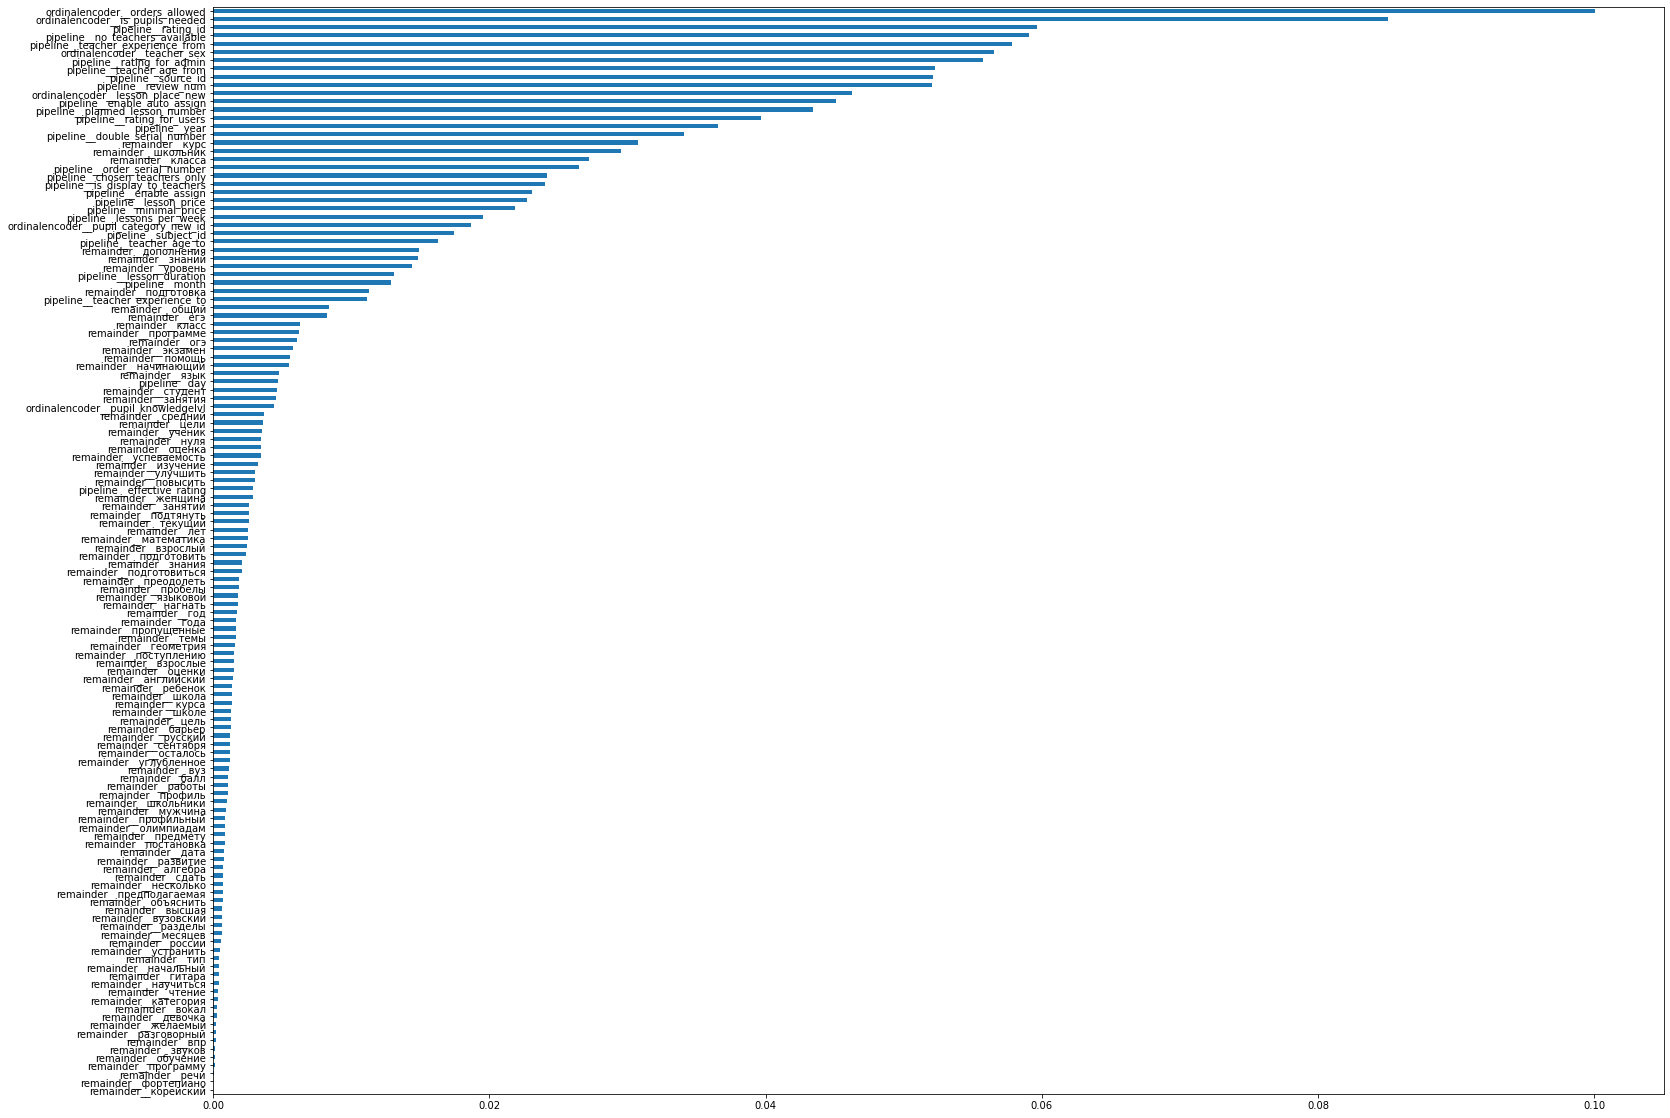

In [140]:
# Значимость признаков
x = preprocess_pipeline.fit_transform(features_train, target_train)
mi = mutual_info_classif(x, target_train, random_state=state)
#mi = mutual_info_classif(features_train, target_train, random_state=state)
feature_names = preprocess_pipeline.get_feature_names_out()
pd.Series(mi, index=feature_names).sort_values().plot(kind='barh', figsize=(26,20))
plt.show()

**Вывод:** для выполнения поставленной задачи:
1. был проведен исследовательский анализ данных; 
2. были сгенерированы новые признаки(год, месяц и день заявки; порядковый номер заявки для каждого клиента, порядковый номер дубля для каждой заявки), 
3. был сгенерирован целевой признак - факт оплаты заявкипостроен пайплайн машинного обучения, который отбрасывает высококоррелирующие признаки и строит модель CatBoostClassifier
4. с помощью RandomizedSearchCV были подобраны оптимальные параметры модели: число итераций - 100, learning rate - 0.1, глубина - 10. 
5. был построен график важностей фичей: на оплату заявки больше всего влияет тот факт, разрешено ли назначять репетитора на заявки, нужны ли ученики репетитору и параметр 'rating_id' для репетитора. 
6. Финальная метрика ROC-AUC на тестовой выборке равна 0.792, что соотвествует требованиям ТЗ. Однако эту метрику можно усовершенстовать, если найти лучший метод обработки текстовых признаков (например, sentence transformer) и увеличить сетку подбора гиперпараметров модели. 